In [1]:
color_line_1 = 'royalblue'
color_line_2 = 'red'
color_scatter_1 = 'black' #'darkslategrey' #darkred
filled_color_1 = 'lightslategrey' #'lightcoral'

text_color_1 = 'royalblue'
text_color_2 = 'red'

style_theme = 'whitegrid'

# Appendix

## Cubic Hermitian Spline

In [8]:
import torch

def compute_cubic_spline(parameters: torch.Tensor, step: int, horizon: int):
    """ Given a set of spline parameters, and the point in the trajectory return the function value 
    
    Args :
        parameters (Tensor): Spline action parameter      of shape(batch, num_legs, 3, spline_param)              
        step          (int): The point in the curve in [0, horizon]
        horizon       (int): The length of the curve
        
    Returns : 
        actions    (Tensor): Discrete action              of shape(batch, num_legs, 3)
    """
    # Find the point in the curve q in [0,1]
    tau = step/(horizon)        
    q = (tau - 0.0)/(1.0-0.0)
    
    # Compute the spline interpolation parameters
    a =  2*q*q*q - 3*q*q     + 1
    b =    q*q*q - 2*q*q + q
    c = -2*q*q*q + 3*q*q
    d =    q*q*q -   q*q

    # Compute intermediary parameters 
    phi_1 = 0.5*(parameters[...,2]  - parameters[...,0]) # shape (batch, num_legs, 3)
    phi_2 = 0.5*(parameters[...,3]  - parameters[...,1]) # shape (batch, num_legs, 3)

    # Compute the spline
    actions = a*parameters[...,1] + b*phi_1 + c*parameters[...,2]  + d*phi_2 # shape (batch, num_legs, 3)

    return actions

In [9]:
import torch
import matplotlib.pyplot as plt

start = 0
stop = 4
steps=100

parameters = torch.tensor((0.2, 1.0, 1.0, 0.3, 1.3, 0.9, 1.5))

x_param = torch.arange(start=start-1, end=stop+2)
# print(x_param)

x = torch.linspace(start=start, end=stop, steps=steps*(stop-start))
# print(x)

spline = torch.empty_like(x)

for i in range(start,stop):
    # print('\nRange ',i)
    for j in range(steps):
        # print('step  ', steps*i + j)
        spline[steps*i + j] = compute_cubic_spline(parameters=parameters[i:i+4], step=j, horizon=steps)


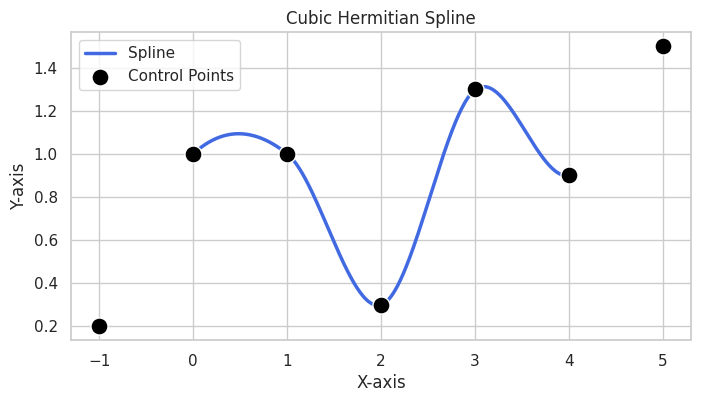

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style=style_theme)


# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the spline using Seaborn with custom color and line thickness
sns.lineplot(x=x, y=spline, ax=ax, color=color_line_1, linewidth=2.5, label='Spline')

# Add a dot plot on top of the spline
sns.scatterplot(x=x_param, y=parameters, ax=ax, color=color_scatter_1, s=150, label='Control Points', zorder=5)

# Add titles and labels
ax.set_title("Cubic Hermitian Spline", fontsize=12)
ax.set_xlabel("X-axis", fontsize=12)
ax.set_ylabel("Y-axis", fontsize=12)

# Add legend
ax.legend()

# Save the plot as a PDF for high-quality output in LaTeX
plt.savefig("thesis image/A/cubic_hermite_spline.pdf", bbox_inches='tight')
plt.show()


## Spline Fitting

In [5]:
import torch

# Example data
x_data = torch.tensor([0.0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.9, 1.0])  # 5 data points
y_data = torch.tensor([0.3, 0.0, 0.4, 0.7, 0.8, 0.6, 0.8, 1.0])  # Example target values

# Construct the design matrix X
X = torch.stack([x_data**3, x_data**2, x_data, torch.ones_like(x_data)], dim=1)

# Solve the normal equations (X^T X) beta = X^T Y
XtX = X.t().mm(X)  # X^T X
XtY = X.t().mm(y_data.unsqueeze(1))  # X^T Y

# Compute the coefficients
a, b, c, d = torch.linalg.solve(XtX, XtY).squeeze()

# Define a cubic function (example with a, b, c, d as parameters)
def cubic_function(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d


steps = 100

x_pred = torch.linspace(start=x_data[0], end=x_data[-1], steps=steps)
# print(x)

y_pred = cubic_function(x_pred, a, b, c, d)



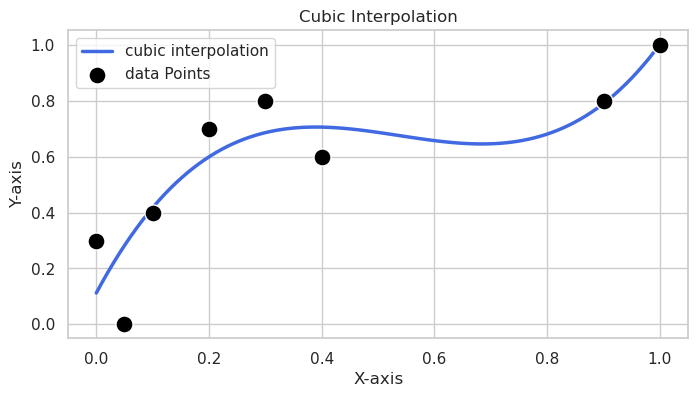

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style=style_theme)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the spline using Seaborn with custom color and line thickness
sns.lineplot(x=x_pred, y=y_pred, ax=ax, color=color_line_1, linewidth=2.5, label='cubic interpolation')

# Add a dot plot on top of the spline
sns.scatterplot(x=x_data, y=y_data, ax=ax, color=color_scatter_1, s=150, label='data Points', zorder=5)

# Add titles and labels
ax.set_title("Cubic Interpolation", fontsize=12)
ax.set_xlabel("X-axis", fontsize=12)
ax.set_ylabel("Y-axis", fontsize=12)

# Add legend
ax.legend()

# Save the plot as a PDF for high-quality output in LaTeX
plt.savefig("thesis image/A/cubic_interpolation.pdf", bbox_inches='tight')
plt.show()


## Spline fitting with constraints

In [7]:
import torch

# Construct the design matrix X
x_data_p = x_data[1:]
y_data_p = y_data[1:] - y_data[0]


X = torch.stack([x_data_p**3, x_data_p**2, x_data_p], dim=1)

# Solve the normal equations (X^T X) beta = X^T Y
XtX = X.t().mm(X)  # X^T X
XtY = X.t().mm(y_data_p.unsqueeze(1))  # X^T Y

# Compute the coefficients
a, b, c = torch.linalg.solve(XtX, XtY).squeeze()
d = y_data[0]

# Define a cubic function (example with a, b, c, d as parameters)
def cubic_function(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d


steps = 100

x_pred_constraint = torch.linspace(start=x_data[0], end=x_data[-1], steps=steps)
# print(x)

y_pred_constraint = cubic_function(x_pred_constraint, a, b, c, d)



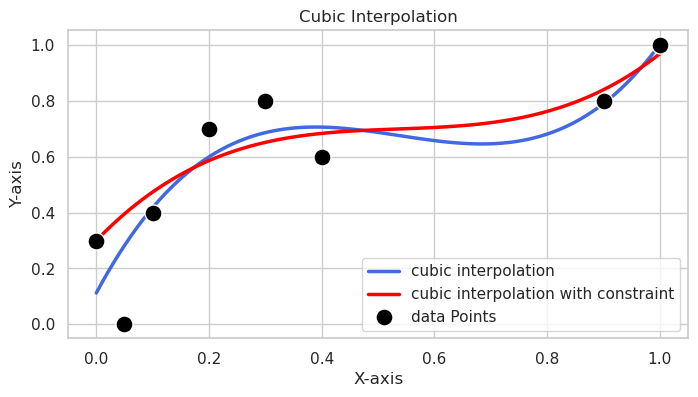

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style=style_theme)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the spline using Seaborn with custom color and line thickness
sns.lineplot(x=x_pred, y=y_pred, ax=ax, color=color_line_1, linewidth=2.5, label='cubic interpolation')

# Plot the spline using Seaborn with custom color and line thickness
sns.lineplot(x=x_pred_constraint, y=y_pred_constraint, ax=ax, color=color_line_2, linewidth=2.5, label='cubic interpolation with constraint')

# Add a dot plot on top of the spline
sns.scatterplot(x=x_data, y=y_data, ax=ax, color=color_scatter_1, s=150, label='data Points', zorder=5)

# Add titles and labels
ax.set_title("Cubic Interpolation", fontsize=12)
ax.set_xlabel("X-axis", fontsize=12)
ax.set_ylabel("Y-axis", fontsize=12)

# Add legend
ax.legend()

# Save the plot as a PDF for high-quality output in LaTeX
plt.savefig("thesis image/A/cubic_interpolation_with_constaint.pdf", bbox_inches='tight')
plt.show()


## Bezier Curve

In [9]:
import torch

start = 0
stop = 1
steps=100

t = torch.linspace(start=start, end=stop, steps=steps*(stop-start))
# print(t)

cp0 = torch.tensor((0.0, 0.0))
cp1 = torch.tensor((0.2, 1.0))
cp2 = torch.tensor((1.8, 1.0))
cp3 = torch.tensor((2.0, 0.0))


def bezier_curve_deg_3(t, cp0, cp1, cp2, cp3):
    return cp0*((1-t)**3) + 3*cp1*t*((1-t)**2) + 3*cp2*(t**2)*(1-t) + cp3*(t**3)

x = bezier_curve_deg_3(t, cp0[0], cp1[0], cp2[0], cp3[0])
y = bezier_curve_deg_3(t, cp0[1], cp1[1], cp2[1], cp3[1])


tensor([0.0000, 0.2000, 1.8000, 2.0000])
tensor([0., 1., 1., 0.])


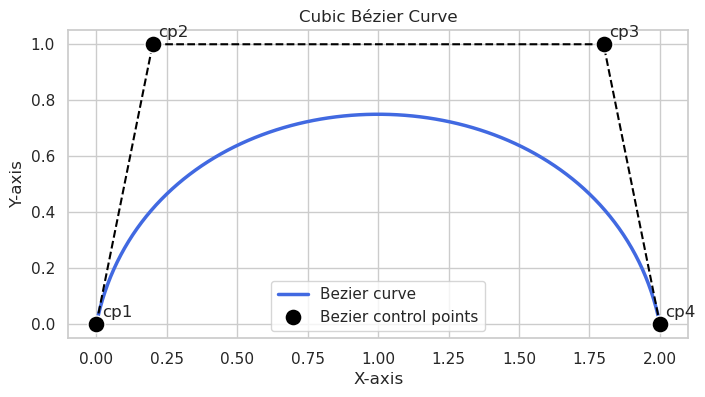

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style=style_theme)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the spline using Seaborn with custom color and line thickness
sns.lineplot(x=x, y=y, ax=ax, color=color_line_1, linewidth=2.5, label='Bezier curve')

sns.lineplot(x=torch.stack((cp0[0], cp1[0]+0.0001, cp2[0]-0.0001, cp3[0])), y=torch.stack((cp0[1], cp1[1], cp2[1], cp3[1])), ax=ax, color=color_scatter_1, linestyle='--')

# Add a dot plot on top of the spline
sns.scatterplot(x=torch.stack((cp0[0], cp1[0], cp2[0], cp3[0])), y=torch.stack((cp0[1], cp1[1], cp2[1], cp3[1])), ax=ax, color=color_scatter_1, s=150, label='Bezier control points', zorder=5)

# Annotate the control points
control_points = ['cp1', 'cp2', 'cp3', 'cp4']
for i, (x_val, y_val) in enumerate(zip([cp0[0], cp1[0], cp2[0], cp3[0]], [cp0[1], cp1[1], cp2[1], cp3[1]])):
    ax.annotate(control_points[i], (x_val.item(), y_val.item()), textcoords="offset points", xytext=(15,5), ha='center')

print(torch.stack((cp0[0], cp1[0], cp2[0], cp3[0])))
print(torch.stack((cp0[1], cp1[1], cp2[1], cp3[1])))

# Add titles and labels
ax.set_title("Cubic Bézier Curve", fontsize=12)
ax.set_xlabel("X-axis", fontsize=12)
ax.set_ylabel("Y-axis", fontsize=12)

# Add legend
ax.legend()

# Save the plot as a PDF for high-quality output in LaTeX
plt.savefig("thesis image/B/simple_bezier_curve.pdf", bbox_inches='tight')
plt.show()


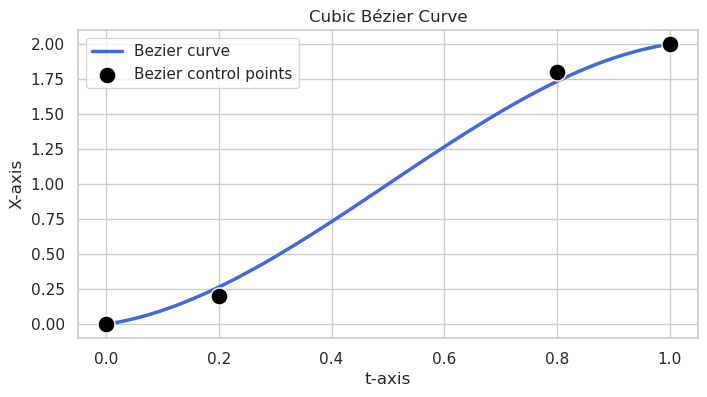

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style=style_theme)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the spline using Seaborn with custom color and line thickness
sns.lineplot(x=t, y=x, ax=ax, color=color_line_1, linewidth=2.5, label='Bezier curve')


# Add a dot plot on top of the spline
sns.scatterplot(x=torch.tensor((0.0, 0.2, 0.8 ,1.0)) ,y=torch.stack((cp0[0], cp1[0], cp2[0], cp3[0])), ax=ax, color=color_scatter_1, s=150, label='Bezier control points', zorder=5)


# Add titles and labels
ax.set_title("Cubic Bézier Curve", fontsize=12)
ax.set_xlabel("t-axis", fontsize=12)
ax.set_ylabel("X-axis", fontsize=12)

# Add legend
ax.legend()

# Save the plot as a PDF for high-quality output in LaTeX
# plt.savefig("thesis image/B/simple_bezier_curve.pdf", bbox_inches='tight')
plt.show()


## Swing Trajectory

### Swing trajectory Position

In [682]:
import torch

start = 0
stop = 1
steps=100

t = torch.linspace(start=start, end=stop, steps=steps*(stop-start))
# print(t)

p0 = torch.tensor((0.0, 0.0, 0.05))
p1 = torch.tensor((0.1, 0.1, 0.25))
p2 = torch.tensor((0.2, 0.2, 0.15))

# # Point for the swing traj plot
# # p0 = torch.tensor((0.0, 0.0, 0.00))
# # p1 = torch.tensor((0.1, 0.1, 0.10))
# # p2 = torch.tensor((0.2, 0.2, 0.0))
# p0 = torch.tensor((0.00, 0.00, 0.00))
# p1 = torch.tensor((0.05, 0.05, 0.10))
# p2 = torch.tensor((0.10, 0.10, 0.0))

# Normal CP
cp0_1 = torch.tensor((p0[0], p0[1], p0[2]))
cp1_1 = torch.tensor((p0[0], p0[1], p0[2]))
cp2_1 = torch.tensor((p0[0], p0[1], p1[2]))
cp3_1 = torch.tensor((p1[0], p1[1], p1[2]))

cp0_2 = torch.tensor((p1[0], p1[1], p1[2]))
cp1_2 = torch.tensor((p2[0], p2[1], p1[2]))
cp2_2 = torch.tensor((p2[0], p2[1], p2[2]))
cp3_2 = torch.tensor((p2[0], p2[1], p2[2]))

# Bat test
# cp0_1 = torch.tensor((p0[0], p0[1], p0[2]))
# cp1_1 = torch.tensor((p1[0], p1[1], p0[2]))
# cp2_1 = torch.tensor((p1[0], p1[1], p1[2]))
# cp3_1 = torch.tensor((p1[0], p1[1], p1[2]))

# cp0_2 = torch.tensor((p1[0], p1[1], p1[2]))
# cp1_2 = torch.tensor((p2[0], p2[1], p1[2]))
# cp2_2 = torch.tensor((p2[0], p2[1], p2[2]))
# cp3_2 = torch.tensor((p2[0], p2[1], p2[2]))


def bezier_curve_deg_3(t, cp0, cp1, cp2, cp3):
    return cp0*((1-t)**3) + 3*cp1*t*((1-t)**2) + 3*cp2*(t**2)*(1-t) + cp3*(t**3)

def dot_bezier_curve_deg_3(t, cp0, cp1, cp2, cp3):
    return 3*(cp1 - cp0)*((1 - t)**2) + 6*(cp2 - cp1)*(1 - t)*(t) + 3*(cp3 - cp2)*(t**2)

def dot_dot_bezier_curve_deg_3(t, cp0, cp1, cp2, cp3):
    return 6*(1 - t)*(cp2 - 2*cp1 + cp0) + 6*t*(cp3 - 2*cp2 + cp1)

x_1 = bezier_curve_deg_3(t, cp0_1[0], cp1_1[0], cp2_1[0], cp3_1[0])
y_1 = bezier_curve_deg_3(t, cp0_1[1], cp1_1[1], cp2_1[1], cp3_1[1])
z_1 = bezier_curve_deg_3(t, cp0_1[2], cp1_1[2], cp2_1[2], cp3_1[2])

x_2 = bezier_curve_deg_3(t, cp0_2[0], cp1_2[0], cp2_2[0], cp3_2[0])
y_2 = bezier_curve_deg_3(t, cp0_2[1], cp1_2[1], cp2_2[1], cp3_2[1])
z_2 = bezier_curve_deg_3(t, cp0_2[2], cp1_2[2], cp2_2[2], cp3_2[2])


x_dot_1 = dot_bezier_curve_deg_3(t, cp0_1[0], cp1_1[0], cp2_1[0], cp3_1[0])
y_dot_1 = dot_bezier_curve_deg_3(t, cp0_1[1], cp1_1[1], cp2_1[1], cp3_1[1])
z_dot_1 = dot_bezier_curve_deg_3(t, cp0_1[2], cp1_1[2], cp2_1[2], cp3_1[2])

x_dot_2 = dot_bezier_curve_deg_3(t, cp0_2[0], cp1_2[0], cp2_2[0], cp3_2[0])
y_dot_2 = dot_bezier_curve_deg_3(t, cp0_2[1], cp1_2[1], cp2_2[1], cp3_2[1])
z_dot_2 = dot_bezier_curve_deg_3(t, cp0_2[2], cp1_2[2], cp2_2[2], cp3_2[2])

x_dot_dot_1 = dot_dot_bezier_curve_deg_3(t, cp0_1[0], cp1_1[0], cp2_1[0], cp3_1[0])
y_dot_dot_1 = dot_dot_bezier_curve_deg_3(t, cp0_1[1], cp1_1[1], cp2_1[1], cp3_1[1])
z_dot_dot_1 = dot_dot_bezier_curve_deg_3(t, cp0_1[2], cp1_1[2], cp2_1[2], cp3_1[2])

x_dot_dot_2 = dot_dot_bezier_curve_deg_3(t, cp0_2[0], cp1_2[0], cp2_2[0], cp3_2[0])
y_dot_dot_2 = dot_dot_bezier_curve_deg_3(t, cp0_2[1], cp1_2[1], cp2_2[1], cp3_2[1])
z_dot_dot_2 = dot_dot_bezier_curve_deg_3(t, cp0_2[2], cp1_2[2], cp2_2[2], cp3_2[2])

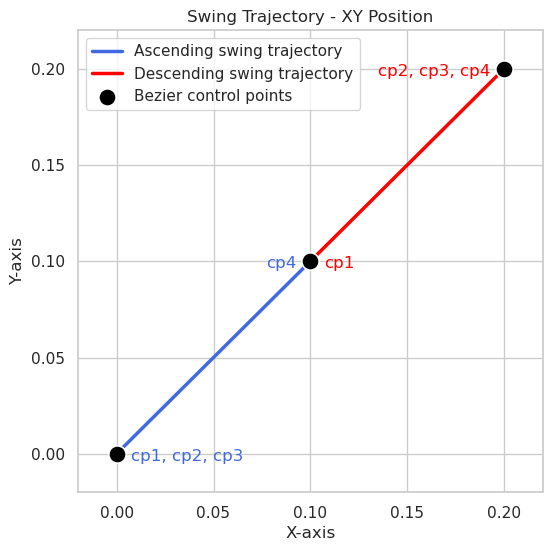

In [683]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style=style_theme)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the spline using Seaborn with custom color and line thickness
sns.lineplot(x=x_1, y=y_1, ax=ax, color=color_line_1, linewidth=2.5, label='Ascending swing trajectory')
sns.lineplot(x=x_2, y=y_2, ax=ax, color=color_line_2, linewidth=2.5, label='Descending swing trajectory')

# Add a dot plot on top of the spline
sns.scatterplot(x=torch.stack((cp0_1[0], cp1_1[0], cp2_1[0], cp3_1[0])), y=torch.stack((cp0_1[1], cp1_1[1], cp2_1[1], cp3_1[1])), ax=ax, color=color_scatter_1, s=150, label='Bezier control points', zorder=5)
sns.scatterplot(x=torch.stack((cp0_2[0], cp1_2[0], cp2_2[0], cp3_2[0])), y=torch.stack((cp0_2[1], cp1_2[1], cp2_2[1], cp3_2[1])), ax=ax, color=color_scatter_1, s=150, zorder=5)


# Annotate the control points
control_points = ['cp1, cp2, cp3']
for i, (x_val, y_val) in enumerate(zip([cp0_1[0]], [cp0_1[1]])):
    ax.annotate(control_points[i], (x_val.item(), y_val.item()), textcoords="offset points", xytext=(10,-5), color=text_color_1)
control_points = ['cp4']
for i, (x_val, y_val) in enumerate(zip([cp3_1[0]], [cp3_1[1]])):
    ax.annotate(control_points[i], (x_val.item(), y_val.item()), textcoords="offset points", xytext=(-10,-5), ha='right', color=text_color_1)
control_points = ['cp1']
for i, (x_val, y_val) in enumerate(zip([cp0_2[0]], [cp0_2[1]])):
    ax.annotate(control_points[i], (x_val.item(), y_val.item()), textcoords="offset points", xytext=(10,-5), ha='left', color=text_color_2)
control_points = ['cp2, cp3, cp4']
for i, (x_val, y_val) in enumerate(zip([cp3_2[0]], [cp3_2[1]])):
    ax.annotate(control_points[i], (x_val.item(), y_val.item()), textcoords="offset points", xytext=(-10,-5), ha='right', color=text_color_2)

# Add titles and labels
ax.set_title("Swing Trajectory - XY Position", fontsize=12)
ax.set_xlabel("X-axis", fontsize=12)
ax.set_ylabel("Y-axis", fontsize=12)

ax.set_xlim(-0.02, 0.22)
ax.set_ylim(-0.02, 0.22)

# Add legend
ax.legend()

# Save the plot as a PDF for high-quality output in LaTeX
plt.savefig("thesis image/B/xy_bezier_curve.pdf", bbox_inches='tight')
plt.show()


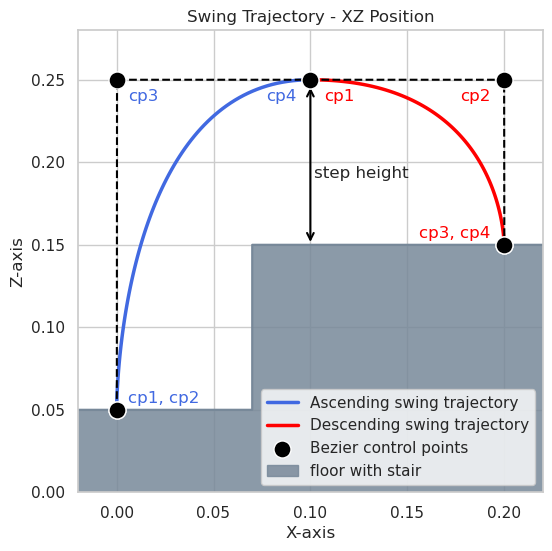

In [684]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style=style_theme)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the spline using Seaborn with custom color and line thickness
sns.lineplot(x=x_1, y=z_1, ax=ax, color=color_line_1, linewidth=2.5, label='Ascending swing trajectory')
sns.lineplot(x=x_2, y=z_2, ax=ax, color=color_line_2, linewidth=2.5, label='Descending swing trajectory')

sns.lineplot(x=torch.stack((cp0_1[0], cp1_1[0]+0.0001, cp2_1[0]+0.0002, cp3_1[0])), y=torch.stack((cp0_1[2], cp1_1[2], cp2_1[2], cp3_1[2])), ax=ax, color=color_scatter_1, linestyle='--')
sns.lineplot(x=torch.stack((cp0_2[0], cp1_2[0], cp2_2[0]+0.0001, cp3_2[0]+0.0001)), y=torch.stack((cp0_2[2], cp1_2[2], cp2_2[2], cp3_2[2])), ax=ax, color=color_scatter_1, linestyle='--')


# Add a dot plot on top of the spline
sns.scatterplot(x=torch.stack((cp0_1[0], cp1_1[0], cp2_1[0], cp3_1[0])), y=torch.stack((cp0_1[2], cp1_1[2], cp2_1[2], cp3_1[2])), ax=ax, color=color_scatter_1, s=150, label='Bezier control points', zorder=5)
sns.scatterplot(x=torch.stack((cp0_2[0], cp1_2[0], cp2_2[0], cp3_2[0])), y=torch.stack((cp0_2[2], cp1_2[2], cp2_2[2], cp3_2[2])), ax=ax, color=color_scatter_1, s=150, zorder=5)

# Annotate the control points
control_points = ['cp1, cp2']
for i, (x_val, y_val) in enumerate(zip([cp0_1[0]], [cp0_1[2]])):
    ax.annotate(control_points[i], (x_val.item(), y_val.item()), textcoords="offset points", xytext=(8,5), color=text_color_1)
control_points = ['cp3']
for i, (x_val, y_val) in enumerate(zip([cp2_1[0]], [cp2_1[2]])):
    ax.annotate(control_points[i], (x_val.item(), y_val.item()), textcoords="offset points", xytext=(8,-15), color=text_color_1)
control_points = ['cp4']
for i, (x_val, y_val) in enumerate(zip([cp3_1[0]], [cp3_1[2]])):
    ax.annotate(control_points[i], (x_val.item(), y_val.item()), textcoords="offset points", xytext=(-10,-15), ha='right', color=text_color_1)
control_points = ['cp1']
for i, (x_val, y_val) in enumerate(zip([cp0_2[0]], [cp0_2[2]])):
    ax.annotate(control_points[i], (x_val.item(), y_val.item()), textcoords="offset points", xytext=(10,-15), ha='left', color=text_color_2)
control_points = ['cp2']
for i, (x_val, y_val) in enumerate(zip([cp1_2[0]], [cp1_2[2]])):
    ax.annotate(control_points[i], (x_val.item(), y_val.item()), textcoords="offset points", xytext=(-10,-15), ha='right', color=text_color_2)
    control_points = ['cp3, cp4']
for i, (x_val, y_val) in enumerate(zip([cp3_2[0]], [cp3_2[2]])):
    ax.annotate(control_points[i], (x_val.item(), y_val.item()), textcoords="offset points", xytext=(-10,5), ha='right', color=text_color_2)


# add the stair
x = torch.tensor((-1.0, 0.07, 0.07001, 1.2))
y = torch.tensor((0.05, 0.05, 0.15, 0.15))
sns.lineplot(x=x, y=y, ax=ax, color=filled_color_1)
ax.fill_between(x, y, color=filled_color_1, alpha=0.85, label='floor with stair')

#  Draw a double-sided arrow
A = (0.10, 0.15)
B = (0.10, 0.247)
ax.annotate(
    '', xy=B, xytext=A,
    arrowprops=dict(arrowstyle='<->', color='black', lw=1.5)
)
ax.text((A[0] + B[0]) / 2 + 0.002, (A[1] + B[1]) / 2 - 0.005, 'step height', fontsize=12, ha='left', va='center')


# Add titles and labels
ax.set_title("Swing Trajectory - XZ Position", fontsize=12)
ax.set_xlabel("X-axis", fontsize=12)
ax.set_ylabel("Z-axis", fontsize=12)

ax.set_xlim(-0.02, 0.22)
ax.set_ylim(0.0, 0.28)

# Add legend
ax.legend()

# Save the plot as a PDF for high-quality output in LaTeX
plt.savefig("thesis image/B/z_bezier_curve.pdf", bbox_inches='tight')
plt.show()


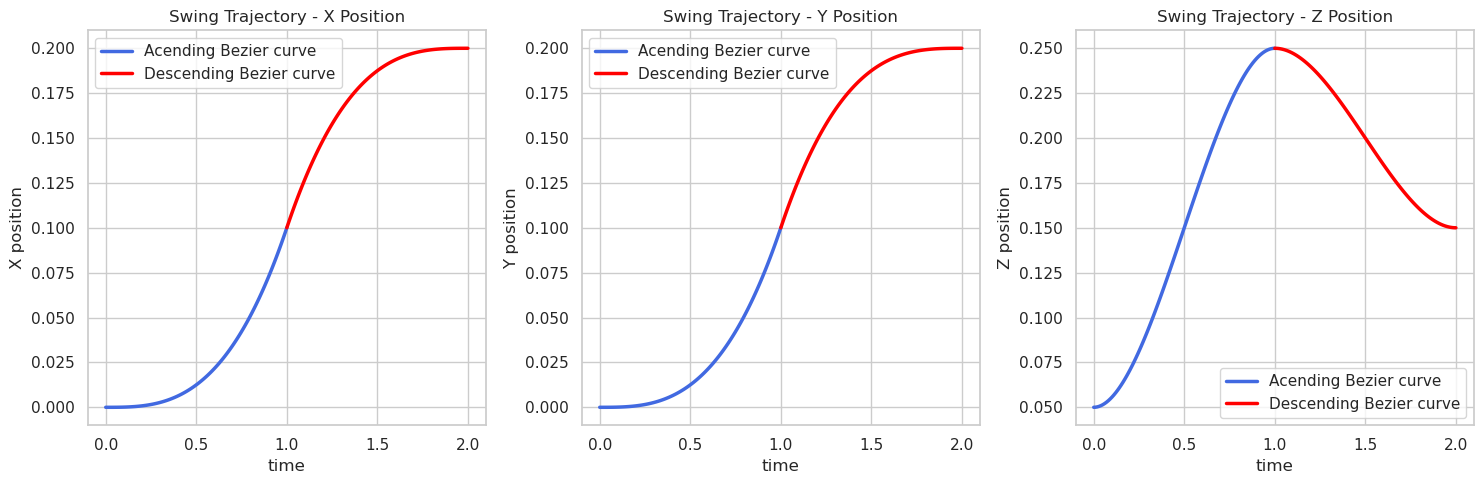

In [685]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming t, x_1, x_2, y_1, y_2, z_1, z_2 are defined
# and style_theme, color_line_1 are also defined

sns.set_theme(style=style_theme)

# Create a figure and a 1x3 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

label_1 = 'Acending Bezier curve'
label_2 = 'Descending Bezier curve'

# Plot x position on the first subplot
sns.lineplot(x=t, y=x_1, ax=axes[0], color=color_line_1, linewidth=2.5, label=label_1)
sns.lineplot(x=t+1, y=x_2, ax=axes[0], color=color_line_2, linewidth=2.5, label=label_2)
axes[0].set_title("Swing Trajectory - X Position", fontsize=12)
axes[0].set_xlabel("time", fontsize=12)
axes[0].set_ylabel("X position", fontsize=12)
axes[0].legend()

# Plot y position on the second subplot
sns.lineplot(x=t, y=y_1, ax=axes[1], color=color_line_1, linewidth=2.5, label=label_1)
sns.lineplot(x=t+1, y=y_2, ax=axes[1], color=color_line_2, linewidth=2.5, label=label_2)
axes[1].set_title("Swing Trajectory - Y Position", fontsize=12)
axes[1].set_xlabel("time", fontsize=12)
axes[1].set_ylabel("Y position", fontsize=12)
axes[1].legend()

# Plot z position on the third subplot
sns.lineplot(x=t, y=z_1, ax=axes[2], color=color_line_1, linewidth=2.5, label=label_1)
sns.lineplot(x=t+1, y=z_2, ax=axes[2], color=color_line_2, linewidth=2.5, label=label_2)
axes[2].set_title("Swing Trajectory - Z Position", fontsize=12)
axes[2].set_xlabel("time", fontsize=12)
axes[2].set_ylabel("Z position", fontsize=12)
axes[2].legend()#loc='lower right')

# axes[2].set_xlim(-0.1, 2.1)
# axes[2].set_ylim(0.0, 0.28)

# Adjust layout
plt.tight_layout()

# Save the plot as a PDF for high-quality output in LaTeX
plt.savefig("thesis image/B/xyz_position_bezier_curve.pdf", bbox_inches='tight')
plt.show()


### Swing traj 3D plot for report

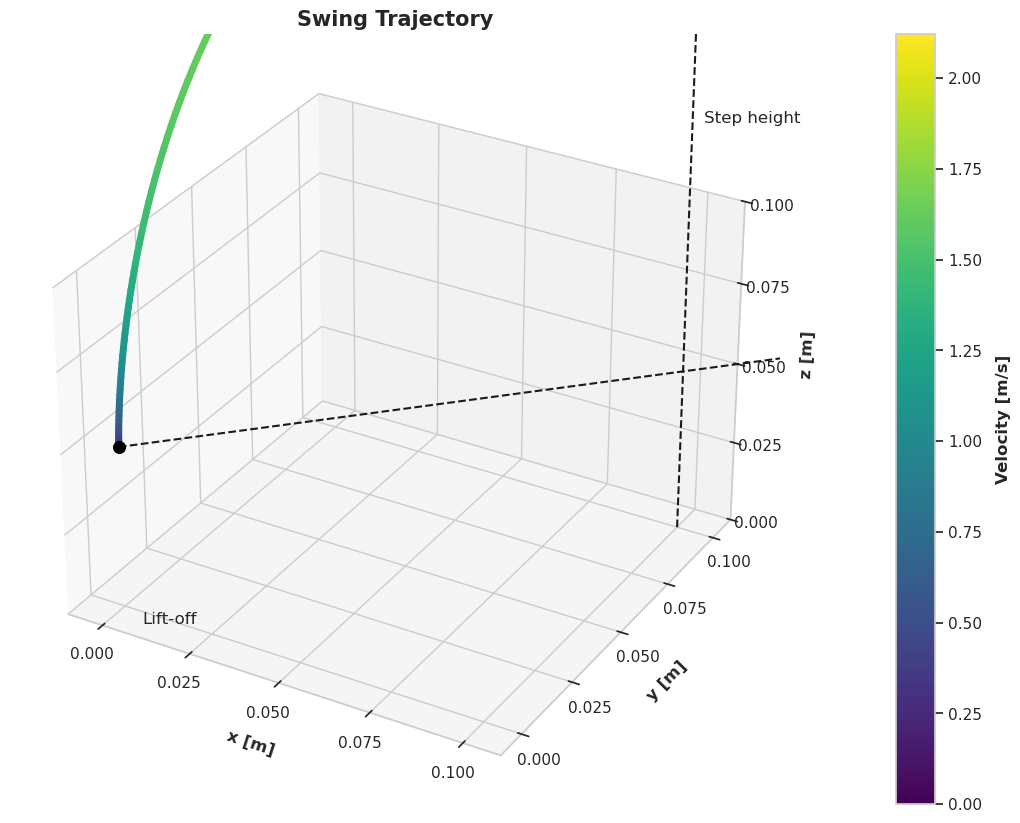

In [686]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Sample data (use your actual data here)
# p_x, p_y, p_z, v_x, v_y, v_z = np.array([...]), np.array([...]), np.array([...]), np.array([...]), np.array([...]), np.array([...])

p_x = np.concatenate([x_1,x_2])
p_y = np.concatenate([y_1,y_2])
p_z = np.concatenate([z_1,z_2])

v_x = np.concatenate([x_dot_1,x_dot_2])*5
v_y = np.concatenate([y_dot_1,y_dot_2])*5
v_z = np.concatenate([z_dot_1,z_dot_2])*5

# Compute the norm of the velocity
velocity_norm = np.sqrt((v_x**2) + (v_y**2) + (v_z**2))

# Normalize the velocity norm for color mapping
norm = plt.Normalize(velocity_norm.min(), velocity_norm.max())

# Create a color map
cmap = plt.cm.viridis

# Create a 3D plot
sns.set_style(style="whitegrid")

# Create a figure and a 3D axis
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the trajectory
for i in range(len(p_x)-1):
    ax.plot(p_x[i:i+2], p_y[i:i+2], p_z[i:i+2], color=cmap(norm(velocity_norm[i])), linewidth=5)


# Label specific points
ax.scatter(p_x[0], p_y[0], p_z[0], s=70, label='Lift-off' , color='black')
ax.scatter(p_x[-1], p_y[-1], p_z[-1], s=70, label='Touch down', color='black')

middle_index = len(p_x) // 2
# ax.scatter(p_x[middle_index], p_y[middle_index], p_z[middle_index], color='black', s=100, label='Step height')
# ax.text(p_x[middle_index], p_y[middle_index], p_z[middle_index], ' Step height', color='blue')

# Label the midpoint of the dashed line
midpoint_x = p_x[middle_index]
midpoint_y = p_y[middle_index]
midpoint_z = (0 + p_z[middle_index]) / 2
offset = 0.002  # Adjust as needed
ax.text(midpoint_x + offset, midpoint_y + offset, midpoint_z, 'Step height')#, color='blue', fontsize=12)


# Dashed line between lift-off and touch down in the XY plane
ax.plot([p_x[0], p_x[-1]], [p_y[0], p_y[-1]], [p_z[0], p_z[0]], 'k--')

# Dashed line between step height in the XY plane and step height point
ax.plot([p_x[middle_index], p_x[middle_index]], [p_y[middle_index], p_y[middle_index]], [0, p_z[middle_index]], 'k--')


# Create a color bar
mappable = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
mappable.set_array(velocity_norm)
cbar = plt.colorbar(mappable, ax=ax, pad=0.1)



# Set the labels on the XY plane and adjust their positions
ax.text(p_x[0]+0.005, p_y[0], 0, 'Lift-off',fontsize=12, ha='left', va='top') #color='red', 
ax.text(p_x[-1]-0.005, p_y[-1], 0, 'Touch down', fontsize=12, ha='right', va='bottom') # color='red', 




# Add color bar for reference
# fig.colorbar(surf, shrink=0.5, aspect=5)

# Add titles and labels
ax.set_title('Swing Trajectory', fontsize=15, fontweight='bold')
ax.set_xlabel('x [m]', fontsize=12, labelpad=10, fontweight='bold')#, fontweight='bold')
ax.set_ylabel('y [m]', fontsize=12, labelpad=10, fontweight='bold')
ax.set_zlabel('z [m]', fontsize=12, labelpad=10, fontweight='bold')
cbar.set_label('Velocity [m/s]', fontsize=12, labelpad=10, fontweight='bold')



min_x, max_x = 0.00, 0.10
min_y, max_y = 0.00, 0.10
min_z, max_z = 0.00, 0.10
ax.set_xlim(min_x-0.01, max_x+0.01)
ax.set_ylim(min_y-0.01, max_y+0.01)
ax.set_zlim(min_z, max_z)
# Customize tick intervals
ax.set_xticks(np.linspace(min_x, max_x, 5))
ax.set_yticks(np.linspace(min_y, max_y, 5))
ax.set_zticks(np.linspace(min_z, max_z, 5))
# ax.grid(True, linestyle='--', color='gray', linewidth=0.5)

plt.savefig("thesis image/4.5/swing_traj.pdf", bbox_inches='tight')

# Show plot
plt.show()


### Swing Trajectory Velocity

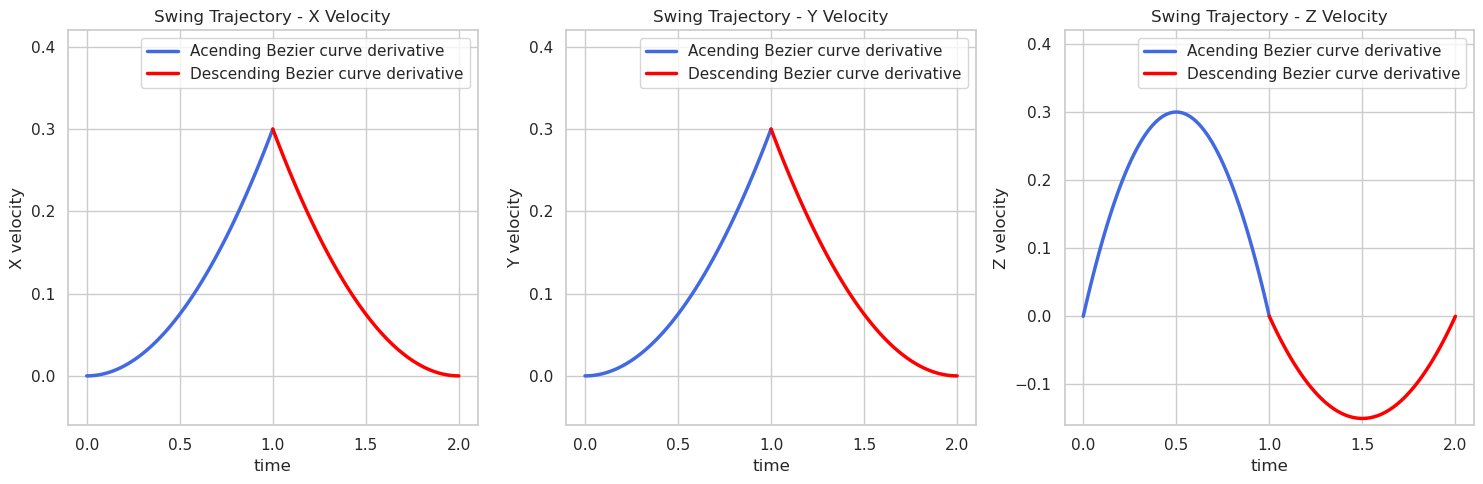

In [687]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming t, x_dot_1, x_dot_2, y_dot_1, y_dot_2, z_dot_1, z_dot_2 are defined
# and style_theme, color_line_1, and color_line_2 are also defined

sns.set_theme(style=style_theme)

label_1 = 'Acending Bezier curve derivative'
label_2 = 'Descending Bezier curve derivative'

# Create a figure and a 1x3 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot x velocity on the first subplot
sns.lineplot(x=t, y=x_dot_1, ax=axes[0], color=color_line_1, linewidth=2.5, label=label_1)
sns.lineplot(x=t+1, y=x_dot_2, ax=axes[0], color=color_line_2, linewidth=2.5, label=label_2)
axes[0].set_title("Swing Trajectory - X Velocity", fontsize=12)
axes[0].set_xlabel("time", fontsize=12)
axes[0].set_ylabel("X velocity", fontsize=12)
# axes[0].legend()
axes[0].set_ylim(-0.06, 0.42)

# Plot y velocity on the second subplot
sns.lineplot(x=t, y=y_dot_1, ax=axes[1], color=color_line_1, linewidth=2.5, label=label_1)
sns.lineplot(x=t+1, y=y_dot_2, ax=axes[1], color=color_line_2, linewidth=2.5, label=label_2)
axes[1].set_title("Swing Trajectory - Y Velocity", fontsize=12)
axes[1].set_xlabel("time", fontsize=12)
axes[1].set_ylabel("Y velocity", fontsize=12)
axes[1].legend()
axes[1].set_ylim(-0.06, 0.42)

# Plot z velocity on the third subplot
sns.lineplot(x=t, y=z_dot_1, ax=axes[2], color=color_line_1, linewidth=2.5, label=label_1)
sns.lineplot(x=t+1, y=z_dot_2, ax=axes[2], color=color_line_2, linewidth=2.5, label=label_2)
axes[2].set_title("Swing Trajectory - Z Velocity", fontsize=12)
axes[2].set_xlabel("time", fontsize=12)
axes[2].set_ylabel("Z velocity", fontsize=12)
axes[2].legend()

axes[2].set_ylim(-0.16, 0.42)

# Adjust layout
plt.tight_layout()

# Save the plot as a PDF for high-quality output in LaTeX
plt.savefig("thesis image/B/xyz_dot_bezier_curve.pdf", bbox_inches='tight')
plt.show()


### Swing trajectory Acceleration

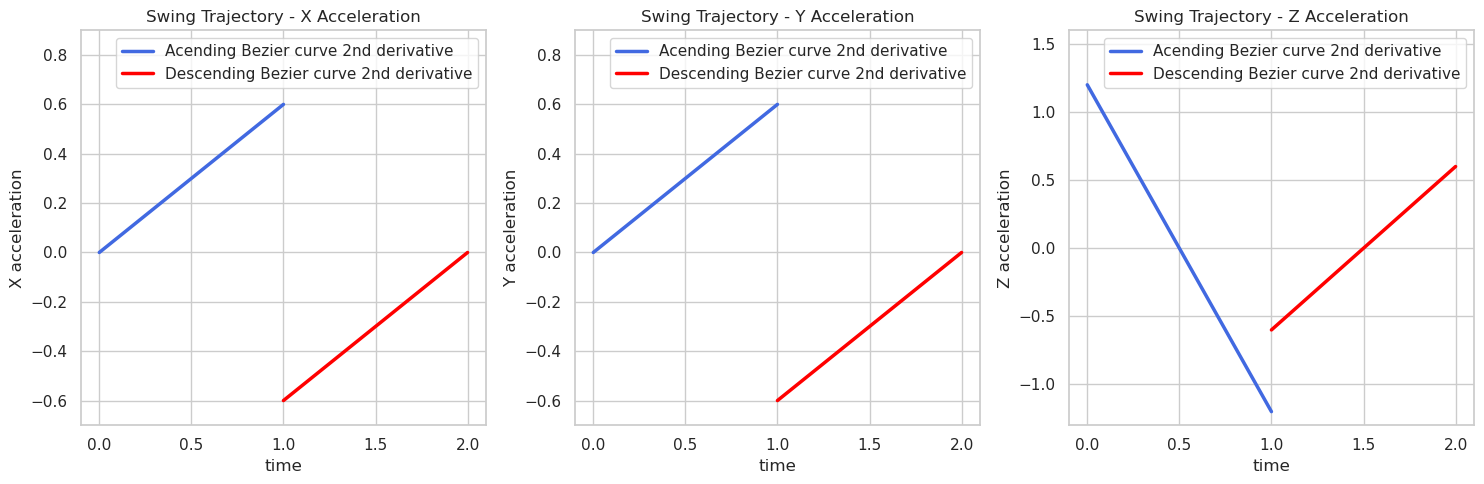

In [688]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming t, x_dot_dot_1, x_dot_dot_2, y_dot_dot_1, y_dot_dot_2, z_dot_dot_1, z_dot_dot_2 are defined
# and style_theme, color_line_1, and color_line_2 are also defined
sns.set_theme(style=style_theme)
# sns.set_context("paper")

# Create a figure and a 1x3 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

label_1 = 'Acending Bezier curve 2nd derivative'
label_2 = 'Descending Bezier curve 2nd derivative'

# Plot x acceleration on the first subplot
sns.lineplot(x=t, y=x_dot_dot_1, ax=axes[0], color=color_line_1, linewidth=2.5, label=label_1)
sns.lineplot(x=t+1, y=x_dot_dot_2, ax=axes[0], color=color_line_2, linewidth=2.5, label=label_2)
axes[0].set_title("Swing Trajectory - X Acceleration", fontsize=12)
axes[0].set_xlabel("time", fontsize=12)
axes[0].set_ylabel("X acceleration", fontsize=12)
axes[0].legend(loc='upper right')
axes[0].set_ylim(-0.7, 0.9)

# Plot y acceleration on the second subplot
sns.lineplot(x=t, y=y_dot_dot_1, ax=axes[1], color=color_line_1, linewidth=2.5, label=label_1)
sns.lineplot(x=t+1, y=y_dot_dot_2, ax=axes[1], color=color_line_2, linewidth=2.5, label=label_2)
axes[1].set_title("Swing Trajectory - Y Acceleration", fontsize=12)
axes[1].set_xlabel("time", fontsize=12)
axes[1].set_ylabel("Y acceleration", fontsize=12)
axes[1].legend(loc='upper right')
axes[1].set_ylim(-0.7, 0.9)

# Plot z acceleration on the third subplot
sns.lineplot(x=t, y=z_dot_dot_1, ax=axes[2], color=color_line_1, linewidth=2.5, label=label_1)
sns.lineplot(x=t+1, y=z_dot_dot_2, ax=axes[2], color=color_line_2, linewidth=2.5, label=label_2)
axes[2].set_title("Swing Trajectory - Z Acceleration", fontsize=12)
axes[2].set_xlabel("time", fontsize=12)
axes[2].set_ylabel("Z acceleration", fontsize=12)
axes[2].legend(loc='upper right')
axes[2].set_ylim(-1.3, 1.6)

# Adjust layout
plt.tight_layout()

# Save the plot as a PDF for high-quality output in LaTeX
plt.savefig("thesis image/B/xyz_dot_dot_bezier_curve.pdf", bbox_inches='tight')
plt.show()


## Soft Exp Kernel

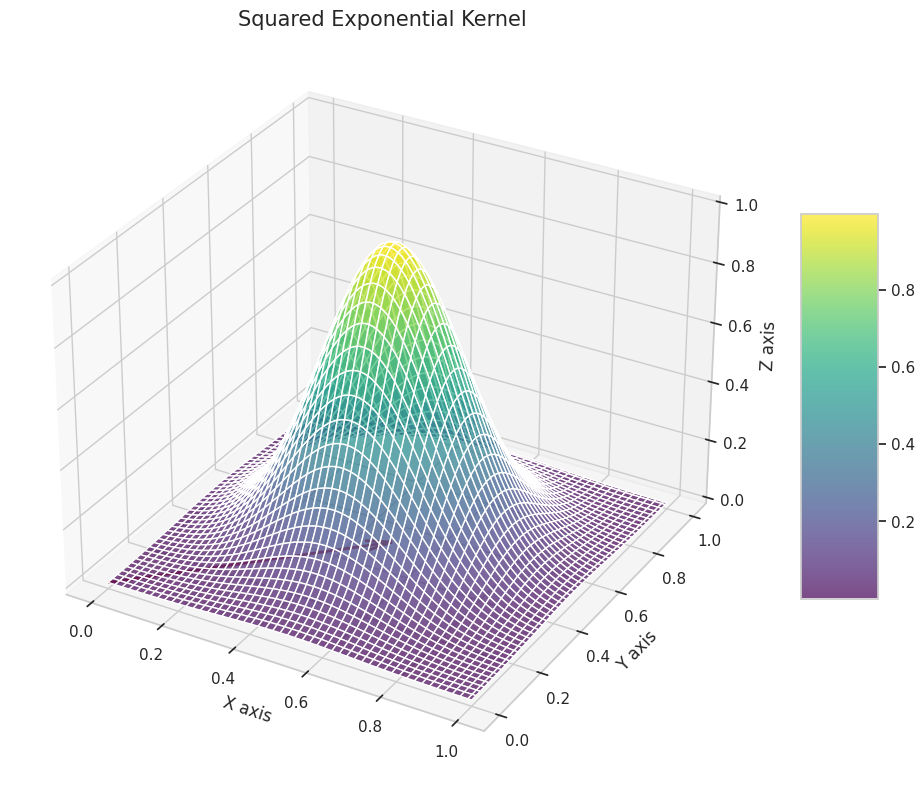

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Set the Seaborn style
sns.set_theme(style="whitegrid")

v = np.array([0.5,0.5])
std = 0.25

# Define the function f(x, y)
def f(x, y):
    lin_err = (v[0] - x)**2 + (v[1] - y)**2
    return np.exp(-lin_err/(std**2))
    # return np.sin(np.sqrt(x**2 + y**2))

# Create a grid of x, y values
x = np.linspace(0.0, 1, 100)
y = np.linspace(0.0, 1, 100)
x, y = np.meshgrid(x, y)
z = f(x, y)

# Create a figure and a 3D axis
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface with transparency
surf = ax.plot_surface(x, y, z, cmap='viridis', alpha=0.7)#,  zorder=1)  # alpha controls transparency

# Add color bar for reference
fig.colorbar(surf, shrink=0.5, aspect=5)

# Draw the arrow in the xy-plane
ax.quiver(0, 0, 0, v[0], v[1], 0, color='r', arrow_length_ratio=0.1,  linewidth=2, zorder=40)

x_line = [0.5, 0.5]
y_line = [0.5, 0.5]
z_line = [0.0, 1.0]
# ax.plot(x_line, y_line, z_line, linestyle='--', color='r',  linewidth=2, zorder=30)

# ax.scatter(0.5, 0.5, 1.0, s=50, color='r', zorder=31, label='Scatter point')

# Add titles and labels
ax.set_title('Squared Exponential Kernel', fontsize=15)
ax.set_xlabel('X axis', fontsize=12)
ax.set_ylabel('Y axis', fontsize=12)
ax.set_zlabel('Z axis', fontsize=12)

plt.savefig("thesis image/D/squared_exponential.pdf", bbox_inches='tight')

# Show the plot
plt.show()


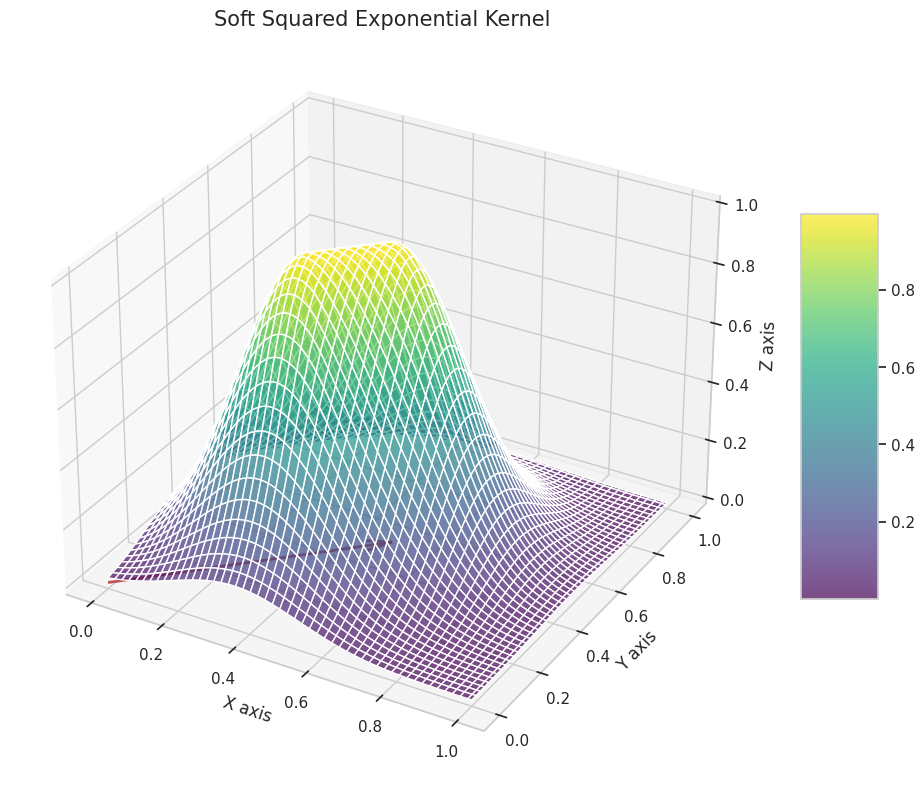

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Set the Seaborn style
sns.set_theme(style="whitegrid")


v = np.array([0.5,0.5])
std = 0.25
alpha=0.2

# Define the function f(x, y)
def f(vx, vy):

    v_ref_norm = ((v[0]**2) + (v[1]**2))**(0.5)

    forward_error = -v_ref_norm + ((v[0]*vx + v[1]*vy)/(v_ref_norm))
    lateral_error = -(v[1]*vx - v[0]*vy)/(v_ref_norm)

    x_sup_0 = forward_error >= 0.0
    # x_in_0_alpha = (forward_error >= -alpha) and (forward_error <= 0)
    x_inf_alpha = forward_error < -alpha

    h_forward_error = 0.0 + (forward_error*x_sup_0) + ((forward_error + alpha)*x_inf_alpha) #+ (0 * x_in_0_alpha) 
    # h_forward_error = forward_error

    return np.exp(-((h_forward_error**2) + (lateral_error**2))/(std**2))
    # return np.sin(np.sqrt(x**2 + y**2))

# Create a grid of x, y values
x = np.linspace(0.0, 1, 100)
y = np.linspace(0.0, 1, 100)
x, y = np.meshgrid(x, y)
z = f(x, y)

# Create a figure and a 3D axis
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface with transparency
surf = ax.plot_surface(x, y, z, cmap='viridis', alpha=0.7)#,  zorder=1)  # alpha controls transparency

# Add color bar for reference
fig.colorbar(surf, shrink=0.5, aspect=5)


# Draw the arrow in the xy-plane
ax.quiver(0, 0, 0, v[0], v[1], 0, color='r', arrow_length_ratio=0.1,  linewidth=2, zorder=40)

# x_line = [0.5, 0.5]
# y_line = [0.5, 0.5]
# z_line = [0.0, 1.0]
# ax.plot(x_line, y_line, z_line, linestyle='--', color='r',  linewidth=2, zorder=30)

# ax.scatter(0.5, 0.5, 1.0, s=50, color='r', zorder=31, label='Scatter point')

# Add titles and labels
ax.set_title('Soft Squared Exponential Kernel', fontsize=15)
ax.set_xlabel('X axis', fontsize=12)
ax.set_ylabel('Y axis', fontsize=12)
ax.set_zlabel('Z axis', fontsize=12)

plt.savefig("thesis image/D/soft_squared_exponential.pdf", bbox_inches='tight')

# Show the plot
plt.show()


# Imitiation Learning Plot

## Activation Function

In [56]:
import os
import json
import torch
import pandas as pd

epochs = torch.arange(20)+1

# Specify the full path to the directory
path = "/home/baptiste/Downloads/Activation func data/H5 - dis dis - miniB64"


experiment = []
short_experiment = []
simulation_performance = []

epoch_reward_df = pd.DataFrame(columns=list(range(1, 21)))
epoch_MSE_df = pd.DataFrame(columns=list(range(1, 21)))


for folder_name in os.listdir(path):
    full_path = os.path.join(path, folder_name)
    if os.path.isdir(full_path):
        print("Folder:", full_path)

        # Read data
        json_info_path = os.path.join(full_path, "info.json")
        json_data_path = os.path.join(full_path, "results.json")
        
        if os.path.isfile(json_info_path):
            with open(json_info_path, 'r') as json_file:
                info_dict = json.load(json_file)  # Load JSON data into a Python dictionary
                # print("JSON data:", info_dict)  # You can process the dictionary as needed
        if os.path.isfile(json_data_path):
            with open(json_data_path, 'r') as json_file:
                data_dict = json.load(json_file)  # Load JSON data into a Python dictionary
                # print("JSON data:", data_dict)  # You can process the dictionary as needed


        experiment_name = f"H{info_dict['prediction_horizon_step']}-MB{info_dict['minibatach size']}-{info_dict['p_typeAction']}-{info_dict['F_typeAction']}-{info_dict['Activation function']['type']}-{info_dict['Activation function']['param']}"
        print(experiment_name)
        short_experiment_name = f"{info_dict['Activation function']['type']}-{info_dict['Activation function']['param']}"
        print(short_experiment_name)

        sim_perf = (data_dict['Epoch_Reward']['epoch_reward_stud'] - data_dict['untrained_stud_Epoch_Reward']['epoch_reward_untrained_stud']) / (data_dict['Epoch_Reward']['epoch_reward_test'] - data_dict['untrained_stud_Epoch_Reward']['epoch_reward_untrained_stud'])
        # sim_perf = (data_dict['Epoch_Reward']['epoch_reward_stud']) 
        print(sim_perf)

        experiment.append(experiment_name)
        short_experiment.append(short_experiment_name)
        simulation_performance.append(sim_perf)


        reward_data = pd.read_csv(os.path.join(full_path, "average_epoch_reward.csv"), header=None).values.flatten()
        epoch_reward_df.loc[short_experiment_name] = reward_data

        MSE_data = pd.read_csv(os.path.join(full_path, "epoch_mse_test_loss.csv"), header=None).values[:,-1].flatten()
        epoch_MSE_df.loc[short_experiment_name] = MSE_data


new_order_positions = [2, 1, 0, 3, 4]
# Reorder the DataFrame rows
epoch_reward_df = epoch_reward_df.iloc[new_order_positions]
epoch_MSE_df = epoch_MSE_df.iloc[new_order_positions]


reward_max = epoch_reward_df.max().max()
reward_min = epoch_reward_df.min().min()
print()
print(reward_max)
print(reward_min)


# rescale epoch reward
epoch_reward_df = (epoch_reward_df - reward_min + 100) / (reward_max - reward_min + 105)
epoch_reward_df

epoch_MSE_df


Folder: /home/baptiste/Downloads/Activation func data/H5 - dis dis - miniB64/experiment25
H5-MB64-discrete-discrete-exp-0.4
exp-0.4
0.9833680214529052
Folder: /home/baptiste/Downloads/Activation func data/H5 - dis dis - miniB64/experiment7
H5-MB64-discrete-discrete-indicator-[0, 1, 2]
indicator-[0, 1, 2]
0.9763003034967919
Folder: /home/baptiste/Downloads/Activation func data/H5 - dis dis - miniB64/experiment1
H5-MB64-discrete-discrete-indicator-[0]
indicator-[0]
0.9746448563130116
Folder: /home/baptiste/Downloads/Activation func data/H5 - dis dis - miniB64/experiment13
H5-MB64-discrete-discrete-exp-0.6
exp-0.6
0.9853899942162242
Folder: /home/baptiste/Downloads/Activation func data/H5 - dis dis - miniB64/experiment19
H5-MB64-discrete-discrete-exp-0.9
exp-0.9
0.9867173681862069

189.951213
-263.902386


1         2         3         4         5   \
indicator-[0]        2.596963  7.762601  6.129829  3.467313  1.194602   
indicator-[0, 1, 2]  1.945516  1.336838  0.970977  2.615602  2.498754   
exp-0.4              1.967470  2.099494  1.187902  0.617041  0.447000   
exp-0.6              1.729125  1.620047  0.929538  0.461015  0.336581   
exp-0.9              1.903169  1.446967  0.788261  0.356678  0.273574   

                           6         7         8         9         10  \
indicator-[0]        0.586376  0.410171  0.339650  0.304857  0.290814   
indicator-[0, 1, 2]  0.909124  0.517780  0.399589  0.312602  0.287560   
exp-0.4              0.359980  0.301820  0.275726  0.257728  0.241110   
exp-0.6              0.318466  0.289241  0.270877  0.249217  0.244912   
exp-0.9              0.257442  0.243624  0.238496  0.230484  0.225948   

                           11        12        13        14        15  \
indicator-[0]        0.383543  0.358942  0.388972  0.358719  0.356756   
indicator-[0, 1, 2]  0.320992  0.302899  0.269831  0.278956  0.275351   
exp-0.4              0.334787  0.278476  0.325745  0.303263  0.268885   
exp-0.6              0.225816  0.248108  0.231842  0.227599  0.213515   
exp-0.9              0.181255  0.172496  0.170718  0.166408  0.163822   

                           16        17        18        19        20  
indicator-[0]        0.351536  0.326256  0.321885  0.317331  0.323555  
indicator-[0, 1, 2]  0.257789  0.242547  0.243089  0.239159  0.243585  
exp-0.4              0.275619  0.277308  0.266026  0.271411  0.264940  
exp-0.6              0.203798  0.220032  0.211497  0.205717  0.204834  
exp-0.9              0.165192  0.165396  0.163919  0.164047  0.165174

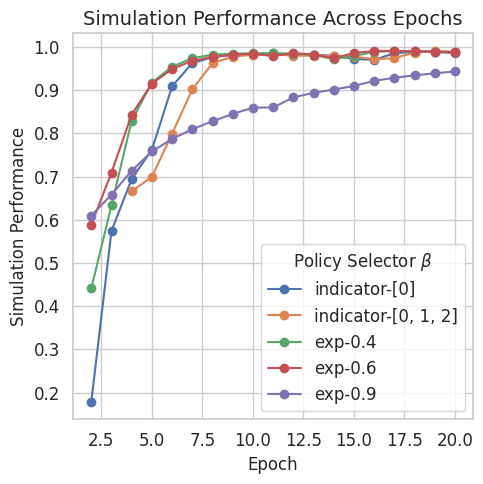

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure that seaborn's style is set for better aesthetics
sns.set_theme(style=style_theme)

# Plot each row of the DataFrame as a line
# plt.figure(figsize=(8, 5))
plt.figure(figsize=(5, 5))

for index, row in epoch_reward_df.iterrows():
    plt.plot(epoch_reward_df.columns, row, marker='o', label=index)

# Customize the plot for the scientific report
plt.title('Simulation Performance Across Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Simulation Performance', fontsize=12)
plt.legend(title=r'Policy Selector $\beta$', fontsize=12, title_fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Save the plot if needed
plt.savefig("thesis image/9/smallactivationFuncReward.pdf", bbox_inches='tight')

# Show the plot
plt.show()

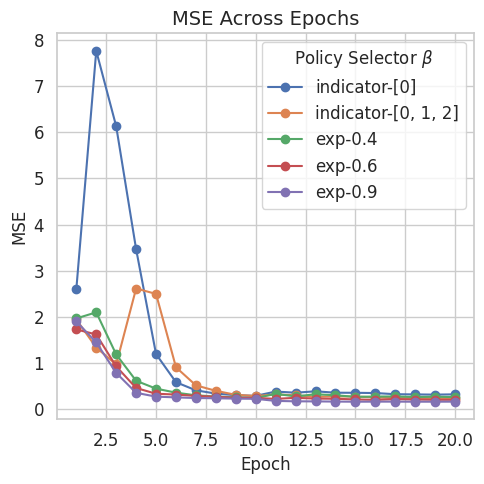

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure that seaborn's style is set for better aesthetics
sns.set_theme(style=style_theme)

# Plot each row of the DataFrame as a line
# plt.figure(figsize=(8, 5))
plt.figure(figsize=(5, 5))

for index, row in epoch_MSE_df.iterrows():
    plt.plot(epoch_MSE_df.columns, row, marker='o', label=index)

# Customize the plot for the scientific report
plt.title('MSE Across Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.legend(title=r'Policy Selector $\beta$', fontsize=12, title_fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Save the plot if needed
plt.savefig("thesis image/9/smallactivationFuncMSE.pdf", bbox_inches='tight')

# Show the plot
plt.show()

## Minibatch Size

In [59]:
import os
import json
import pandas as pd

epochs = torch.arange(20)+1

# Specify the full path to the directory
path = "/home/baptiste/Downloads/Activation func data/H5 - dis dis - exp0.6"


experiment = []
short_experiment = []
simulation_performance = []

epoch_reward_df = pd.DataFrame(columns=list(range(1, 21)))
epoch_MSE_df = pd.DataFrame(columns=list(range(1, 21)))


for folder_name in os.listdir(path):
    full_path = os.path.join(path, folder_name)
    if os.path.isdir(full_path):
        print("Folder:", full_path)

        # Read data
        json_info_path = os.path.join(full_path, "info.json")
        json_data_path = os.path.join(full_path, "results.json")
        
        if os.path.isfile(json_info_path):
            with open(json_info_path, 'r') as json_file:
                info_dict = json.load(json_file)  # Load JSON data into a Python dictionary
                # print("JSON data:", info_dict)  # You can process the dictionary as needed
        if os.path.isfile(json_data_path):
            with open(json_data_path, 'r') as json_file:
                data_dict = json.load(json_file)  # Load JSON data into a Python dictionary
                # print("JSON data:", data_dict)  # You can process the dictionary as needed


        experiment_name = f"H{info_dict['prediction_horizon_step']}-MB{info_dict['minibatach size']}-{info_dict['p_typeAction']}-{info_dict['F_typeAction']}-{info_dict['Activation function']['type']}-{info_dict['Activation function']['param']}"
        print(experiment_name)
        short_experiment_name = f"{info_dict['minibatach size']}"
        print(short_experiment_name)

        sim_perf = (data_dict['Epoch_Reward']['epoch_reward_stud'] - data_dict['untrained_stud_Epoch_Reward']['epoch_reward_untrained_stud']) / (data_dict['Epoch_Reward']['epoch_reward_test'] - data_dict['untrained_stud_Epoch_Reward']['epoch_reward_untrained_stud'])
        # sim_perf = (data_dict['Epoch_Reward']['epoch_reward_stud']) 
        print('Sim perf :',sim_perf)

        exp_MSE = data_dict['mse_encoded_action']['Total']
        print('MSE :',exp_MSE)
        # print('MSE discrete :', data_dict['mse_discrete_action']['Total'])

        experiment.append(experiment_name)
        short_experiment.append(short_experiment_name)
        simulation_performance.append(sim_perf)


        reward_data = pd.read_csv(os.path.join(full_path, "average_epoch_reward.csv"), header=None).values.flatten()
        epoch_reward_df.loc[short_experiment_name] = reward_data

        MSE_data = pd.read_csv(os.path.join(full_path, "epoch_mse_test_loss.csv"), header=None).values[:,-1].flatten()
        epoch_MSE_df.loc[short_experiment_name] = MSE_data

        print()

new_order_positions = [3,2,0,1,4]
# Reorder the DataFrame rows
epoch_reward_df = epoch_reward_df.iloc[new_order_positions]
epoch_MSE_df = epoch_MSE_df.iloc[new_order_positions]


reward_max = epoch_reward_df.max().max()
reward_min = epoch_reward_df.min().min()
print()
print(reward_max)
print(reward_min)


# rescale epoch reward
epoch_reward_df = (epoch_reward_df - reward_min + 100) / (reward_max - reward_min + 105)
epoch_reward_df

epoch_MSE_df


Folder: /home/baptiste/Downloads/Activation func data/H5 - dis dis - exp0.6/experiment73
H5-MB256-discrete-discrete-exp-0.6
256
Sim perf : 0.9779033096086479
MSE : 0.2764083743095398

Folder: /home/baptiste/Downloads/Activation func data/H5 - dis dis - exp0.6/experiment103
H5-MB512-discrete-discrete-exp-0.6
512
Sim perf : 0.9488988092222366
MSE : 0.34439563751220703

Folder: /home/baptiste/Downloads/Activation func data/H5 - dis dis - exp0.6/experiment43
H5-MB128-discrete-discrete-exp-0.6
128
Sim perf : 0.9868407791629995
MSE : 0.253457248210907

Folder: /home/baptiste/Downloads/Activation func data/H5 - dis dis - exp0.6/experiment13
H5-MB64-discrete-discrete-exp-0.6
64
Sim perf : 0.9853899942162242
MSE : 0.20483379065990448

Folder: /home/baptiste/Downloads/Activation func data/H5 - dis dis - exp0.6/experiment133
H5-MB1024-discrete-discrete-exp-0.6
1024
Sim perf : 0.8960876413138359
MSE : 0.4876459836959839


189.951213
-124.842751


1         2         3         4         5         6         7   \
64    1.729125  1.620047  0.929538  0.461015  0.336581  0.318466  0.289241   
128   2.533390  1.905739  0.964814  0.501784  0.428942  0.348866  0.300841   
256   2.389279  2.455513  1.083419  0.612651  0.502619  0.415676  0.365194   
512   2.605401  2.912324  1.417843  0.972539  0.828262  0.666668  0.551651   
1024  3.432146  2.553432  2.116116  1.597777  1.326440  1.289190  1.076628   

            8         9         10        11        12        13        14  \
64    0.270877  0.249217  0.244912  0.225816  0.248108  0.231842  0.227599   
128   0.292489  0.266712  0.260148  0.307607  0.273739  0.308224  0.280392   
256   0.343067  0.326946  0.320098  0.310678  0.306561  0.300674  0.291144   
512   0.451121  0.421221  0.385069  0.373796  0.362622  0.367101  0.367508   
1024  0.927312  0.793101  0.659249  0.535030  0.516593  0.504455  0.499964   

            15        16        17        18        19        20  
64    0.213515  0.203798  0.220032  0.211497  0.205717  0.204834  
128   0.272660  0.272828  0.259704  0.260179  0.257591  0.253457  
256   0.282268  0.276500  0.281164  0.279016  0.276180  0.276408  
512   0.359683  0.353712  0.350076  0.346507  0.345502  0.344396  
1024  0.494778  0.494415  0.492419  0.491204  0.488708  0.487646

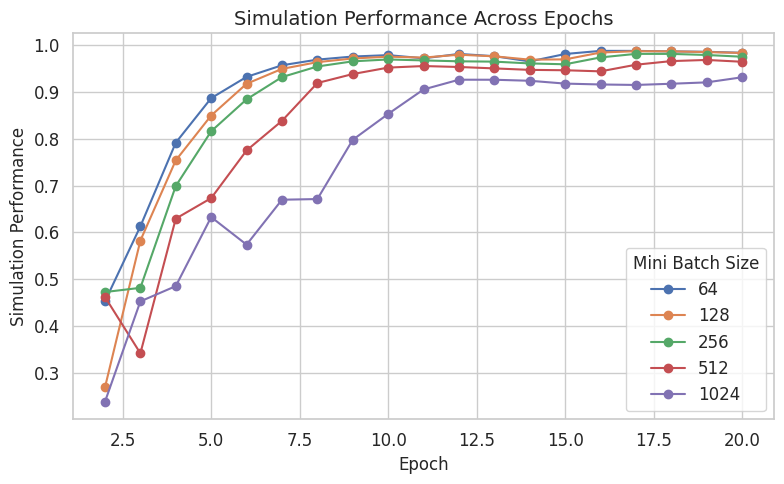

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure that seaborn's style is set for better aesthetics
sns.set_theme(style=style_theme)

# Plot each row of the DataFrame as a line
plt.figure(figsize=(8, 5))

for index, row in epoch_reward_df.iterrows():
    plt.plot(epoch_reward_df.columns, row, marker='o', label=index)

# Customize the plot for the scientific report
plt.title('Simulation Performance Across Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Simulation Performance', fontsize=12)
plt.legend(title=r'Mini Batch Size', fontsize=12, title_fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Save the plot if needed
plt.savefig("thesis image/9/batchSizeReward.pdf", bbox_inches='tight')

# Show the plot
plt.show()

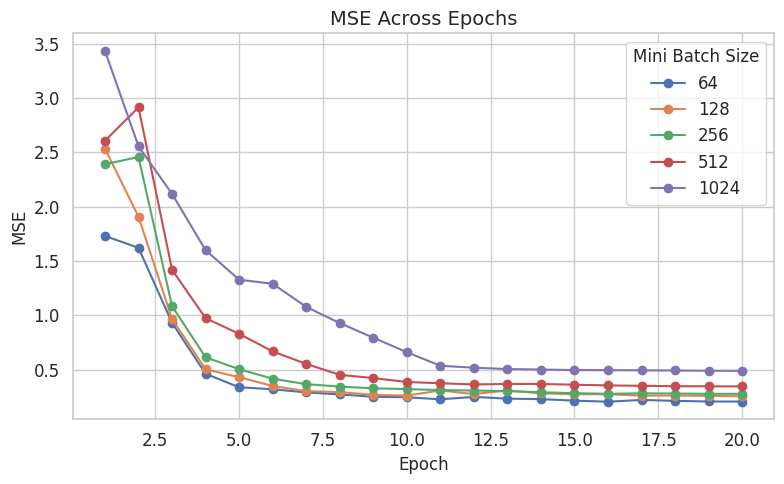

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure that seaborn's style is set for better aesthetics
sns.set_theme(style=style_theme)

# Plot each row of the DataFrame as a line
plt.figure(figsize=(8, 5))

for index, row in epoch_MSE_df.iterrows():
    plt.plot(epoch_MSE_df.columns, row, marker='o', label=index)

# Customize the plot for the scientific report
plt.title('MSE Across Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.legend(title=r'Mini Batch Size', fontsize=12, title_fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Save the plot if needed
plt.savefig("thesis image/9/batchSizeMSE.pdf", bbox_inches='tight')

# Show the plot
plt.show()

# Naive VS Dagger

In [151]:
import os
import json
import pandas as pd

epochs = torch.arange(20)+1

# Specify the full path to the directory
path = "/home/baptiste/Downloads/dagger_eval_contact_aligned_naive_vs_dagger"


experiment = []
short_experiment = []
simulation_performance = []
epoch_MSE = []

epoch_reward_df = pd.DataFrame(columns=list(range(1, 21)))
epoch_MSE_df = pd.DataFrame(columns=list(range(1, 21)))


for folder_name in os.listdir(path):
    full_path = os.path.join(path, folder_name)
    if os.path.isdir(full_path):
        print("Folder:", full_path)

        # Read data
        json_info_path = os.path.join(full_path, "info.json")
        json_data_path = os.path.join(full_path, "results.json")
        
        if os.path.isfile(json_info_path):
            with open(json_info_path, 'r') as json_file:
                info_dict = json.load(json_file)  # Load JSON data into a Python dictionary
                # print("JSON data:", info_dict)  # You can process the dictionary as needed
        if os.path.isfile(json_data_path):
            with open(json_data_path, 'r') as json_file:
                data_dict = json.load(json_file)  # Load JSON data into a Python dictionary
                # print("JSON data:", data_dict)  # You can process the dictionary as needed


        experiment_name = f"H{info_dict['prediction_horizon_step']}-MB{info_dict['minibatach size']}-{info_dict['p_typeAction']}-{info_dict['F_typeAction']}-{info_dict['Activation function']['type']}-{info_dict['Activation function']['param']}"
        print(experiment_name)

        if info_dict['Activation function']['type'] == 'indicator':
            name = "Naive"
        else :
            name = "DAgger"
        short_experiment_name = f"{name} : {info_dict['p_typeAction']}-{info_dict['F_typeAction']}"
        print(short_experiment_name)

        sim_perf = (data_dict['Epoch_Reward']['epoch_reward_stud'] - data_dict['untrained_stud_Epoch_Reward']['epoch_reward_untrained_stud']) / (data_dict['Epoch_Reward']['epoch_reward_test'] - data_dict['untrained_stud_Epoch_Reward']['epoch_reward_untrained_stud'])
        # sim_perf = (data_dict['Epoch_Reward']['epoch_reward_stud']) 
        print('Sim perf :',sim_perf)

        exp_MSE = data_dict['mse_encoded_action']['Total']
        print('MSE :',exp_MSE)
        # print('MSE discrete :', data_dict['mse_discrete_action']['Total'])

        experiment.append(experiment_name)
        short_experiment.append(short_experiment_name)
        simulation_performance.append(sim_perf)
        epoch_MSE.append(exp_MSE)


        reward_data = pd.read_csv(os.path.join(full_path, "average_epoch_reward.csv"), header=None).values.flatten()
        epoch_reward_df.loc[short_experiment_name] = reward_data

        MSE_data = pd.read_csv(os.path.join(full_path, "epoch_mse_test_loss.csv"), header=None).values[:,-1].flatten()
        epoch_MSE_df.loc[short_experiment_name] = MSE_data
        
        print()


# new_order_positions = [2, 1, 0, 3, 4]
# # Reorder the DataFrame rows
# epoch_reward_df = epoch_reward_df.iloc[new_order_positions]
# epoch_MSE_df = epoch_MSE_df.iloc[new_order_positions]


reward_max = epoch_reward_df.max().max()
reward_min = epoch_reward_df.min().min()
print()
print(reward_max)
print(reward_min)


# rescale epoch reward
epoch_reward_df = (epoch_reward_df - reward_min + 100) / (reward_max - reward_min + 105)
# epoch_reward_df

# epoch_MSE_df
# epoch_reward_df


Folder: /home/baptiste/Downloads/dagger_eval_contact_aligned_naive_vs_dagger/experiment1
H5-MB64-discrete-discrete-exp-0.6
DAgger : discrete-discrete
Sim perf : 0.9891489036552464
MSE : 0.21850204467773438

Folder: /home/baptiste/Downloads/dagger_eval_contact_aligned_naive_vs_dagger/experiment2
H5-MB64-first-spline-exp-0.6
DAgger : first-spline
Sim perf : 0.9930403105874315
MSE : 0.1870138943195343

Folder: /home/baptiste/Downloads/dagger_eval_contact_aligned_naive_vs_dagger/experiment3
H5-MB64-discrete-discrete-indicator-[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Naive : discrete-discrete
Sim perf : 0.6849226786899766
MSE : 0.15462759137153625

Folder: /home/baptiste/Downloads/dagger_eval_contact_aligned_naive_vs_dagger/experiment4
H5-MB64-first-spline-indicator-[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Naive : first-spline
Sim perf : 0.5562720777991041
MSE : 0.1613275110721588


191.064917
-71.950897


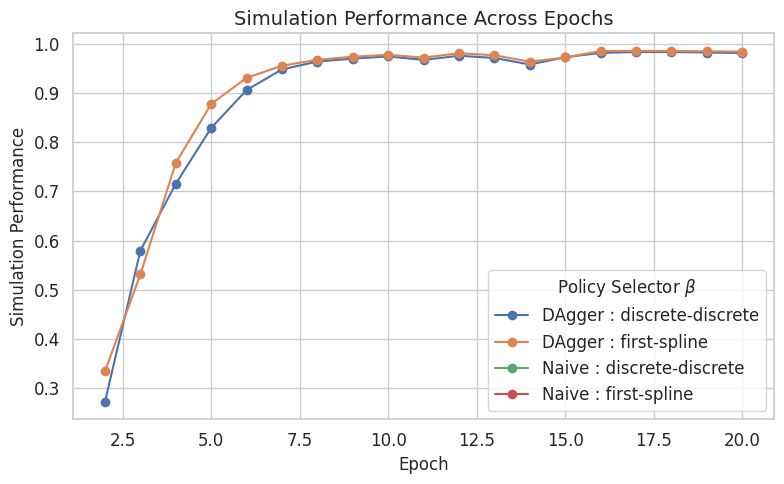

In [152]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure that seaborn's style is set for better aesthetics
sns.set_theme(style=style_theme)

# Plot each row of the DataFrame as a line
plt.figure(figsize=(8, 5))

for index, row in epoch_reward_df.iterrows():
    plt.plot(epoch_reward_df.columns, row, marker='o', label=index)

# Customize the plot for the scientific report
plt.title('Simulation Performance Across Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Simulation Performance', fontsize=12)
plt.legend(title=r'Policy Selector $\beta$', fontsize=12, title_fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Save the plot if needed
plt.savefig("thesis image/9/DaggervsNaiceReward.pdf", bbox_inches='tight')

# Show the plot
plt.show()

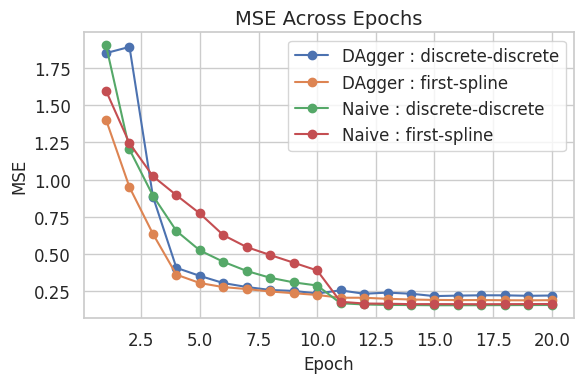

In [161]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure that seaborn's style is set for better aesthetics
sns.set_theme(style=style_theme)

# Plot each row of the DataFrame as a line
plt.figure(figsize=(6, 4))

for index, row in epoch_MSE_df.iterrows():
    plt.plot(epoch_MSE_df.columns, row, marker='o', label=index)

# Customize the plot for the scientific report
plt.title('MSE Across Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE', fontsize=12)
# plt.legend(title=r'Algorithm', fontsize=12, title_fontsize=12)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Save the plot if needed
plt.savefig("thesis image/9/DaggervsNaiveMSE.pdf", bbox_inches='tight')

# Show the plot
plt.show()

# Full Evalutation across Encodings

In [613]:
import os
import json
import pandas as pd
import torch

epochs = torch.arange(20)+1

# Specify the full path to the directory
path1 = "/home/baptiste/Downloads/results_dagger_full_eval_base_task/dagger/dagger_eval_contact_aligned_full_eval"
path2 = "/home/baptiste/Downloads/results_dagger_full_eval_base_task/dagger/dagger_eval_contact_aligned_full_eval2"


experiment = []
short_experiment = []
simulation_performance = []
epoch_MSE = []

epoch_reward_df = pd.DataFrame(columns=list(range(1, 21)))
epoch_MSE_df = pd.DataFrame(columns=list(range(1, 21)))


multi_columns = pd.MultiIndex.from_product([
    ['mse_first_action', 'mse_discrete_action', 'mse_encoded_action'], 
    ['f', 'd', 'p', 'F', 'Total']
])
result_df = pd.DataFrame(columns=multi_columns)


for path in [path1, path2]:
    for folder_name in os.listdir(path):
        full_path = os.path.join(path, folder_name)
        if os.path.isdir(full_path):
            print("Folder:", full_path)

            # Read data
            json_info_path = os.path.join(full_path, "info.json")
            json_data_path = os.path.join(full_path, "results.json")
            
            if os.path.isfile(json_info_path):
                with open(json_info_path, 'r') as json_file:
                    info_dict = json.load(json_file)  # Load JSON data into a Python dictionary
                    # print("JSON data:", info_dict)  # You can process the dictionary as needed
            if os.path.isfile(json_data_path):
                with open(json_data_path, 'r') as json_file:
                    data_dict = json.load(json_file)  # Load JSON data into a Python dictionary
                    # print("JSON data:", data_dict)  # You can process the dictionary as needed


            experiment_name = f"H{info_dict['prediction_horizon_step']}-dt{info_dict['prediction_horizon_time'][0:4]}-MB{info_dict['minibatach size']}-{info_dict['p_typeAction']}-{info_dict['F_typeAction']}-{info_dict['Activation function']['type']}-{info_dict['Activation function']['param']}"
            print(experiment_name)


            short_experiment_name = f"H{info_dict['prediction_horizon_step']}-dt{info_dict['prediction_horizon_time'][0:4]}-{info_dict['p_typeAction']}-{info_dict['F_typeAction']}"
            print(short_experiment_name)

            sim_perf = (data_dict['Epoch_Reward']['epoch_reward_stud'] - data_dict['untrained_stud_Epoch_Reward']['epoch_reward_untrained_stud']) / (data_dict['Epoch_Reward']['epoch_reward_test'] - data_dict['untrained_stud_Epoch_Reward']['epoch_reward_untrained_stud'])
            # sim_perf = (data_dict['Epoch_Reward']['epoch_reward_stud']) 
            print('Sim perf :',sim_perf)

            exp_MSE = data_dict['mse_encoded_action']['Total']
            print('MSE :',exp_MSE)
            # print('MSE discrete :', data_dict['mse_discrete_action']['Total'])

            experiment.append(experiment_name)
            short_experiment.append(short_experiment_name)
            simulation_performance.append(sim_perf)
            epoch_MSE.append(exp_MSE)


            reward_data = pd.read_csv(os.path.join(full_path, "average_epoch_reward.csv"), header=None).values.flatten()
            epoch_reward_df.loc[short_experiment_name] = reward_data

            MSE_data = pd.read_csv(os.path.join(full_path, "epoch_mse_test_loss.csv"), header=None).values[:,-1].flatten()
            epoch_MSE_df.loc[short_experiment_name] = MSE_data


            # Extract relevant data from the JSON
            row_data = {
                ('mse_first_action', 'f'): data_dict['mse_first_action']['f'],
                ('mse_first_action', 'd'): data_dict['mse_first_action']['d'],
                ('mse_first_action', 'p'): data_dict['mse_first_action']['p'],
                ('mse_first_action', 'F'): data_dict['mse_first_action']['F'],
                ('mse_first_action', 'Total'): data_dict['mse_first_action']['Total'],
                
                ('mse_discrete_action', 'f'): data_dict['mse_discrete_action']['f'],
                ('mse_discrete_action', 'd'): data_dict['mse_discrete_action']['d'],
                ('mse_discrete_action', 'p'): data_dict['mse_discrete_action']['p'],
                ('mse_discrete_action', 'F'): data_dict['mse_discrete_action']['F'],
                ('mse_discrete_action', 'Total'): data_dict['mse_discrete_action']['Total'],
                
                ('mse_encoded_action', 'f'): data_dict['mse_encoded_action']['f'],
                ('mse_encoded_action', 'd'): data_dict['mse_encoded_action']['d'],
                ('mse_encoded_action', 'p'): data_dict['mse_encoded_action']['p'],
                ('mse_encoded_action', 'F'): data_dict['mse_encoded_action']['F'],
                ('mse_encoded_action', 'Total'): data_dict['mse_encoded_action']['Total'],

                # 'reward' : sim_perf,
            }

            result_df.loc[short_experiment_name] = pd.Series(row_data)
            result_df.loc[short_experiment_name,'Dimension'] = info_dict['Output_size']
            result_df.loc[short_experiment_name,'reward'] = data_dict['Epoch_Reward']['epoch_reward_test']
            result_df.loc[short_experiment_name,'scaled reward'] = 100*sim_perf
            
            print()


# new_order_positions = [2, 1, 0, 3, 4]
# # Reorder the DataFrame rows
# epoch_reward_df = epoch_reward_df.iloc[new_order_positions]
# epoch_MSE_df = epoch_MSE_df.iloc[new_order_positions]


reward_max = epoch_reward_df.max().max()
reward_min = epoch_reward_df.min().min()
print()
print(reward_max)
print(reward_min)


# rescale epoch reward
# epoch_reward_df = (epoch_reward_df - reward_min + 100) / (reward_max - reward_min + 105)
# epoch_reward_df

# epoch_MSE_df
# epoch_reward_df


FileNotFoundError: [Errno 2] No such file or directory: '/home/baptiste/Downloads/results_dagger_full_eval_base_task/dagger/dagger_eval_contact_aligned_full_eval'

In [ ]:
epoch_reward_df

In [ ]:
display(result_df.sort_values(by='scaled reward'))

In [112]:
df = result_df

def parse_index(index_str):
    h, dt, encodingP, encodingF = index_str.split('-')
    h_value = int(h[1:])  # Extract the number from H (e.g., H15 -> 15)
    dt_value = float(dt[2:])  # Extract the number from dt (e.g., dt0.04 -> 0.04)
    return h_value, dt_value, encodingP, encodingF

# Apply the parsing function to create separate columns
df[['H', 'dt', 'encodingP', 'encodingF']] = df.index.to_series().apply(parse_index).apply(pd.Series)


# Step 2: Set the MultiIndex
df.set_index(['dt', 'H', 'encodingP', 'encodingF'], inplace=True)

# Step 3: Sort the DataFrame by dt first, then by H
df.sort_index(level=['dt', 'H'], inplace=True)

display(df)

mse_first_action                                \
                                           f         d         p         F   
dt   H  encodingP encodingF                                                  
0.02 5  discrete  discrete          0.008919  0.034634  0.034517  0.030903   
                  spline            0.009377  0.034971  0.035089  0.031998   
        first     discrete          0.007803  0.020633  0.021737  0.021591   
                  spline            0.007143  0.018754  0.020568  0.019723   
        spline    discrete          0.008837  0.029491  0.030683  0.029826   
                  spline            0.007789  0.025380  0.027477  0.026246   
     10 discrete  discrete          0.012520  0.075962  0.075591  0.068574   
                  spline            0.013791  0.066330  0.071333  0.090137   
        first     discrete          0.010212  0.041085  0.041916  0.040617   
                  spline            0.010049  0.035249  0.034789  0.061048   
        spline    discrete          0.013599  0.072609  0.153057  0.063370   
                  spline            0.012726  0.060921  0.145906  0.085272   
     15 discrete  discrete          0.018411  0.121788  0.117390  0.097188   
                  spline            0.017564  0.102039  0.111437  0.208304   
        first     discrete          0.012192  0.069131  0.069487  0.060035   
                  spline            0.012156  0.049449  0.056396  0.163549   
        spline    discrete          0.017892  0.126349  0.821107  0.105362   
                  spline            0.016862  0.104264  0.788095  0.205665   
0.04 5  discrete  discrete          0.010105  0.042410  0.044632  0.039599   
                  spline            0.011203  0.047456  0.052571  0.042400   
        first     discrete          0.008223  0.024804  0.026132  0.026444   
                  spline            0.008986  0.028300  0.030149  0.029633   
        spline    discrete          0.010301  0.045187  0.044718  0.040219   
                  spline            0.013075  0.051167  0.055234  0.048526   
     10 discrete  discrete          0.015160  0.106387  0.102606  0.080855   
                  spline            0.015961  0.082462  0.098826  0.161713   
        first     discrete          0.011899  0.053732  0.049712  0.048211   
                  spline            0.010981  0.039308  0.044311  0.131628   
        spline    discrete          0.018619  0.105616  0.677458  0.092035   
                  spline            0.020318  0.098860  0.665307  0.164644   
     15 discrete  discrete          0.019437  0.131450  0.125792  0.113165   
                  spline            0.021206  0.129054  0.124624  0.385817   
        first     discrete          0.012462  0.060859  0.063828  0.055202   
                  spline            0.012726  0.051219  0.057940  0.331764   
        spline    discrete          0.023359  0.183145  2.560268  0.141942   
                  spline            0.024835  0.171115  2.530354  0.372449   

                                      mse_discrete_action            \
                                Total                   f         d   
dt   H  encodingP encodingF                                           
0.02 5  discrete  discrete   0.029328            0.008919  0.034634   
                  spline     0.030074            0.009377  0.034971   
        first     discrete   0.019526            0.007803  0.020633   
                  spline     0.018029            0.007143  0.018754   
        spline    discrete   0.027024            0.008837  0.029491   
                  spline     0.023837            0.007789  0.025380   
     10 discrete  discrete   0.063627            0.012520  0.075962   
                  spline     0.070457            0.013791  0.066330   
        first     discrete   0.036711            0.010212  0.041085   
                  spline     0.042574            0.010049  0.035249   
        spline    discrete   0.083204            0.013599  0.0

In [ ]:
result_df

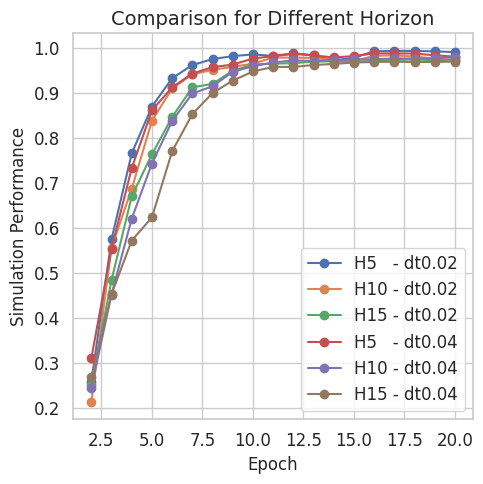

In [114]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure that seaborn's style is set for better aesthetics
sns.set_theme(style=style_theme)

# Plot each row of the DataFrame as a line
plt.figure(figsize=(5, 5))
# plt.figure(figsize=(18, 12))

# for index, row in epoch_reward_df.iterrows():
#     print(index)
#     if "first-spline" in index or "discrete-discrete" in index:
#         if "0.02" in index:
#             y = (row + 110)/303
#             plt.plot(epoch_reward_df.columns, y, marker='o', label=index)

index =  ['H5-dt0.02-discrete-discrete', 'H10-dt0.02-discrete-discrete', 'H15-dt0.02-discrete-discrete']#,'H5-dt0.02-first-spline', 'H10-dt0.02-first-spline', 'H15-dt0.02-first-spline']
label =  ['H5   - dt0.02', 'H10 - dt0.02', 'H15 - dt0.02']#,'H5   - first-spline', 'H10 - first-spline', 'H15 - first-spline']

for i in range(len(index)):
        # print()
        # print(index[i])
        # print(result_df.loc[index[i], 'scaled reward'].values)
        y = (epoch_reward_df.loc[index[i]]+210)/403
        # print(y[20])
        plt.plot(epoch_reward_df.columns, y, marker='o', label=label[i])

index =  ['H5-dt0.04-discrete-discrete', 'H10-dt0.04-discrete-discrete', 'H15-dt0.04-discrete-discrete']#,'H5-dt0.04-first-spline', 'H10-dt0.04-first-spline', 'H15-dt0.04-first-spline']
label =  ['H5   - dt0.04', 'H10 - dt0.04', 'H15 - dt0.04']#,'H5   - first-spline', 'H10 - first-spline', 'H15 - first-spline']

for i in range(len(index)):
        # print()
        # print(index[i])
        # print(result_df.loc[index[i], 'scaled reward'].values)
        y = (epoch_reward_df.loc[index[i]]+350)/735
        # print(y[20])
        plt.plot(epoch_reward_df.columns, y, marker='o', label=label[i])

# Customize the plot for the scientific report
plt.title('Comparison for Different Horizon', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Simulation Performance', fontsize=12)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Save the plot if needed
plt.savefig("thesis image/9/simPerf_diff_H.pdf", bbox_inches='tight')

# Show the plot
plt.show()

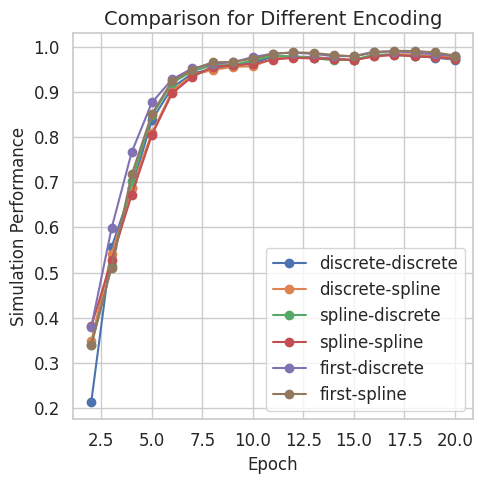

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure that seaborn's style is set for better aesthetics
sns.set_theme(style=style_theme)

# Plot each row of the DataFrame as a line
plt.figure(figsize=(5, 5))
# plt.figure(figsize=(18, 12))

# for index, row in epoch_reward_df.iterrows():
#     print(index)
#     # if "first-spline" in index or "discrete-discrete" in index:
#     if "H10-dt0.02" in index:
#             y = (row + 110)/303
#             plt.plot(epoch_reward_df.columns, y, marker='o', label=index)

index =  ['H10-dt0.02-discrete-discrete', 'H10-dt0.02-discrete-spline', 'H10-dt0.02-spline-discrete','H10-dt0.02-spline-spline', 'H10-dt0.02-first-discrete', 'H10-dt0.02-first-spline']
label =  ['discrete-discrete', 'discrete-spline', 'spline-discrete', 'spline-spline', 'first-discrete', 'first-spline']

for i in range(len(index)):
        y = (epoch_reward_df.loc[index[i]] + 210)/403
        plt.plot(epoch_reward_df.columns, y, marker='o', label=label[i])

# Customize the plot for the scientific report
plt.title('Comparison for Different Encoding', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Simulation Performance', fontsize=12)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Save the plot if needed
plt.savefig("thesis image/9/simPerf_diff_Encoding.pdf", bbox_inches='tight')

# Show the plot
plt.show()

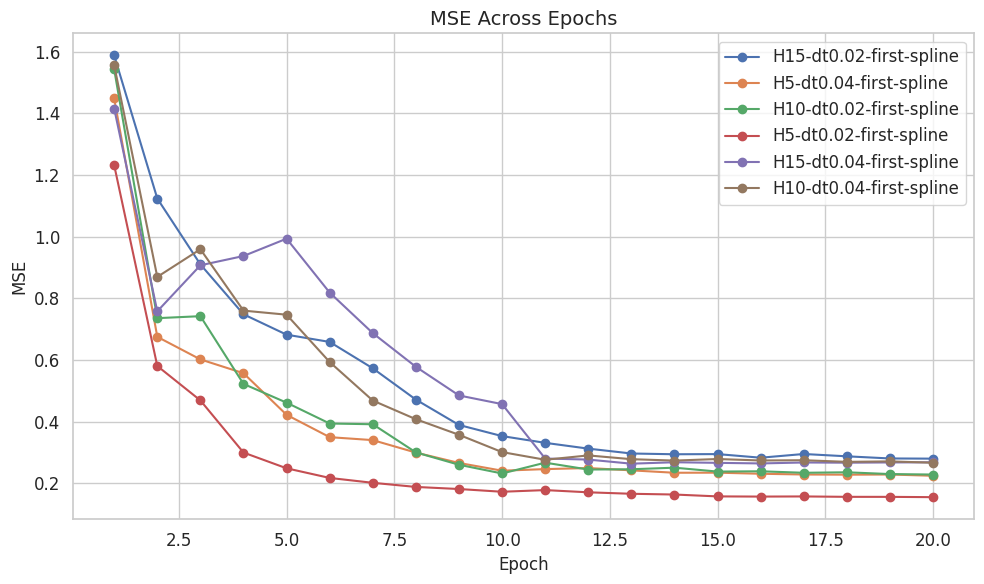

In [116]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure that seaborn's style is set for better aesthetics
sns.set_theme(style=style_theme)

# Plot each row of the DataFrame as a line
plt.figure(figsize=(10, 6))

for index, row in epoch_MSE_df.iterrows():
    if "first-spline" in index :#or "first-discrete" in index:
        plt.plot(epoch_MSE_df.columns, row, marker='o', label=index)

# Customize the plot for the scientific report
plt.title('MSE Across Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE', fontsize=12)
# plt.legend(title=r'Algorithm', fontsize=12, title_fontsize=12)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Save the plot if needed
plt.savefig("thesis image/9/DaggervsNaiveMSE.pdf", bbox_inches='tight')

# Show the plot
plt.show()

In [117]:
import os
import json
import pandas as pd
import torch

# Specify the full path to the directory
path1 = "/home/baptiste/Downloads/results_dagger_full_eval_base_task/eval/dagger_eval_contact_aligned_full_eval_sampCost"
path2 = "/home/baptiste/Downloads/results_dagger_full_eval_base_task/eval/dagger_eval_contact_aligned_full_eval_sampCost2"

json_info_path1 = os.path.join(path1, "info.json")
json_info_path2 = os.path.join(path2, "info.json")
if os.path.isfile(json_info_path1):
    with open(json_info_path1, 'r') as json_file:
        info1_dict = json.load(json_file)  # Load JSON data into a Python dictionary
if os.path.isfile(json_info_path2):
    with open(json_info_path2, 'r') as json_file:
        info2_dict = json.load(json_file)  # Load JSON data into a Python dictionary
info_dict = {**info1_dict, **info2_dict}

df = pd.DataFrame(info_dict).T 


# Step 2: Parse the index to create MultiIndex
df.index = df.index.str.split('-').map(lambda x: (x[2], x[3], x[0], x[1]))  # Reorder as needed
df.index = pd.MultiIndex.from_tuples(df.index, names=["H", "dt", "encodingP", "encodingF"])

# Step 3: Sort the DataFrame by the MultiIndex
df = df.sort_index(level=["dt", "H"])

# Extract the numeric part of the 'H' level and convert it to an integer
h_numeric = df.index.get_level_values('H').map(lambda x: int(x[1:]))

# Divide 'sampling_cost_median_all' by the numeric part of 'H'
df['step_sampling_cost_median_all'] = df['sampling_cost_median_all'] / h_numeric

# Display the DataFrame
display(df)



rewards_median_all sampling_cost_median_all  \
H   dt   encodingP encodingF                                               
H10 dt02 discrete  discrete            0.044573              4405.479492   
                   spline              0.044242              4697.217285   
         first     discrete             0.04488              3965.626465   
                   spline              0.044798              4034.588867   
         spline    discrete            0.044576              4450.412598   
                   spline              0.044492              4279.882812   
H15 dt02 discrete  discrete            0.044154             17056.167969   
                   spline              0.044138             17003.671875   
         first     discrete            0.044699             17394.777344   
                   spline              0.044648             16702.007812   
         spline    discrete            0.043806             18934.308594   
                   spline              0.043489             19794.929688   
H5  dt02 discrete  discrete            0.044788               944.154175   
                   spline              0.044811                951.28772   
         first     discrete            0.045137               880.672852   
                   spline              0.045064               881.979065   
         spline    discrete             0.04502               936.163757   
                   spline              0.044876               984.588684   
H10 dt04 discrete  discrete            0.044395             27729.855469   
                   spline              0.044324             26399.660156   
         first     discrete            0.044928               33801.1875   
                   spline              0.044794              34957.71875   
         spline    discrete            0.044178             35092.292969   
                   spline              0.044167             36003.945312   
H15 dt04 discrete  discrete            0.044205                 374743.5   
                   spline              0.043443             476713.15625   
         first     discrete            0.044718               621315.625   
                   spline              0.044291                734597.75   
         spline    discrete            0.037133               1422522.75   
                   spline              0.039761               1781022.25   
H5  dt04 discrete  discrete            0.044812              2119.692383   
                   spline              0.044692              2207.054199   
         first     discrete            0.045087              1955.963623   
                   spline              0.044927              2088.513184   
         spline    discrete            0.044862              2057.154541   
                   spline              0.044635              2120.180664   

                                                              step_cost_results  \
H   dt   encodingP encodingF                                                      
H10 dt02 discrete  discrete   {'step_cost_mean': [278.6075134277344, 323.534...   
                   spline     {'step_cost_mean': [345.8993225097656, 405.567...   
         first     discrete   {'step_cost_mean': [231.40853881835938, 269.11...   
                   spline     {'step_cost_mean': [242.1888427734375, 287.128...   
         spline    discrete   {'step_cost_mean': [289.6379699707031, 338.000...   
                   spline     {'step_cost_mean': [273.2339172363281, 322.659...   
H15 dt02 discrete  discrete   {'step_cost_mean': [313.0076599121094, 335.640...   
                   spline     {'step_cost_mean': [321.70843505859375, 344.52...   
         first     discrete   {'step_cost_mean': [255.8956756591797, 275.338...   
                   spline     {'step_cost_mean': [263.328125, 279.2749633789...   
         spline    discrete   {'step_cost_mean': [327.9464111328125, 353.724...   
                   spline     {'step_cost_mean': [395.7330627

In [ ]:
# Specify the full path to the directory
path1 = "/home/baptiste/Downloads/results_dagger_full_eval_base_task/eval/dagger_eval_contact_aligned_full_eval_sampCost"
path2 = "/home/baptiste/Downloads/results_dagger_full_eval_base_task/eval/dagger_eval_contact_aligned_full_eval_sampCost2"

json_info_path1 = os.path.join(path1, "info.json")
json_info_path2 = os.path.join(path2, "info.json")
if os.path.isfile(json_info_path1):
    with open(json_info_path1, 'r') as json_file:
        info1_dict = json.load(json_file)  # Load JSON data into a Python dictionary
if os.path.isfile(json_info_path2):
    with open(json_info_path2, 'r') as json_file:
        info2_dict = json.load(json_file)  # Load JSON data into a Python dictionary
info_dict = {**info1_dict, **info2_dict}

# print(info_dict)

step_cost_df = pd.DataFrame(columns=range(15))
for key in info_dict : 
    step_cost_df.loc[key] = info_dict[key]['step_cost_results']['step_cost_mean']
    # print(info_dict[key]['step_cost_results'])

display(step_cost_df)

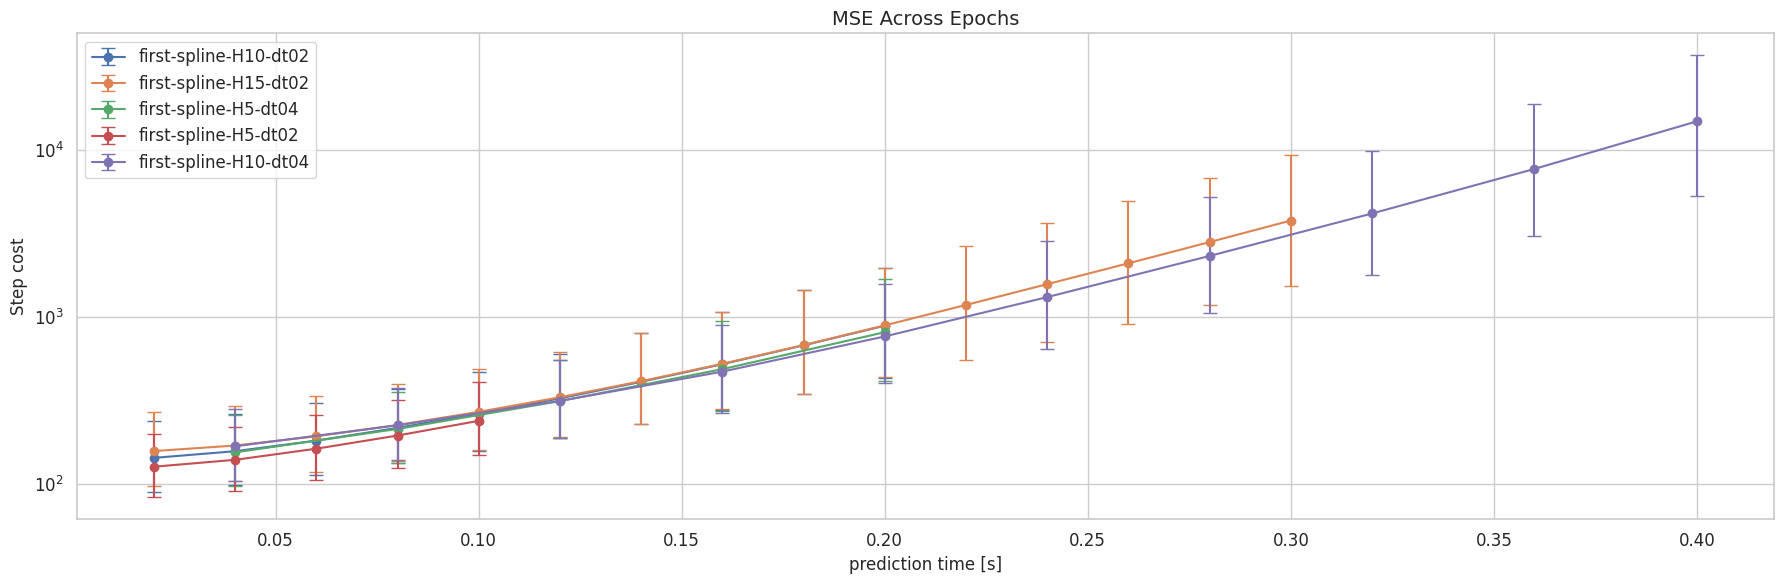

In [120]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme(style=style_theme)
plt.figure(figsize=(18, 6))


path1 = "/home/baptiste/Downloads/results_dagger_full_eval_base_task/eval/dagger_eval_contact_aligned_full_eval_sampCost"
path2 = "/home/baptiste/Downloads/results_dagger_full_eval_base_task/eval/dagger_eval_contact_aligned_full_eval_sampCost2"

json_info_path1 = os.path.join(path1, "info.json")
json_info_path2 = os.path.join(path2, "info.json")
if os.path.isfile(json_info_path1):
    with open(json_info_path1, 'r') as json_file:
        info1_dict = json.load(json_file)  # Load JSON data into a Python dictionary
if os.path.isfile(json_info_path2):
    with open(json_info_path2, 'r') as json_file:
        info2_dict = json.load(json_file)  # Load JSON data into a Python dictionary
info_dict = {**info1_dict, **info2_dict}



for key in info_dict : 
    if 'first-spline' in key and not 'H15-dt04' in key:
    # if 'H5' in key:
        # y = [0] + info_dict[key]['step_cost_results']['step_cost_median']
        y = np.array(info_dict[key]['step_cost_results']['step_cost_median'])

        q1 = np.array(info_dict[key]['step_cost_results']['step_costq1_values'])
        q3 = np.array(info_dict[key]['step_cost_results']['step_costq3_values'])
        yerr = [y - q1, q3 - y]

        if '02' in key:
            x = torch.arange(len(y))*0.02 + 0.02
        else :
            x = torch.arange(len(y))*0.04 + 0.04

        # plt.plot(x,y, marker='o', label=key)
        plt.errorbar(x, y, yerr=yerr, marker='o', label=key, capsize=5)


# Customize the plot for the scientific report
plt.title('MSE Across Epochs', fontsize=14)
plt.xlabel('prediction time [s]', fontsize=12)
plt.ylabel('Step cost', fontsize=12)
# plt.legend(title=r'Algorithm', fontsize=12, title_fontsize=12)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.yscale('log')
plt.tight_layout()

# Save the plot if needed
# plt.savefig("thesis image/9/DaggervsNaiveMSE.pdf", bbox_inches='tight')

# Show the plot
plt.show()

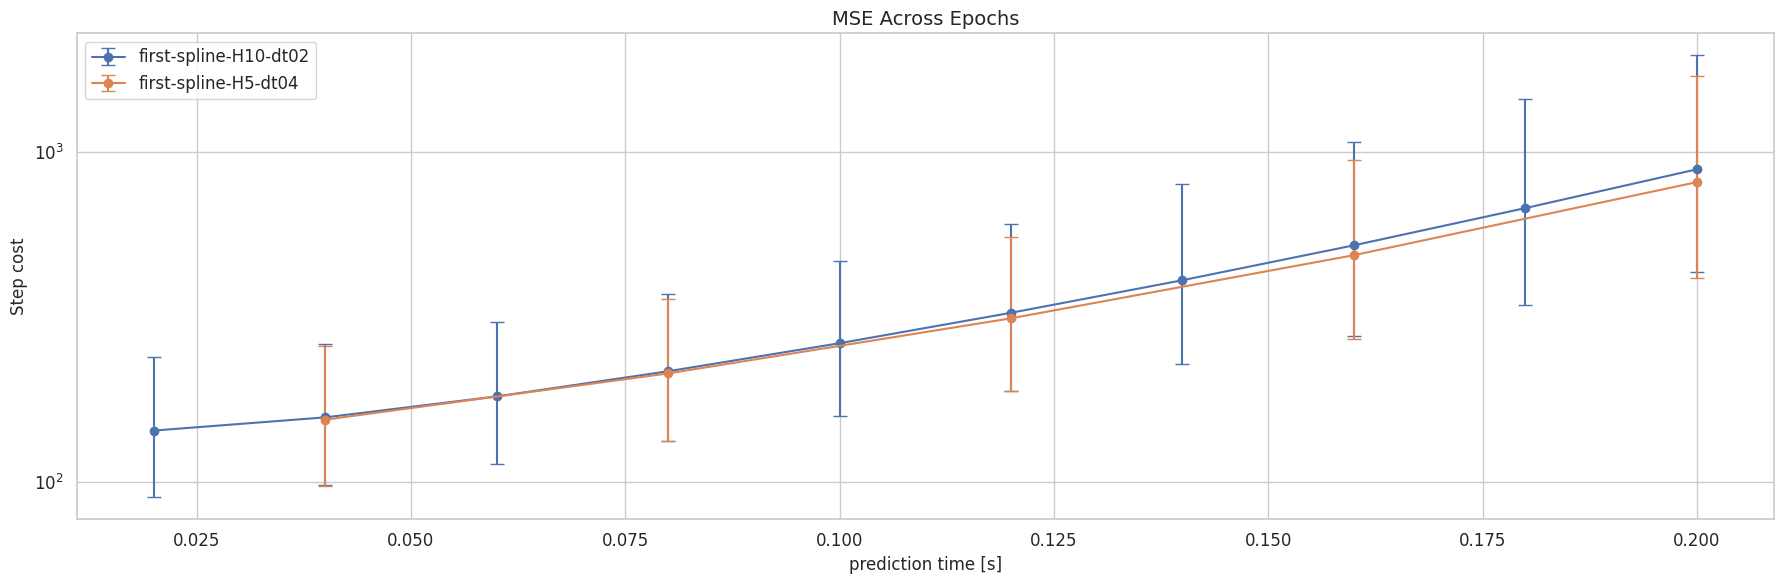

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme(style=style_theme)
plt.figure(figsize=(18, 6))


path1 = "/home/baptiste/Downloads/results_dagger_full_eval_base_task/eval/dagger_eval_contact_aligned_full_eval_sampCost"
path2 = "/home/baptiste/Downloads/results_dagger_full_eval_base_task/eval/dagger_eval_contact_aligned_full_eval_sampCost2"

json_info_path1 = os.path.join(path1, "info.json")
json_info_path2 = os.path.join(path2, "info.json")
if os.path.isfile(json_info_path1):
    with open(json_info_path1, 'r') as json_file:
        info1_dict = json.load(json_file)  # Load JSON data into a Python dictionary
if os.path.isfile(json_info_path2):
    with open(json_info_path2, 'r') as json_file:
        info2_dict = json.load(json_file)  # Load JSON data into a Python dictionary
info_dict = {**info1_dict, **info2_dict}



for key in info_dict : 
    if 'first-spline' in key and not 'H15-dt04' in key:
    # if 'H10' in key:
        # if 'first-discrete' in key or 'first-spline' in key :
        if 'first-spline-H5-dt04' in key or 'first-spline-H10-dt02' in key:
            # y = [0] + info_dict[key]['step_cost_results']['step_cost_median']
            y = np.array(info_dict[key]['step_cost_results']['step_cost_median'])

            q1 = np.array(info_dict[key]['step_cost_results']['step_costq1_values'])
            q3 = np.array(info_dict[key]['step_cost_results']['step_costq3_values'])
            yerr = [y - q1, q3 - y]

            if '02' in key:
                x = torch.arange(len(y))*0.02 + 0.02
            else :
                x = torch.arange(len(y))*0.04 + 0.04

            # plt.plot(x,y, marker='o', label=key)
            plt.errorbar(x, y, yerr=yerr, marker='o', label=key, capsize=5)


# Customize the plot for the scientific report
plt.title('MSE Across Epochs', fontsize=14)
plt.xlabel('prediction time [s]', fontsize=12)
plt.ylabel('Step cost', fontsize=12)
# plt.legend(title=r'Algorithm', fontsize=12, title_fontsize=12)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.yscale('log')
plt.tight_layout()

# Save the plot if needed
# plt.savefig("thesis image/9/DaggervsNaiveMSE.pdf", bbox_inches='tight')

# Show the plot
plt.show()

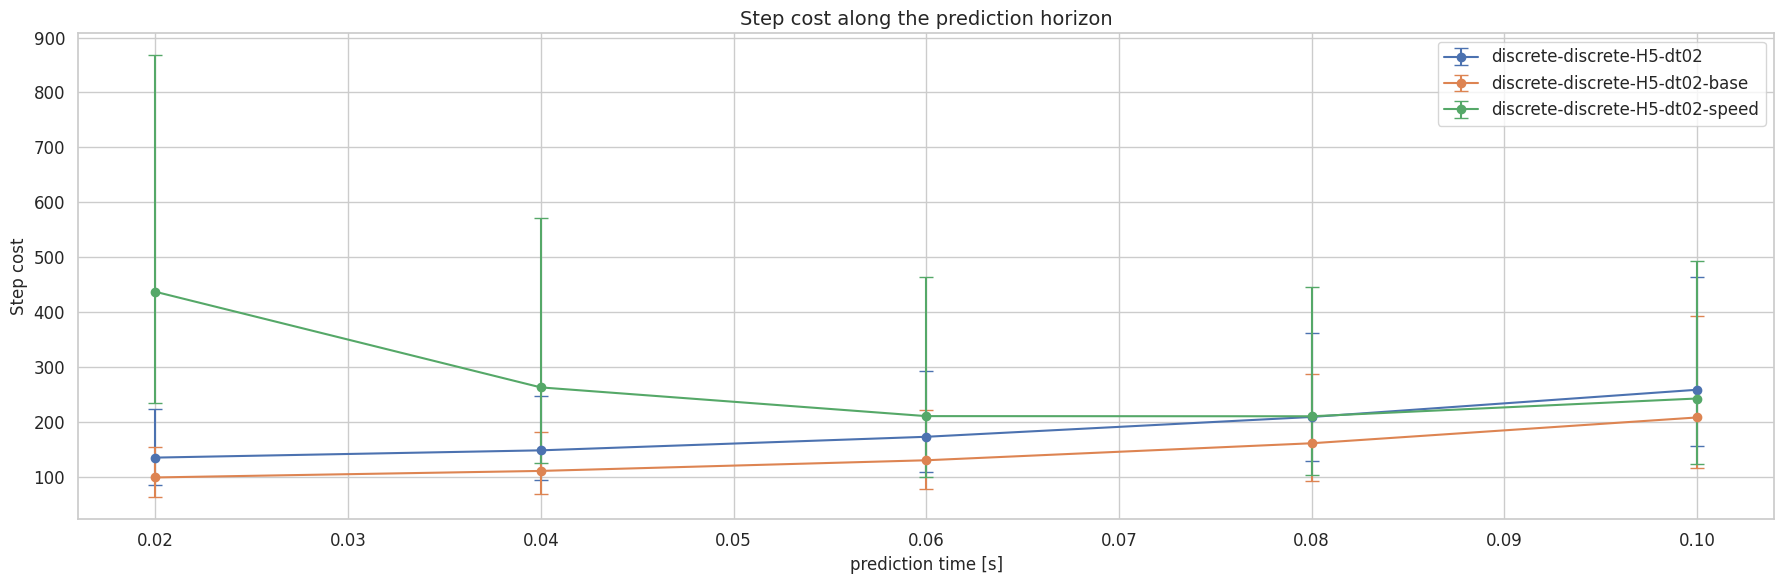

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import json
import torch

sns.set_theme(style=style_theme)
plt.figure(figsize=(18, 6))


path1 = "/home/baptiste/Downloads/results_dagger_full_eval_base_task/eval/dagger_eval_contact_aligned_full_eval_sampCost"
path2 = "/home/baptiste/Downloads/results_dagger_full_eval_base_task/eval/dagger_eval_contact_aligned_full_eval_sampCost2"
path3 = "/home/baptiste/Documents/dls_isaac_lab_bat_private/eval/samplingTrainer_Eval_H5_Dis_Dis"

json_info_path1 = os.path.join(path1, "info.json")
json_info_path2 = os.path.join(path2, "info.json")
json_info_path3 = os.path.join(path3, "info.json")
if os.path.isfile(json_info_path1):
    with open(json_info_path1, 'r') as json_file:
        info1_dict = json.load(json_file)  # Load JSON data into a Python dictionary
if os.path.isfile(json_info_path2):
    with open(json_info_path2, 'r') as json_file:
        info2_dict = json.load(json_file)  # Load JSON data into a Python dictionary
if os.path.isfile(json_info_path3):
    with open(json_info_path3, 'r') as json_file:
        info3_dict = json.load(json_file)  # Load JSON data into a Python dictionary
info_dict = {**info1_dict, **info2_dict, **info3_dict}



for key in info_dict : 
    # if 'first-spline' in key and not 'H15-dt04' in key:
    if 'H5-dt02' in key:
        if 'discrete-discrete' in key:
        # if 'first-discrete' in key or 'first-spline' in key :
        # if 'first-spline-H5-dt04' in key or 'first-spline-H10-dt02' in key:
            # y = [0] + info_dict[key]['step_cost_results']['step_cost_median']
            y = np.array(info_dict[key]['step_cost_results']['step_cost_median'])

            q1 = np.array(info_dict[key]['step_cost_results']['step_costq1_values'])
            q3 = np.array(info_dict[key]['step_cost_results']['step_costq3_values'])
            yerr = [y - q1, q3 - y]

            if '02' in key:
                x = torch.arange(len(y))*0.02 + 0.02
            else :
                x = torch.arange(len(y))*0.04 + 0.04

            # plt.plot(x,y, marker='o', label=key)
            plt.errorbar(x, y, yerr=yerr, marker='o', label=key, capsize=5)


# Customize the plot for the scientific report
plt.title('Step cost along the prediction horizon', fontsize=14)
plt.xlabel('prediction time [s]', fontsize=12)
plt.ylabel('Step cost', fontsize=12)
# plt.legend(title=r'Algorithm', fontsize=12, title_fontsize=12)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.yscale('log')
plt.tight_layout()

# Save the plot if needed
# plt.savefig("thesis image/9/DaggervsNaiveMSE.pdf", bbox_inches='tight')

# Show the plot
plt.show()

# Evaluation with the Controller

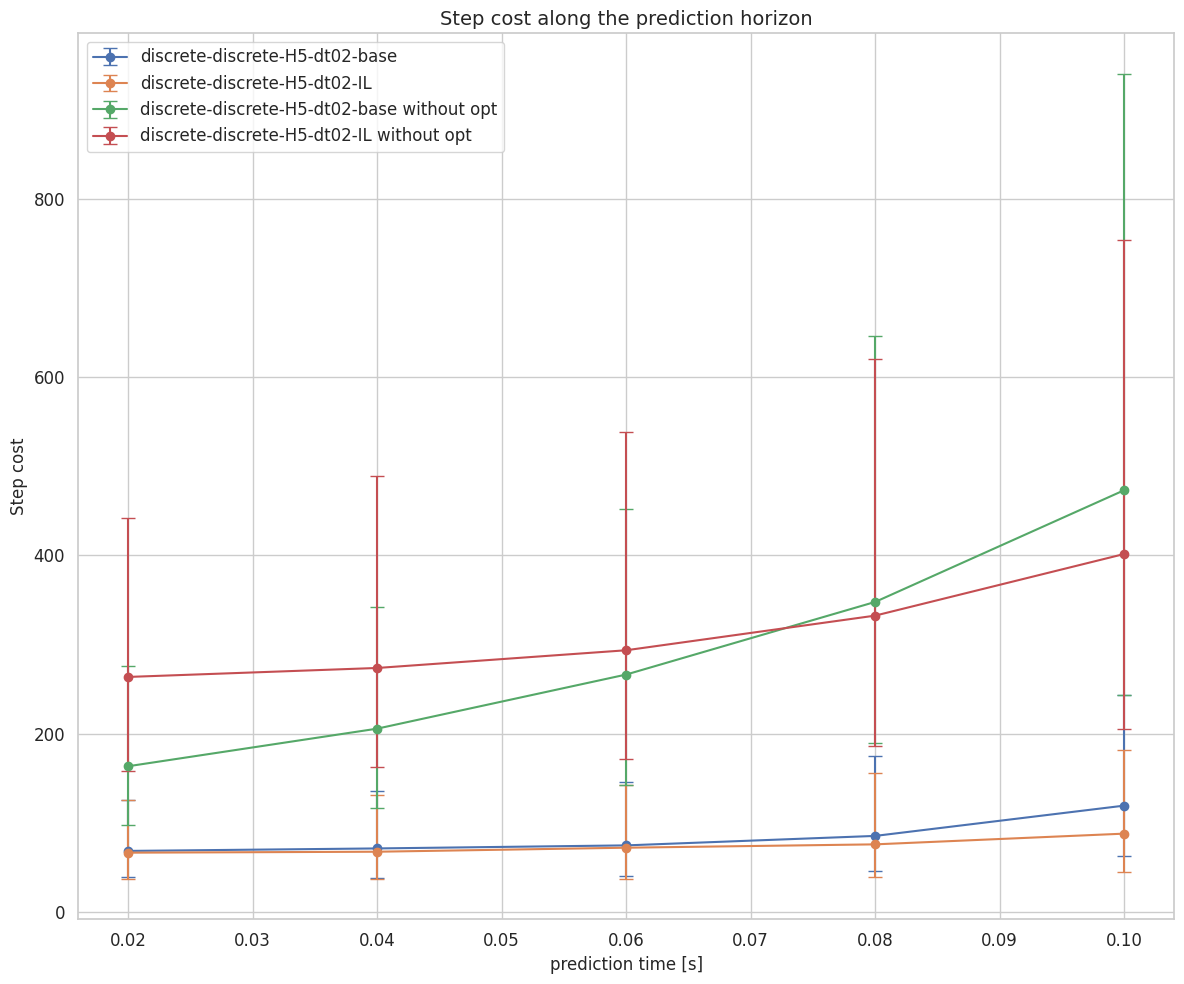

In [140]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import json
import torch

sns.set_theme(style=style_theme)
plt.figure(figsize=(12, 10))


path1 = "/home/baptiste/Documents/dls_isaac_lab_bat_private/eval/samplingController_Eval_H5_Dis_Dis"
path2 = "/home/baptiste/Documents/dls_isaac_lab_bat_private/eval/samplingTrainer_Eval_H5_Dis_Dis"

json_info_path1 = os.path.join(path1, "info.json")
json_info_path2 = os.path.join(path2, "info.json")
if os.path.isfile(json_info_path1):
    with open(json_info_path1, 'r') as json_file:
        info_dict_with_opt = json.load(json_file)  # Load JSON data into a Python dictionary
if os.path.isfile(json_info_path2):
    with open(json_info_path2, 'r') as json_file:
        info_dict_without_optimization = json.load(json_file)  # Load JSON data into a Python dictionary
# info_dict = {**info1_dict}#, **info2_dict}#, **info3_dict}


for key in info_dict_with_opt : 
    # if 'first-spline' in key and not 'H15-dt04' in key:
    # if 'H5-dt02' in key:
    if not "speed" in key:
        # if 'discrete-discrete' in key:
        # if 'first-discrete' in key or 'first-spline' in key :
        # if 'first-spline-H5-dt04' in key or 'first-spline-H10-dt02' in key:
            # y = [0] + info_dict[key]['step_cost_results']['step_cost_median']
            y = np.array(info_dict_with_opt[key]['step_cost_results']['step_cost_median'])
            q1 = np.array(info_dict_with_opt[key]['step_cost_results']['step_costq1_values'])
            q3 = np.array(info_dict_with_opt[key]['step_cost_results']['step_costq3_values'])
            yerr = [y - q1, q3 - y]

            if '02' in key: x = torch.arange(len(y))*0.02 + 0.02
            else :          x = torch.arange(len(y))*0.04 + 0.04

            # plt.plot(x,y, marker='o', label=key)
            plt.errorbar(x, y, yerr=yerr, marker='o', label=key, capsize=5)

for key in info_dict_without_optimization : 
    # if 'first-spline' in key and not 'H15-dt04' in key:
    # if 'H5-dt02' in key:
    if not "speed" in key:
        # if 'discrete-discrete' in key:
        # if 'first-discrete' in key or 'first-spline' in key :
        # if 'first-spline-H5-dt04' in key or 'first-spline-H10-dt02' in key:
            # y = [0] + info_dict[key]['step_cost_results']['step_cost_median']
            y = np.array(info_dict_without_optimization[key]['step_cost_results']['step_cost_median'])
            q1 = np.array(info_dict_without_optimization[key]['step_cost_results']['step_costq1_values'])
            q3 = np.array(info_dict_without_optimization[key]['step_cost_results']['step_costq3_values'])
            yerr = [y - q1, q3 - y]

            if '02' in key: x = torch.arange(len(y))*0.02 + 0.02
            else :          x = torch.arange(len(y))*0.04 + 0.04

            # plt.plot(x,y, marker='o', label=key + ' without opt')
            plt.errorbar(x, y, yerr=yerr, marker='o', label=key + ' without opt', capsize=5)


# Customize the plot for the scientific report
plt.title('Step cost along the prediction horizon', fontsize=14)
plt.xlabel('prediction time [s]', fontsize=12)
plt.ylabel('Step cost', fontsize=12)
# plt.legend(title=r'Algorithm', fontsize=12, title_fontsize=12)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.yscale('log')
plt.tight_layout()

# Save the plot if needed
# plt.savefig("thesis image/9/DaggervsNaiveMSE.pdf", bbox_inches='tight')

# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import json
import torch

sns.set_theme(style=style_theme)
plt.figure(figsize=(12, 10))


path1 = "/home/baptiste/Documents/dls_isaac_lab_bat_private/eval/samplingController_dagger_contact_aligned"
path2 = "/home/baptiste/Documents/dls_isaac_lab_bat_private/eval/samplingTrainer_dagger_contact_aligned"

json_info_path1 = os.path.join(path1, "info.json")
json_info_path2 = os.path.join(path2, "info.json")
if os.path.isfile(json_info_path1):
    with open(json_info_path1, 'r') as json_file:
        info_dict_with_opt = json.load(json_file)  # Load JSON data into a Python dictionary
if os.path.isfile(json_info_path2):
    with open(json_info_path2, 'r') as json_file:
        info_dict_without_optimization = json.load(json_file)  # Load JSON data into a Python dictionary
# info_dict = {**info1_dict}#, **info2_dict}#, **info3_dict}


for key in info_dict_with_opt : 
    # if 'first-spline' in key and not 'H15-dt04' in key:
    if 'H5-dt02' in key:
        if 'discrete-discrete' in key or 'first-spline' in key:
        # if 'first-discrete' in key or 'first-spline' in key :
        # if 'first-spline-H5-dt04' in key or 'first-spline-H10-dt02' in key:
            # y = [0] + info_dict[key]['step_cost_results']['step_cost_median']
            y = np.array(info_dict_with_opt[key]['step_cost_results']['step_cost_median'])
            q1 = np.array(info_dict_with_opt[key]['step_cost_results']['step_costq1_values'])
            q3 = np.array(info_dict_with_opt[key]['step_cost_results']['step_costq3_values'])
            yerr = [y - q1, q3 - y]

            if '02' in key: x = torch.arange(len(y))*0.02 + 0.02
            else :          x = torch.arange(len(y))*0.04 + 0.04

            plt.plot(x,y, marker='o', label=key)
            # plt.errorbar(x, y, yerr=yerr, marker='o', label=key, capsize=5)

for key in info_dict_without_optimization : 
    # if 'first-spline' in key and not 'H15-dt04' in key:
    if 'H5-dt02' in key:
        if 'discrete-discrete' in key or 'first-spline' in key:
        # if 'first-discrete' in key or 'first-spline' in key :
        # if 'first-spline-H5-dt04' in key or 'first-spline-H10-dt02' in key:
            # y = [0] + info_dict[key]['step_cost_results']['step_cost_median']
            y = np.array(info_dict_without_optimization[key]['step_cost_results']['step_cost_median'])
            q1 = np.array(info_dict_without_optimization[key]['step_cost_results']['step_costq1_values'])
            q3 = np.array(info_dict_without_optimization[key]['step_cost_results']['step_costq3_values'])
            yerr = [y - q1, q3 - y]

            if '02' in key: x = torch.arange(len(y))*0.02 + 0.02
            else :          x = torch.arange(len(y))*0.04 + 0.04

            plt.plot(x,y, marker='o', label=key + ' without opt')
            # plt.errorbar(x, y, yerr=yerr, marker='o', label=key + ' without opt', capsize=5)


# Customize the plot for the scientific report
plt.title('Step cost along the prediction horizon', fontsize=14)
plt.xlabel('prediction time [s]', fontsize=12)
plt.ylabel('Step cost', fontsize=12)
# plt.legend(title=r'Algorithm', fontsize=12, title_fontsize=12)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.yscale('log')
# plt.xscale('log')
plt.tight_layout()

# Save the plot if needed
# plt.savefig("thesis image/9/DaggervsNaiveMSE.pdf", bbox_inches='tight')

# Show the plot
plt.show()

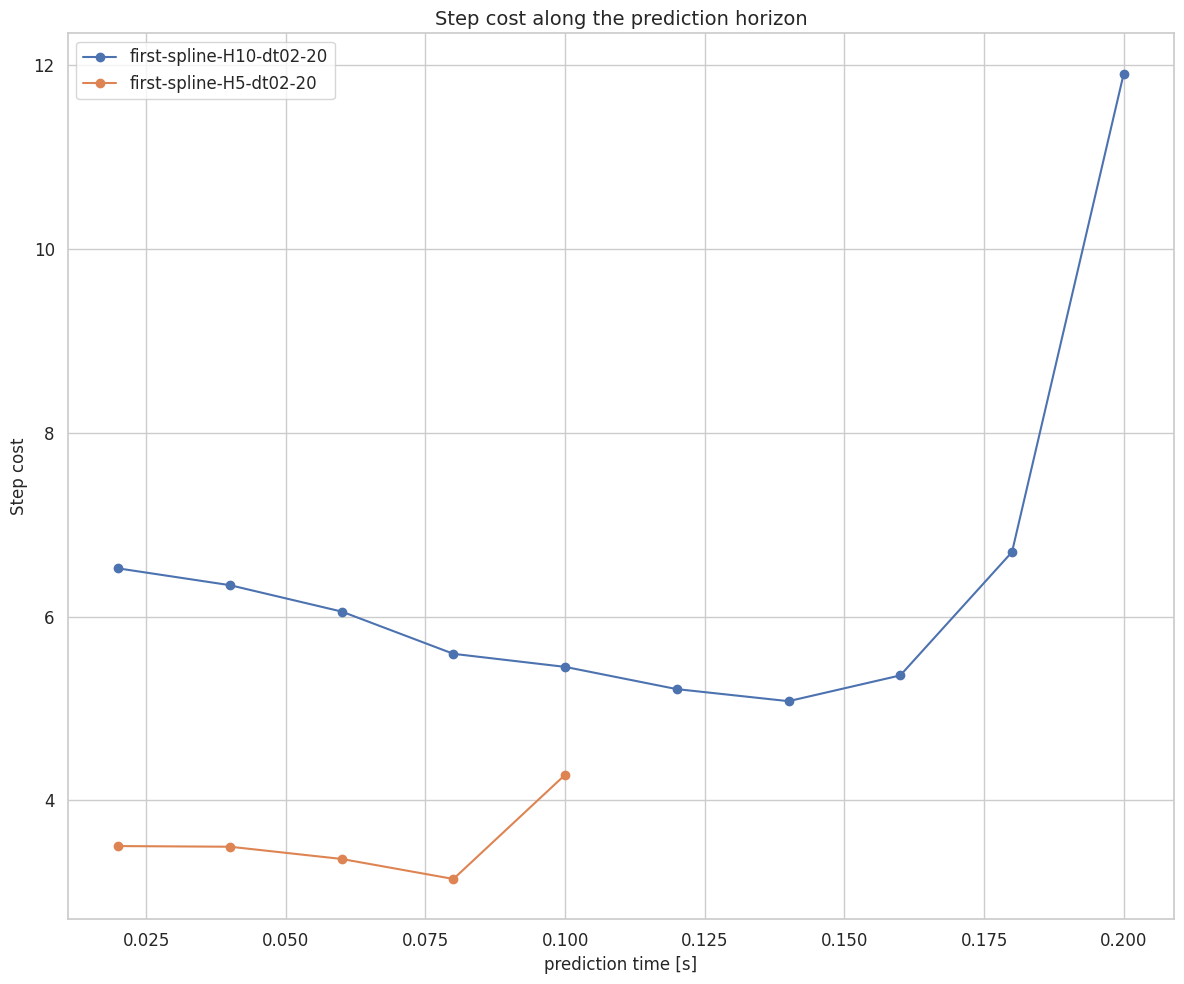

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import json
import torch

sns.set_theme(style=style_theme)
plt.figure(figsize=(12, 10))


path1 = "/home/baptiste/Documents/dls_isaac_lab_bat_private/eval/Simple_Eval_vs_Mujoco"

info_dict_with_opt = {}
json_info_path1 = os.path.join(path1, "info.json")
if os.path.isfile(json_info_path1):
    with open(json_info_path1, 'r') as json_file:
        info_dict_with_opt = json.load(json_file)  


for key in info_dict_with_opt : 
            y = np.array(info_dict_with_opt[key]['step_cost_results']['step_cost_median'])
            q1 = np.array(info_dict_with_opt[key]['step_cost_results']['step_costq1_values'])
            q3 = np.array(info_dict_with_opt[key]['step_cost_results']['step_costq3_values'])
            yerr = [y - q1, q3 - y]

            if '02' in key: x = torch.arange(len(y))*0.02 + 0.02
            else :          x = torch.arange(len(y))*0.04 + 0.04

            plt.plot(x,y, marker='o', label=key)
            # plt.errorbar(x, y, yerr=yerr, marker='o', label=key, capsize=5)



# Customize the plot for the scientific report
plt.title('Step cost along the prediction horizon', fontsize=14)
plt.xlabel('prediction time [s]', fontsize=12)
plt.ylabel('Step cost', fontsize=12)
# plt.legend(title=r'Algorithm', fontsize=12, title_fontsize=12)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.yscale('log')
# plt.xscale('log')
plt.tight_layout()

# Save the plot if needed
# plt.savefig("thesis image/9/DaggervsNaiveMSE.pdf", bbox_inches='tight')

# Show the plot
plt.show()

# 2. Effect of Action Encoding on sampling controller

Reward  Sampling_Cost  \
warm_start    encoding_p encoding_F                            
-             discrete   discrete    2.320051     787.271729   
                         spline      2.335882     485.023438   
              spline     discrete    2.324683     581.947510   
                         spline      2.333072     455.661407   
              first      discrete    2.338519     432.852875   
                         spline      2.347069     291.796173   
no_warm_start discrete   discrete    1.298568    8512.071289   
                         spline      2.259596     221.531189   
              first      discrete    1.242209    9576.677734   
                         spline      2.259524     211.729706   
              spline     discrete    1.331408    8107.576172   
                         spline      2.266363     218.364807   

                                     Sampling_Cost_q1  Sampling_Cost_q3  \
warm_start    encoding_p encoding_F                                       
-             discrete   discrete          468.161434       1209.398056   
                         spline            296.748880        710.862556   
              spline     discrete          340.115469        964.463860   
                         spline            243.339365        761.255539   
              first      discrete          262.082226        668.105534   
                         spline            191.168244        421.319901   
no_warm_start discrete   discrete         2919.284027      27782.417969   
                         spline            122.248042        367.987707   
              first      discrete         2781.093887      32741.600342   
                         spline            118.005145        352.480352   
              spline     discrete         2733.724350      30304.225586   
                         spline            123.406769        351.627813   

                                     initial_Cost  initial_Cost_q3  \
warm_start    encoding_p encoding_F                                  
-             discrete   discrete       61.439564        88.698654   
                         spline         46.278931        64.719833   
              spline     discrete       47.562286        72.609299   
                         spline         45.726044        73.376190   
              first      discrete       35.153690        49.648914   
                         spline         30.722523        40.787907   
no_warm_start discrete   discrete      879.715942      2293.042969   
                         spline         33.260944        56.740700   
              first      discrete      983.719543      2651.085449   
                         spline         31.435551        54.784481   
              spline     discrete      854.952148      2485.701904   
                         spline         32.456520        53.268135   

                                     initial_Cost_q1  \
warm_start    encoding_p encoding_F                    
-             discrete   discrete          42.693871   
                         spline            32.534592   
              spline     discrete          31.815327   
                         spline            28.535692   
              first      discrete          25.234606   
                         spline            23.025379   
no_warm_start discrete   discrete         375.673523   
                         spline            18.453592   
              first      discrete         354.791534   
                         spline            17.396032   
              spline     discrete         349.131226   
                         spline            18.417671   

                                                                                     x  \
warm_start    encoding_p encoding_F                                                      
-             discrete   discrete    [tensor(0.), tensor(0.0200), tensor(0.0400), t...   
                         spline      [tensor(0.), tenso

('-', 'discrete', 'discrete')
('-', 'discrete', 'spline')
('-', 'spline', 'discrete')
('-', 'spline', 'spline')
('-', 'first', 'discrete')
('-', 'first', 'spline')
('no_warm_start', 'discrete', 'discrete')
('no_warm_start', 'discrete', 'spline')
('no_warm_start', 'first', 'discrete')
('no_warm_start', 'first', 'spline')
('no_warm_start', 'spline', 'discrete')
('no_warm_start', 'spline', 'spline')


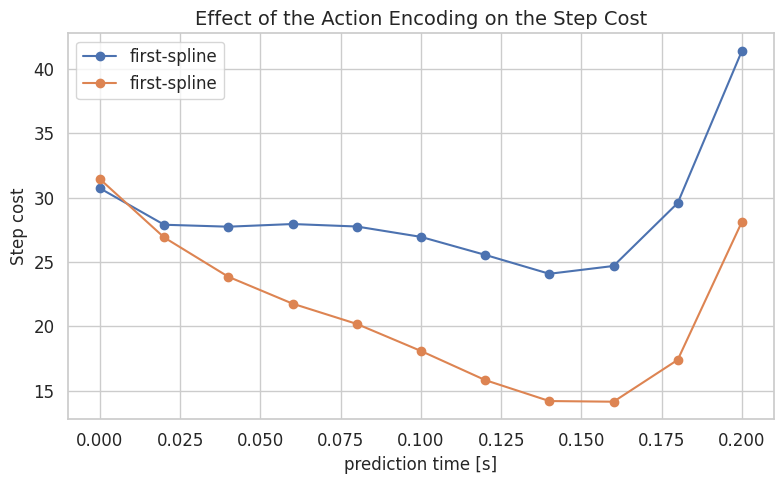

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import json
import torch
import pandas

sns.set_theme(style=style_theme)
plt.figure(figsize=(8, 5))


# path  = "/home/iit.local/bsavioz/Documents/dls_orbit_bat_private/eval/play_eval_H10_dt02_all_act"
path  = "/home/baptiste/Documents/dls_isaac_lab_bat_private/eval/play_eval_H10_dt02_all_act"

info_dict = {}
with open(os.path.join(path, "info.json"), 'r') as json_file:
    info_dict = json.load(json_file)  


# key_list = ['first-discrete-H5-dt02-20', 'first-spline-H5-dt02-20', 'first-discrete-H10-dt02-20', 'first-spline-H10-dt02-20', 'first-discrete-H15-dt02-20', 'first-spline-H15-dt02-20']
# index_list = ['H05 - first-discrete', 'H05 - first-spline', 'H10 - first-discrete', 'H10 - first-spline', 'H15 - first-discrete', 'H15 - first-spline']

df = pandas.DataFrame(columns=('Reward','Sampling_Cost', 'Sampling_Cost_q1', 'Sampling_Cost_q3', 'initial_Cost', 'initial_Cost_q3', 'initial_Cost_q1','x', 'y', 'yerr'))

for key in info_dict : 
# for key in sorted(info_dict) : 
# for key in key_list : 
# for i in range(len(key_list)):    
    # key = key_list[i]

    # Save info in DF
    reward = info_dict[key]['rewards_median_all']

    sampling_cost    = info_dict[key]['sampling_cost_median_all']
    sampling_cost_q1 = sum(info_dict[key]['step_cost_results']['step_costq1_values'])
    sampling_cost_q3 = sum(info_dict[key]['step_cost_results']['step_costq3_values'])

    init_state    = info_dict[key]['step_cost_results']['initial_cost_median'][0]
    init_state_q3 = info_dict[key]['step_cost_results']['initial_costq1_values']
    init_state_q1 = info_dict[key]['step_cost_results']['initial_costq3_values']

    y = np.array(info_dict[key]['step_cost_results']['step_cost_median'])
    q1 = np.array(info_dict[key]['step_cost_results']['step_costq1_values'])
    q3 = np.array(info_dict[key]['step_cost_results']['step_costq3_values'])

    y= np.insert(y,0,init_state)
    q1 = np.insert(q1,0,init_state_q1)
    q3 = np.insert(q3,0,init_state_q3)
    yerr = [y - q1, q3 - y]

    if '02' in key: x = torch.arange(len(y))*0.02 #+ 0.02
    else :          x = torch.arange(len(y))*0.04 #+ 0.04

    # if '--' in key:
    #     plt.plot(x,y, marker='o', label=key)
    # plt.plot(x,y, marker='o', label=index_list[i])
    # plt.errorbar(x, y, yerr=yerr, marker='o', label=key, capsize=5)

    # print(key, ' - init_state :',init_state,' - Reward :', reward, ' - sampling cost :', sampling_cost)
    df.loc[key] = [100*reward, sampling_cost, sampling_cost_q1, sampling_cost_q3, init_state, init_state_q1, init_state_q3, x, y, yerr]



# Function to extract the required parts for MultiIndex
def extract_parts(idx):
    parts = idx.split('-')
    warm_start = 'no_warm_start' if 'no_warm_start' in idx else '-'
    encoding_p = parts[0]
    encoding_F = parts[1]
    return warm_start, encoding_p, encoding_F

# Apply the function to create a new MultiIndex
multi_index = pd.MultiIndex.from_tuples(df.index.map(extract_parts),
                                        names=['warm_start', 'encoding_p', 'encoding_F'])

# Set the new MultiIndex to the DataFrame
df.set_index(multi_index, inplace=True)
df.sort_index(inplace=True)


# Desired new order for the rows by their numeric positions
new_order = [0, 1, 4, 5, 2, 3,6,7,8,9,10,11]  # Reordering by the positions 0-based index

# Reorder the DataFrame using iloc
df = df.iloc[new_order]

# Show the resulting DataFrame
# display(df.sort_values(by='Reward', ascending=False))
display(df)



for index, row in df.iterrows():
    print(index)
    if index[0] == 'no_warm_start' : continue
    # if index[1] != 'first' : continue
    # if index[2] != 'spline' : continue
    plt.plot(row['x'], row['y'],  marker='o', label=f'{index[1]}-{index[2]}')


# Customize the plot for the scientific report
# plt.title('Step Cost Along the Prediction Horizon', fontsize=14)
plt.title('Effect of the Action Encoding on the Step Cost', fontsize=14)
plt.xlabel('prediction time [s]', fontsize=12)
plt.ylabel('Step cost', fontsize=12)
# plt.legend(title=r'Algorithm', fontsize=12, title_fontsize=12)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.yscale('log')
plt.tight_layout()


# Save the plot if neededove
plt.savefig("thesis image/9/sampCon_cost_diff_act.pdf", bbox_inches='tight')

# Show the plot
plt.show()

### Initial Cost

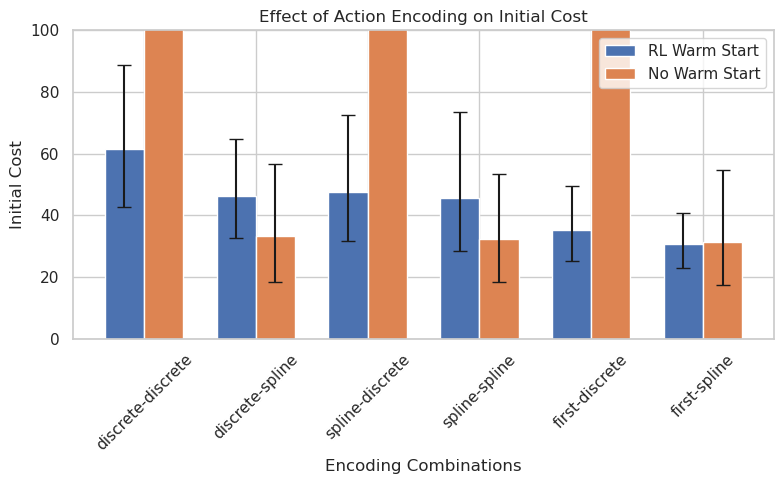

In [617]:
import matplotlib.pyplot as plt
import numpy as np

encoding_combinations = df.index.droplevel('warm_start').unique()
warm_starts = ['-', 'no_warm_start']

# Plotting
fig, ax = plt.subplots(figsize=(8, 5)) #(10,7)
bar_width = 0.35
index = np.arange(len(encoding_combinations))

medians, medians_nws = [], []
errors, errors_nws = [], []
for i in index :
    med     = df.loc['-',             encoding_combinations[i][0], encoding_combinations[i][1]]['initial_Cost']
    med_nws = df.loc['no_warm_start', encoding_combinations[i][0], encoding_combinations[i][1]]['initial_Cost']
    q1      = df.loc['-',             encoding_combinations[i][0], encoding_combinations[i][1]]['initial_Cost_q1']
    q1_nws  = df.loc['no_warm_start', encoding_combinations[i][0], encoding_combinations[i][1]]['initial_Cost_q1']
    q3      = df.loc['-',             encoding_combinations[i][0], encoding_combinations[i][1]]['initial_Cost_q3']
    q3_nws  = df.loc['no_warm_start', encoding_combinations[i][0], encoding_combinations[i][1]]['initial_Cost_q3']

    medians.append(med)
    medians_nws.append(med_nws)
    errors.append([med - q1, q3 - med])
    errors_nws.append((med_nws - q1_nws, q3_nws - med_nws))

ax.bar(index          ,medians    , bar_width, yerr=np.array(errors).transpose()    ,label='RL Warm Start',    capsize=5)#, color='royalblue')
ax.bar(index+bar_width,medians_nws, bar_width, yerr=np.array(errors_nws).transpose(),label='No Warm Start', capsize=5)#, color='peru')


# Labels and title
ax.set_xlabel('Encoding Combinations')
ax.set_ylabel('Initial Cost')
ax.set_title('Effect of Action Encoding on Initial Cost')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels([f'{p}-{f}' for p, f in encoding_combinations], rotation=45)
ax.legend(loc='upper right')
ax.set_ylim(0,100)

# Layout and save as PDF
fig.tight_layout()
plt.savefig('thesis image/9/intial_cost_bar_plot.pdf')
plt.show()


#### With reward on same axis

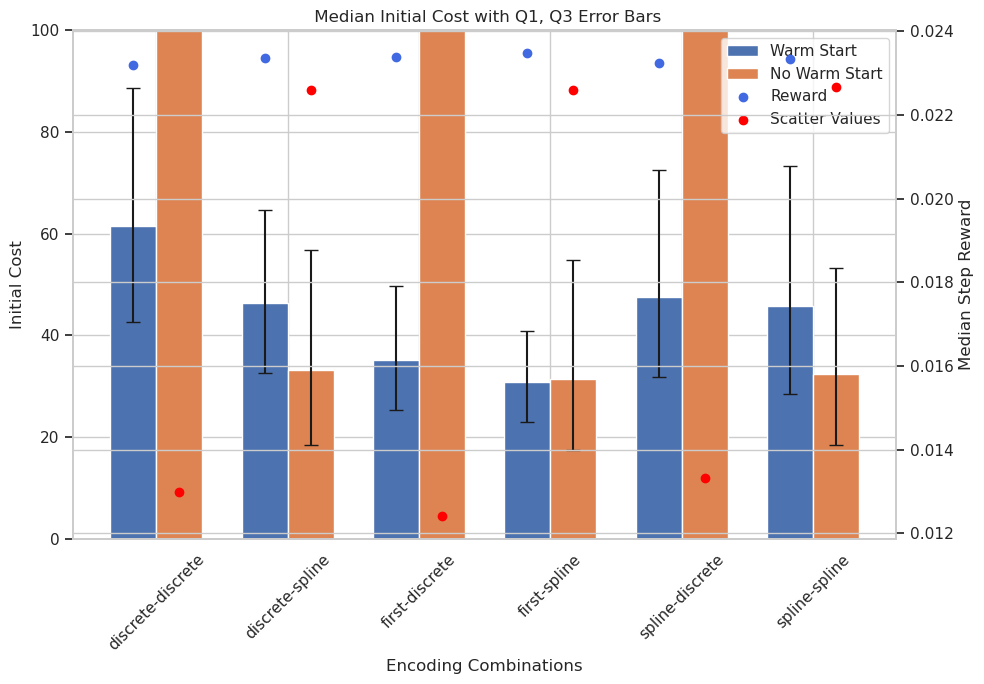

In [233]:
import matplotlib.pyplot as plt
import numpy as np

encoding_combinations = df.index.droplevel('warm_start').unique()
warm_starts = ['-', 'no_warm_start']

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 7)) #(10,7)

bar_width = 0.35
index = np.arange(len(encoding_combinations))

medians, medians_nws = [], []
errors, errors_nws = [], []
reward, reward_nws = [], []
for i in index :
    med     = df.loc['-',             encoding_combinations[i][0], encoding_combinations[i][1]]['initial_Cost']
    med_nws = df.loc['no_warm_start', encoding_combinations[i][0], encoding_combinations[i][1]]['initial_Cost']
    q1      = df.loc['-',             encoding_combinations[i][0], encoding_combinations[i][1]]['initial_Cost_q1']
    q1_nws  = df.loc['no_warm_start', encoding_combinations[i][0], encoding_combinations[i][1]]['initial_Cost_q1']
    q3      = df.loc['-',             encoding_combinations[i][0], encoding_combinations[i][1]]['initial_Cost_q3']
    q3_nws  = df.loc['no_warm_start', encoding_combinations[i][0], encoding_combinations[i][1]]['initial_Cost_q3']

    medians.append(med)
    medians_nws.append(med_nws)
    errors.append([med - q1, q3 - med])
    errors_nws.append((med_nws - q1_nws, q3_nws - med_nws))

    rew    = df.loc['-',             encoding_combinations[i][0], encoding_combinations[i][1]]['Reward']
    rew_nws= df.loc['no_warm_start', encoding_combinations[i][0], encoding_combinations[i][1]]['Reward']
    reward.append(rew)
    reward_nws.append(rew_nws)

ax1.bar(index          ,medians    , bar_width, yerr=np.array(errors).transpose()    ,label='Warm Start',    capsize=5)#, color='royalblue')
ax1.bar(index+bar_width,medians_nws, bar_width, yerr=np.array(errors_nws).transpose(),label='No Warm Start', capsize=5)#, color='peru')


ax2 = ax1.twinx()

ax2.scatter(index          , reward    , color='royalblue', label='Reward')
ax2.scatter(index+bar_width, reward_nws, color='red',       label='Scatter Values')
# ax2.bar(index-bar_width/2, reward, bar_width/2, color='red', label='Scatter Values')



# Labels and title
ax1.set_xlabel('Encoding Combinations')
ax1.set_ylabel('Initial Cost')
ax1.set_title(' Median Initial Cost with Q1, Q3 Error Bars')

ax2.set_ylabel('Median Step Reward')
# ax2.set_ylim(0.023,0.0236)

ax1.set_xticks(index + bar_width / 2)
ax1.set_xticklabels([f'{p}-{f}' for p, f in encoding_combinations], rotation=45)
ax1.legend(loc='upper right')
ax1.set_ylim(0,100)

# Combine legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

# Layout and save as PDF
fig.tight_layout()
# plt.savefig('bar_plot_with_median_q1_q3.pdf')
plt.show()


### Rollout cost

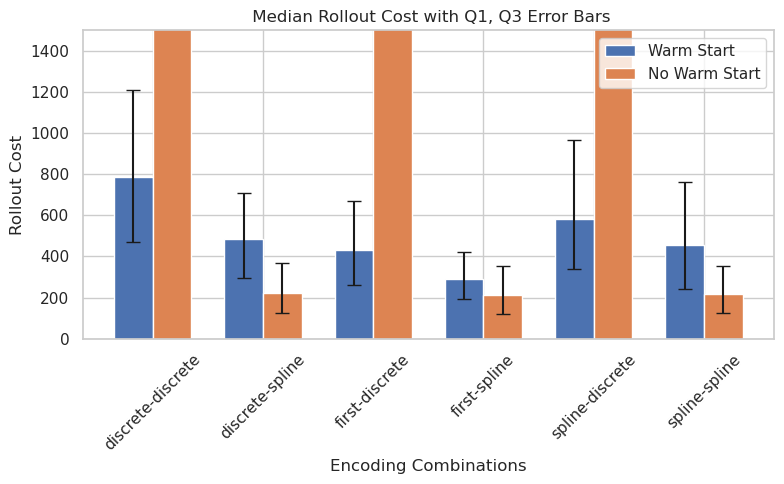

In [272]:
import matplotlib.pyplot as plt
import numpy as np

encoding_combinations = df.index.droplevel('warm_start').unique()
warm_starts = ['-', 'no_warm_start']

# Plotting
fig, ax = plt.subplots(figsize=(8, 5))
bar_width = 0.35
index = np.arange(len(encoding_combinations))

medians, medians_nws = [], []
errors, errors_nws = [], []
for i in index :
    med     = df.loc['-',             encoding_combinations[i][0], encoding_combinations[i][1]]['Sampling_Cost']
    med_nws = df.loc['no_warm_start', encoding_combinations[i][0], encoding_combinations[i][1]]['Sampling_Cost']
    q1      = df.loc['-',             encoding_combinations[i][0], encoding_combinations[i][1]]['Sampling_Cost_q1']
    q1_nws  = df.loc['no_warm_start', encoding_combinations[i][0], encoding_combinations[i][1]]['Sampling_Cost_q1']
    q3      = df.loc['-',             encoding_combinations[i][0], encoding_combinations[i][1]]['Sampling_Cost_q3']
    q3_nws  = df.loc['no_warm_start', encoding_combinations[i][0], encoding_combinations[i][1]]['Sampling_Cost_q3']

    medians.append(med)
    medians_nws.append(med_nws)
    errors.append([med - q1, q3 - med])
    errors_nws.append((med_nws - q1_nws, q3_nws - med_nws))

ax.bar(index          ,medians    , bar_width, yerr=np.array(errors).transpose()    ,label='Warm Start', capsize=5)
ax.bar(index+bar_width,medians_nws, bar_width, yerr=np.array(errors_nws).transpose(),label='No Warm Start', capsize=5)


# Labels and title
ax.set_xlabel('Encoding Combinations')
ax.set_ylabel('Rollout Cost')
ax.set_title(' Median Rollout Cost with Q1, Q3 Error Bars')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels([f'{p}-{f}' for p, f in encoding_combinations], rotation=45)
ax.legend(loc='upper right')
ax.set_ylim(0,1500)

# Layout and save as PDF
fig.tight_layout()
# plt.savefig('bar_plot_with_median_q1_q3.pdf')
plt.show()


# 1. Effect of Horizon on sampling Controller

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import json
import torch
import pandas

sns.set_theme(style=style_theme)
plt.figure(figsize=(12, 10))


path_with_opt  = "/home/iit.local/bsavioz/Documents/dls_orbit_bat_private/eval/samplingController_base_IL_dt02_Force_opti_first_spline_and_dis"
path_with_opt2 = "/home/iit.local/bsavioz/Documents/dls_orbit_bat_private/eval/samplingController_base_IL_dt04_Force_opti_first_spline_and_dis"

info_dict_with_opt = {}
json_info_path_with_opt = os.path.join(path_with_opt, "info.json")
json_info_path_with_opt2= os.path.join(path_with_opt2, "info.json")
if os.path.isfile(json_info_path_with_opt):
    with open(json_info_path_with_opt, 'r') as json_file:
        info_dict_with_opt = json.load(json_file)  
if os.path.isfile(json_info_path_with_opt2):
    with open(json_info_path_with_opt2, 'r') as json_file:
        info_dict_with_opt2 = json.load(json_file)  

info_dict_with_opt = {**info_dict_with_opt, **info_dict_with_opt2}

# key_list = ['first-discrete-H5-dt02-20', 'first-spline-H5-dt02-20', 'first-discrete-H10-dt02-20', 'first-spline-H10-dt02-20', 'first-discrete-H15-dt02-20', 'first-spline-H15-dt02-20']
# index_list = ['H05 - first-discrete', 'H05 - first-spline', 'H10 - first-discrete', 'H10 - first-spline', 'H15 - first-discrete', 'H15 - first-spline']

df = pandas.DataFrame(columns=('Reward','Sampling Cost', 'initial Cost'))

for key in sorted(info_dict_with_opt) : 
# for key in key_list : 
# for i in range(len(key_list)):    
    # key = key_list[i]
    reward = info_dict_with_opt[key]['rewards_median_all']
    sampling_cost = info_dict_with_opt[key]['sampling_cost_median_all']
    init_state = np.median(info_dict_with_opt[key]['step_cost_results']['initial_cost_median'][0])
    q1_init_state = info_dict_with_opt[key]['step_cost_results']['initial_costq1_values']
    q3_init_state = info_dict_with_opt[key]['step_cost_results']['initial_costq3_values']
    y = np.array(info_dict_with_opt[key]['step_cost_results']['step_cost_median'])
    q1 = np.array(info_dict_with_opt[key]['step_cost_results']['step_costq1_values'])
    q3 = np.array(info_dict_with_opt[key]['step_cost_results']['step_costq3_values'])
    y= np.insert(y,0,init_state)
    q1 = np.insert(q1,0,q1_init_state)
    q3 = np.insert(q3,0,q3_init_state)
    yerr = [y - q1, q3 - y]

    if '02' in key: x = torch.arange(len(y))*0.02 #+ 0.02
    else :          x = torch.arange(len(y))*0.04 #+ 0.04

    plt.plot(x,y, marker='o', label=key)
    # plt.plot(x,y, marker='o', label=index_list[i])
    # plt.errorbar(x, y, yerr=yerr, marker='o', label=key, capsize=5)

    # print(key, ' - init_state :',init_state,' - Reward :', reward, ' - sampling cost :', sampling_cost)
    df.loc[key] = [reward, sampling_cost, init_state]



# Customize the plot for the scientific report
plt.title('Step cost along the prediction horizon', fontsize=14)
plt.xlabel('prediction time [s]', fontsize=12)
plt.ylabel('Step cost', fontsize=12)
# plt.legend(title=r'Algorithm', fontsize=12, title_fontsize=12)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.yscale('log')
plt.tight_layout()

display(df.sort_values(by='Reward',ascending=False))

# Save the plot if needed
# plt.savefig("thesis image/9/DaggervsNaiveMSE.pdf", bbox_inches='tight')

# Show the plot
plt.show()

NameError: name 'info_dict_with_opt2' is not defined

<Figure size 1200x1000 with 0 Axes>

Reward  Sampling_Cost  initial_Cost
warm_start    Horizon dt                                         
-             H05     dt02  2.354620      64.655907     14.623058
                      dt04  2.347737     166.738708     25.040981
              H10     dt02  2.346048     311.744080     32.930878
                      dt04  2.327009    2701.259277    128.400558
              H15     dt02  2.329390    1445.810425     75.917641
                      dt04  2.238667   57700.312500    477.231781
no_warm_start H05     dt02  2.257551     113.936195     31.412346
                      dt04  2.254645     125.402107     31.411480
              H10     dt02  2.247724     193.961975     28.611229
                      dt04  2.178903     741.668274     79.812363
              H15     dt02  2.232593     484.434784     41.117626
                      dt04  1.756482    4498.499023    408.028503

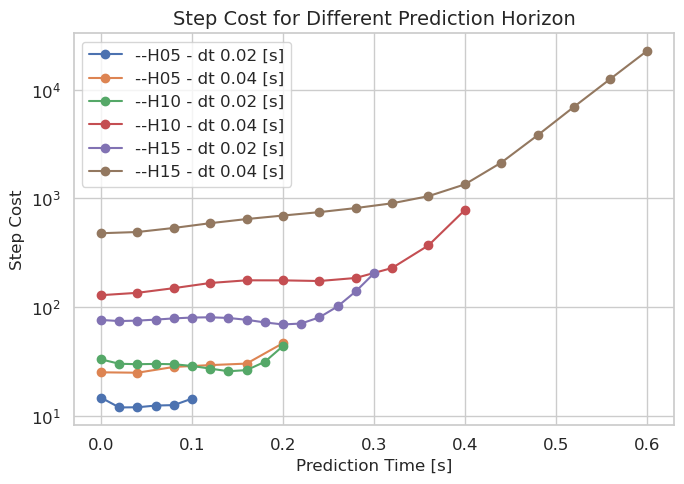

In [620]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import json
import torch
import pandas

sns.set_theme(style=style_theme)
plt.figure(figsize=(7, 5))
# plt.figure(figsize=(12, 8))


path  = "/home/iit.local/bsavioz/Documents/dls_orbit_bat_private/eval/play_eval_all_horizon"

info_dict = {}
with open(os.path.join(path, "info.json"), 'r') as json_file:
    info_dict = json.load(json_file)  


df = pandas.DataFrame(columns=('Reward','Sampling_Cost', 'Sampling_Cost_q1', 'Sampling_Cost_q3', 'initial_Cost', 'initial_Cost_q3', 'initial_Cost_q1','x', 'y', 'yerr'))

for key in info_dict : 

    reward = info_dict[key]['rewards_median_all']

    sampling_cost    = info_dict[key]['sampling_cost_median_all']
    sampling_cost_q1 = sum(info_dict[key]['step_cost_results']['step_costq1_values'])
    sampling_cost_q3 = sum(info_dict[key]['step_cost_results']['step_costq3_values'])

    init_state    = info_dict[key]['step_cost_results']['initial_cost_median'][0]
    init_state_q3 = info_dict[key]['step_cost_results']['initial_costq1_values']
    init_state_q1 = info_dict[key]['step_cost_results']['initial_costq3_values']

    y = np.array(info_dict[key]['step_cost_results']['step_cost_median'])
    q1 = np.array(info_dict[key]['step_cost_results']['step_costq1_values'])
    q3 = np.array(info_dict[key]['step_cost_results']['step_costq3_values'])

    y= np.insert(y,0,init_state)
    q1 = np.insert(q1,0,init_state_q1)
    q3 = np.insert(q3,0,init_state_q3)
    yerr = [y - q1, q3 - y]

    if '02' in key: x = torch.arange(len(y))*0.02 #+ 0.02
    else :          x = torch.arange(len(y))*0.04 #+ 0.04

    # if '--' in key:
    #     plt.plot(x,y, marker='o', label=key)
    # plt.plot(x,y, marker='o', label=index_list[i])
    # plt.errorbar(x, y, yerr=yerr, marker='o', label=key, capsize=5)

    # print(key, ' - init_state :',init_state,' - Reward :', reward, ' - sampling cost :', sampling_cost)
    df.loc[key] = [100*reward, sampling_cost, sampling_cost_q1, sampling_cost_q3, init_state, init_state_q1, init_state_q3, x, y, yerr]



# Function to extract the required parts for MultiIndex
def extract_parts(idx):
    parts = idx.split('-')
    warm_start = 'no_warm_start' if 'no_warm_start' in idx else '-'
    encoding_p = parts[0]
    encoding_F = parts[1]
    H          = parts[2]
    dt         = parts[3]
    samples    = parts[4]
    if H == 'H5' : H='H05'
    return warm_start, encoding_p, encoding_F, H, dt, samples

# Apply the function to create a new MultiIndex
multi_index = pd.MultiIndex.from_tuples(df.index.map(extract_parts),
                                        names=['warm_start', 'encoding_p', 'encoding_F', 'Horizon', 'dt', 'samples'])

# Set the new MultiIndex to the DataFrame
df.set_index(multi_index, inplace=True)
# df.sort_index(inplace=True)
df.sort_index(inplace=True, level=["Horizon", "dt"])


# Desired new order for the rows by their numeric positions
# new_order = [0, 1, 4, 5, 2, 3,6,7,8,9,10,11]  # Reordering by the positions 0-based index
# df = df.iloc[new_order]

# Show the resulting DataFrame
# display(df.sort_values(by='Reward', ascending=False))
filtered_df = df.loc[df.index.get_level_values('samples') == 'samples10000']
filtered_df = filtered_df.loc[filtered_df.index.get_level_values('encoding_F')=='spline']
filtered_df = filtered_df.drop(columns=['Sampling_Cost_q1', 'Sampling_Cost_q3', 'initial_Cost_q1', 'initial_Cost_q3', 'x', 'y','yerr'])
filtered_df = filtered_df.droplevel(['samples', 'encoding_p', 'encoding_F']).sort_index(level=['warm_start'])

display(filtered_df)
# display(df.loc[df.index.get_level_values('samples') == 'samples10000'].drop(columns=['Sampling_Cost_q1', 'Sampling_Cost_q3', 'initial_Cost_q1', 'initial_Cost_q3', 'x', 'y','yerr']).droplevel(['samples']))



for index, row in df.iterrows():
    # print(index)
    if index[0] == 'no_warm_start' : continue
    if index[2] == 'discrete':continue
    # if index[3] != 'H15' : continue
    # if index[4] != 'dt02': continue
    if index[5] != 'samples10000': continue
    # if index[3] == 'H15' and index[4]=='dt04' : continue
    # plt.plot(row['x'], row['y'],  marker='o', label=f'{index[2]}-{index[3]}-{index[4]}-{index[5]}')

    if index[4] == 'dt02' : dt = 'dt 0.02 [s]'
    if index[4] == 'dt04' : dt = 'dt 0.04 [s]' 
    plt.plot(row['x'], row['y'],  marker='o', label=f'{index[0]}-{index[3]} - {dt}')


# Customize the plot for the scientific report
plt.title('Step Cost for Different Prediction Horizon', fontsize=14)
plt.xlabel('Prediction Time [s]', fontsize=12)
plt.ylabel('Step Cost', fontsize=12)
plt.legend(title=r'Algorithm', fontsize=12, title_fontsize=12)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.yscale('log')
plt.tight_layout()


# Save the plot if neededove
plt.savefig("thesis image/9/sampCon_act_cost_along_H.pdf", bbox_inches='tight')

# Show the plot
plt.show()

# ---

In [6]:
import os
import json
import torch
import pandas as pd
import numpy as np

def extract_df_and_dict(path):

    info_dict = {}
    with open(os.path.join(path, "info.json"), 'r') as json_file:
        info_dict = json.load(json_file)  

    df = pd.DataFrame(columns=('Reward','Sampling_Cost', 'Sampling_Cost_q1', 'Sampling_Cost_q3', 'initial_Cost', 'initial_Cost_q3', 'initial_Cost_q1','x', 'y', 'yerr'))

    for key in info_dict : 

        reward = info_dict[key]['rewards_median_all']

        sampling_cost    = info_dict[key]['sampling_cost_median_all']
        sampling_cost_q1 = sum(info_dict[key]['step_cost_results']['step_costq1_values'])
        sampling_cost_q3 = sum(info_dict[key]['step_cost_results']['step_costq3_values'])

        init_state    = info_dict[key]['step_cost_results']['initial_cost_median'][0]
        init_state_q3 = info_dict[key]['step_cost_results']['initial_costq1_values']
        init_state_q1 = info_dict[key]['step_cost_results']['initial_costq3_values']

        y = np.array(info_dict[key]['step_cost_results']['step_cost_median'])
        q1 = np.array(info_dict[key]['step_cost_results']['step_costq1_values'])
        q3 = np.array(info_dict[key]['step_cost_results']['step_costq3_values'])

        y= np.insert(y,0,init_state)
        q1 = np.insert(q1,0,init_state_q1)
        q3 = np.insert(q3,0,init_state_q3)
        yerr = [y - q1, q3 - y]

        if '02' in key: x = torch.arange(len(y))*0.02 #+ 0.02
        else :          x = torch.arange(len(y))*0.04 #+ 0.04

        df.loc[key] = [100*reward, sampling_cost, sampling_cost_q1, sampling_cost_q3, init_state, init_state_q1, init_state_q3, x, y, yerr]

    return df, info_dict

### 1. Effect of the number of samples

Reward  Sampling_Cost  Sampling_Cost_q1  \
warm_start    samples                                              
-             4000     2.348807     333.490967        219.089212   
              10000    2.347235     303.319580        198.069647   
              25000    2.348705     278.389221        180.416149   
no_warm_start 4000     2.251709     243.380432        139.415564   
              10000    2.260890     193.591095        110.148739   
              25000    2.268889     172.606796         95.092735   

                       Sampling_Cost_q3  initial_Cost  initial_Cost_q3  \
warm_start    samples                                                    
-             4000           481.331837     33.647709        45.045380   
              10000          441.606628     32.099983        42.655788   
              25000          406.660786     30.626175        40.797531   
no_warm_start 4000           392.108669     33.823849        55.744366   
              10000          312.924828     28.474060        47.918365   
              25000          284.209625     27.150307        47.400158   

                       initial_Cost_q1  Reward_var  Sampling_Cost_var  \
warm_start    samples                                                   
-             4000           25.205927    0.066944           9.947062   
              10000          24.083946    0.000000           0.000000   
              25000          22.928389    0.062603          -8.219172   
no_warm_start 4000           19.694574   -0.406086          25.718816   
              10000          16.212173    0.000000           0.000000   
              25000          14.997389    0.353813         -10.839496   

                       Sampling_Cost_q1_var  Sampling_Cost_q3_var  \
warm_start    samples                                               
-             4000                10.612209              8.995610   
              10000                0.000000              0.000000   
              25000               -8.912773             -7.913342   
no_warm_start 4000                26.570277             25.304429   
              10000                0.000000              0.000000   
              25000              -13.668794             -9.176390   

                       initial_Cost_var  initial_Cost_q3_var  \
warm_start    samples                                          
-             4000             4.821578             5.602033   
              10000            0.000000             0.000000   
              25000           -4.591305            -4.356401   
no_warm_start 4000            18.788289            16.331943   
              10000            0.000000             0.000000   
              25000           -4.648980            -1.081438   

                       initial_Cost_q1_var  
warm_start    samples                       
-             4000                4.658625  
              10000               0.000000  
              25000              -4.798041  
no_warm_start 4000               21.480161  
              10000               0.000000  
              25000              -7.493040

Index(['4000', '10000', '25000'], dtype='object', name='samples')


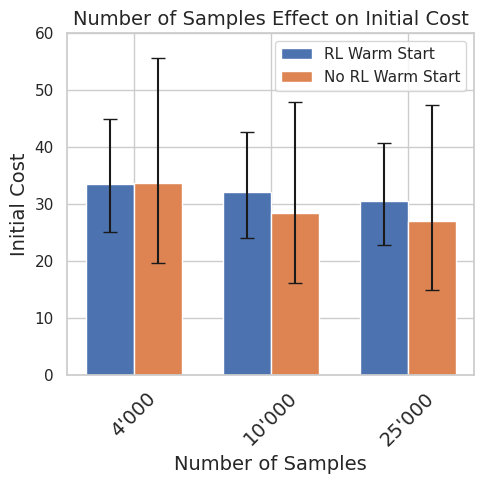

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import json
import torch
import pandas


# path  = "/home/iit.local/bsavioz/Documents/dls_orbit_bat_private/eval/play_eval_all_horizon"
# path  = "/home/iit.local/bsavioz/Documents/dls_orbit_bat_private/eval/play_eval_base_num_samples"
path  = "/home//baptiste/Documents/dls_isaac_lab_bat_private/eval/play_eval_base_num_samples"


info_dict = {}
with open(os.path.join(path, "info.json"), 'r') as json_file:
    info_dict = json.load(json_file)  


df = pandas.DataFrame(columns=('Reward','Sampling_Cost', 'Sampling_Cost_q1', 'Sampling_Cost_q3', 'initial_Cost', 'initial_Cost_q3', 'initial_Cost_q1','x', 'y', 'yerr'))

for key in info_dict : 

    reward = info_dict[key]['rewards_median_all']

    sampling_cost    = info_dict[key]['sampling_cost_median_all']
    sampling_cost_q1 = sum(info_dict[key]['step_cost_results']['step_costq1_values'])
    sampling_cost_q3 = sum(info_dict[key]['step_cost_results']['step_costq3_values'])

    init_state    = info_dict[key]['step_cost_results']['initial_cost_median'][0]
    init_state_q3 = info_dict[key]['step_cost_results']['initial_costq1_values']
    init_state_q1 = info_dict[key]['step_cost_results']['initial_costq3_values']

    y = np.array(info_dict[key]['step_cost_results']['step_cost_median'])
    q1 = np.array(info_dict[key]['step_cost_results']['step_costq1_values'])
    q3 = np.array(info_dict[key]['step_cost_results']['step_costq3_values'])

    y= np.insert(y,0,init_state)
    q1 = np.insert(q1,0,init_state_q1)
    q3 = np.insert(q3,0,init_state_q3)
    yerr = [y - q1, q3 - y]

    if '02' in key: x = torch.arange(len(y))*0.02 #+ 0.02
    else :          x = torch.arange(len(y))*0.04 #+ 0.04

    df.loc[key] = [100*reward, sampling_cost, sampling_cost_q1, sampling_cost_q3, init_state, init_state_q1, init_state_q3, x, y, yerr]

# display(df)

# Function to extract the required parts for MultiIndex
def extract_parts(idx):
    parts = idx.split('-')
    warm_start = 'no_warm_start' if 'no_warm_start' in idx else '-'
    encoding_p = parts[0]
    encoding_F = parts[1]
    H          = parts[2]
    dt         = parts[3]
    samples    = parts[4][7:]
    if H == 'H5' : H='H05'
    return warm_start, encoding_p, encoding_F, H, dt, samples

# Apply the function to create a new MultiIndex
multi_index = pd.MultiIndex.from_tuples(df.index.map(extract_parts),
                                        names=['warm_start', 'encoding_p', 'encoding_F', 'Horizon', 'dt', 'samples'])

# Set the new MultiIndex to the DataFrame
df.set_index(multi_index, inplace=True)
# df.sort_index(inplace=True)
df.sort_index(inplace=True, level=["Horizon", "dt"])


# Desired new order for the rows by their numeric positions
# new_order = [0, 1, 4, 5, 2, 3,6,7,8,9,10,11]  # Reordering by the positions 0-based index
# df = df.iloc[new_order]

# Show the resulting DataFrame
# display(df.sort_values(by='Reward', ascending=False))
filtered_df = df.copy()
# filtered_df = filtered_df.loc[filtered_df.index.get_level_values('samples') == 'samples10000']
filtered_df = filtered_df.loc[filtered_df.index.get_level_values('encoding_F')=='spline']
filtered_df = filtered_df.loc[filtered_df.index.get_level_values('Horizon')=='H10']
filtered_df = filtered_df.loc[filtered_df.index.get_level_values('dt')=='dt02']
# filtered_df = filtered_df.drop(columns=['Sampling_Cost_q1', 'Sampling_Cost_q3', 'initial_Cost_q1', 'initial_Cost_q3', 'x', 'y','yerr'])
filtered_df = filtered_df.drop(columns=['x', 'y','yerr'])
filtered_df = filtered_df.droplevel(['encoding_p', 'encoding_F', "Horizon", "dt"]).sort_index(level=['warm_start'])

# display(filtered_df)
# display(df)


expanded_df = filtered_df.copy()

new_order = [2, 0, 1, 5, 3, 4]  # Reordering by the positions 0-based index
expanded_df = expanded_df.iloc[new_order]

expanded_df1 = expanded_df.loc[[('-')]]
expanded_df2 = expanded_df.loc[[('no_warm_start')]]

# Define the reference rows in your MultiIndex
reference_indices = [('-', '10000'), ('no_warm_start', '10000')]
sub_df = [expanded_df1, expanded_df2]

# # Calculate the variation for each column with respect to each reference value
for i in range(len(sub_df)):
    for col in sub_df[i].columns:
        ref_value = sub_df[i].loc[reference_indices[i],col]
        sub_df[i][f'{col}_var'] = 100*(sub_df[i][col] - ref_value)/ref_value

# display(expanded_df1)
# display(expanded_df2)
expanded_df = pd.concat([expanded_df1,expanded_df2])
display(expanded_df)


encoding_combinations = expanded_df.index.droplevel('warm_start').unique()
warm_starts = ['-', 'no_warm_start']
print(encoding_combinations)


# Plotting
fig, ax = plt.subplots(figsize=(5, 5)) #(10,7)
bar_width = 0.35
index = np.arange(len(encoding_combinations))

medians, medians_nws = [], []
errors, errors_nws = [], []
for i in index :
    med     = expanded_df.loc['-',             encoding_combinations[i]]['initial_Cost']
    med_nws = expanded_df.loc['no_warm_start', encoding_combinations[i]]['initial_Cost']
    q1      = expanded_df.loc['-',             encoding_combinations[i]]['initial_Cost_q1']
    q1_nws  = expanded_df.loc['no_warm_start', encoding_combinations[i]]['initial_Cost_q1']
    q3      = expanded_df.loc['-',             encoding_combinations[i]]['initial_Cost_q3']
    q3_nws  = expanded_df.loc['no_warm_start', encoding_combinations[i]]['initial_Cost_q3']

    medians.append(med)
    medians_nws.append(med_nws)
    errors.append([med - q1, q3 - med])
    errors_nws.append((med_nws - q1_nws, q3_nws - med_nws))

ax.bar(index          ,medians    , bar_width, yerr=np.array(errors).transpose()    ,label='RL Warm Start',    capsize=5)#, color='royalblue')
ax.bar(index+bar_width,medians_nws, bar_width, yerr=np.array(errors_nws).transpose(),label='No RL Warm Start', capsize=5)#, color='peru')

fontsize=14
# Labels and title
ax.set_xlabel('Number of Samples',fontsize=fontsize)
ax.set_ylabel('Initial Cost',fontsize=fontsize)
ax.set_title('Number of Samples Effect on Initial Cost',fontsize=fontsize)
ax.set_xticks(index + bar_width / 2)
# ax.set_xticklabels([f'{p}' for p in encoding_combinations], rotation=45,fontsize=fontsize)
ax.set_xticklabels([f'{p}' for p in ['4\'000', '10\'000', '25\'000']], rotation=45,fontsize=fontsize)
ax.legend(loc='upper right')
ax.set_ylim(0,60)

# Layout and save as PDF
fig.tight_layout()
plt.savefig('thesis image/9/bar_plot_effect_num_samples.pdf')
plt.show()



### 4. Gait optimization effect

MultiIndex([( 'True', 'False',   'slow'),
            ('False', 'False',   'slow'),
            ( 'True', 'False', 'medium'),
            ('False', 'False', 'medium'),
            ( 'True', 'False',   'fast'),
            ('False', 'False',   'fast')],
           names=['frequency', 'duty_cycle', 'speed'])
List of Task  :  ['medium', 'fast', 'slow']
List of Model :  ['base_RL']


cumulated_reward  trajectory_length  survived  commanded_speed_for  \
0             35.402882          15.000248       1.0                  0.5   
1             35.408653          15.000248       1.0                  0.5   
2             35.412258          15.000248       1.0                  0.5   
3             35.423046          15.000248       1.0                  0.5   
4             35.392384          15.000248       1.0                  0.5   
...                 ...                ...       ...                  ...   
24571         35.366196          15.000248       1.0                  0.5   
24572         35.303761          15.000248       1.0                  0.5   
24573         35.336880          15.000248       1.0                  0.5   
24574         35.308258          15.000248       1.0                  0.5   
24575         35.392071          15.000248       1.0                  0.5   

       commanded_speed_lat  commanded_speed_ang  average_speed  \
0                 0.008728             0.099717       0.526985   
1                -0.034700            -0.076012       0.524786   
2                 0.083831            -0.053183       0.536849   
3                 0.088703            -0.000943       0.538974   
4                 0.021408             0.173664       0.528349   
...                    ...                  ...            ...   
24571            -0.085996             0.265314       0.527888   
24572            -0.071296             0.497465       0.523510   
24573             0.046415             0.394035       0.529878   
24574            -0.076554             0.281808       0.523996   
24575            -0.070988             0.004081       0.526606   

       cumulated_distance  cost_of_transport  stairs_cleared  \
0                7.904904           1.521090            15.0   
1                7.871923           1.532702            10.0   
2                8.052861           1.524943            16.0   
3                8.084740           1.520589            23.0   
4                7.925361           1.523581            14.0   
...                   ...                ...             ...   
24571            7.918449           4.561216            11.0   
24572            7.852778           4.603031             0.0   
24573            7.948309           4.612423             0.0   
24574            7.860068           4.618081             0.0   
24575            7.899219           4.579945            20.0   

       terrain_difficulty  sampling_init_cost_mean  sampling_init_cost_median  
0                     0.0                87.500023                  76.415611  
1                     0.0                88.376961                  78.486237  
2                     0.0                76.565559                  65.406784  
3                     0.0                71.305115                  59.284286  
4                     0.0                83.990349                  73.312584  
...                   ...                      ...                        ...  
24571                 0.0                94.377159                  85.213356  
24572                 0.0                98.025925                  88.462967  
24573                 0.0                82.237038                  72.317398  
24574                 0.0                98.738106                  88.478058  
24575                 0.0                92.381844                  83.832657  

[24576 rows x 13 columns]

initial cost baseline RL 0.1 m/s : 112.83653
initial cost baseline RL 0.5 m/s : 75.19678
initial cost baseline RL 1.5 m/s : 57.15173530578613
<class 'numpy.ndarray'>
<class 'list'>


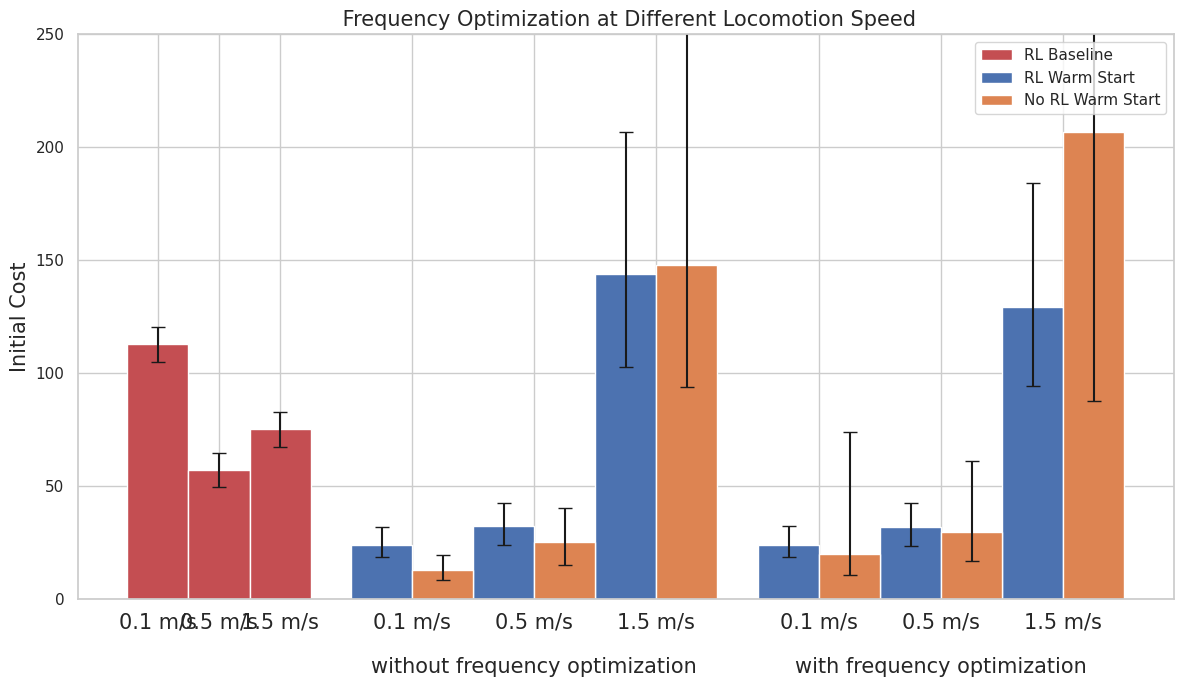

In [136]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import json
import torch
import pandas as pd

# path  = "/home/iit.local/bsavioz/Documents/dls_orbit_bat_private/eval/play_eval_base_freq_opt"
path  = "/home/baptiste/Documents/dls_isaac_lab_bat_private/eval/play_eval_base_freq_opt"

info_dict = {}
with open(os.path.join(path, "info.json"), 'r') as json_file:
    info_dict = json.load(json_file)  

df = pd.DataFrame(columns=('Reward','Sampling_Cost', 'Sampling_Cost_q1', 'Sampling_Cost_q3', 'initial_Cost', 'initial_Cost_q3', 'initial_Cost_q1','x', 'y', 'yerr'))

for key in info_dict : 
    reward = info_dict[key]['rewards_median_all']

    sampling_cost    = info_dict[key]['sampling_cost_median_all']
    sampling_cost_q1 = sum(info_dict[key]['step_cost_results']['step_costq1_values'])
    sampling_cost_q3 = sum(info_dict[key]['step_cost_results']['step_costq3_values'])

    init_state    = info_dict[key]['step_cost_results']['initial_cost_median'][0]
    init_state_q3 = info_dict[key]['step_cost_results']['initial_costq1_values']
    init_state_q1 = info_dict[key]['step_cost_results']['initial_costq3_values']

    y = np.array(info_dict[key]['step_cost_results']['step_cost_median'])
    q1 = np.array(info_dict[key]['step_cost_results']['step_costq1_values'])
    q3 = np.array(info_dict[key]['step_cost_results']['step_costq3_values'])

    y= np.insert(y,0,init_state)
    q1 = np.insert(q1,0,init_state_q1)
    q3 = np.insert(q3,0,init_state_q3)
    yerr = [y - q1, q3 - y]

    if '02' in key: x = torch.arange(len(y))*0.02 #+ 0.02
    else :          x = torch.arange(len(y))*0.04 #+ 0.04

    df.loc[key] = [100*reward, sampling_cost, sampling_cost_q1, sampling_cost_q3, init_state, init_state_q1, init_state_q3, x, y, yerr]

# display(df)

# Function to extract the required parts for MultiIndex
def extract_parts(idx):
    parts = idx.split('-')
    warm_start = 'no_warm_start' if 'no_warm_start' in idx else '-'
    offset = 1 if not 'no_warm_start' in idx else 0
    encoding_p = parts[0]
    encoding_F = parts[1]
    H          = parts[2]
    dt         = parts[3]
    samples    = parts[5][7:]
    f_opt      = parts[6+offset][1:]
    d_opt      = parts[7+offset][1:]
    speed      = parts[8+offset]
    if H == 'H5' : H='H05'
    return warm_start, f_opt, d_opt, speed

multi_index = pd.MultiIndex.from_tuples(df.index.map(extract_parts), names=['warm_start', 'frequency', 'duty_cycle', 'speed'])
df.set_index(multi_index, inplace=True)
df.sort_index(inplace=True)
df.sort_index(inplace=True, level=["speed"], ascending=False)
# display(df)

filtered_df = df.copy()
filtered_df = filtered_df.loc[filtered_df.index.get_level_values('duty_cycle')=='False']

encoding_combinations = filtered_df.index.droplevel('warm_start').unique()
warm_starts = ['-', 'no_warm_start']
print(encoding_combinations)


# path = "/home/iit.local/bsavioz/Documents/dls_orbit_bat_private/eval/play_RL_all_baseline_all_test_task_alo_alo"
path = "/home/baptiste/Documents/dls_isaac_lab_bat_private/eval/speed_baseline_comparison_RL_with_sampling_controller"

df_dict = {}
gait_df_dict = {}
task_list, model_list = [], []
for folder in os.listdir(path):
   if os.path.isdir(f"{path}/{folder}"):
      task = folder.split('-')[4]
      model = folder.split('-')[1]
      df_dict.setdefault(task, {})[model] = pd.read_pickle(f'{path}/{folder}/result_df.pkl') 
      # gait_df_dict.setdefault(task, {})[model] = pd.read_pickle(f'{path}/{folder}/gait_df.pkl') 
    #   display(df)

      if task not in task_list:
         task_list.append(task)
      if model not in model_list:
         model_list.append(model)

print('List of Task  : ',task_list)
print('List of Model : ',model_list)
display(df_dict['medium']['base_RL'])
# display(gait_df_dict['speed_test']['climb_RL'])


fast_median_value     = df_dict['fast']['base_RL']['sampling_init_cost_median'].median()
fast_first_quartile   = df_dict['fast']['base_RL']['sampling_init_cost_median'].quantile(0.25)
fast_third_quartile   = df_dict['fast']['base_RL']['sampling_init_cost_median'].quantile(0.75)
fast_error            = np.array(fast_median_value - fast_first_quartile, fast_third_quartile - fast_median_value)
medium_median_value   = df_dict['medium']['base_RL']['sampling_init_cost_median'].median()
medium_first_quartile = df_dict['medium']['base_RL']['sampling_init_cost_median'].quantile(0.25)
medium_third_quartile = df_dict['medium']['base_RL']['sampling_init_cost_median'].quantile(0.75)
medium_error          = np.array(fast_median_value - fast_first_quartile, fast_third_quartile - fast_median_value)
slow_median_value     = df_dict['slow']['base_RL']['sampling_init_cost_median'].median()
slow_first_quartile   = df_dict['slow']['base_RL']['sampling_init_cost_median'].quantile(0.25)
slow_third_quartile   = df_dict['slow']['base_RL']['sampling_init_cost_median'].quantile(0.75)
slow_error            = np.array(fast_median_value - fast_first_quartile, fast_third_quartile - fast_median_value)

print('initial cost baseline RL 0.1 m/s :', slow_median_value)
print('initial cost baseline RL 0.5 m/s :', medium_median_value)
print('initial cost baseline RL 1.5 m/s :', fast_median_value)

# Plotting
sns.set_theme(style=style_theme)
fig, ax = plt.subplots(figsize=(12, 7)) #(10,7)
bar_width = 0.15
index = np.arange(len(encoding_combinations))

col = (0.7686274509803922, 0.3058823529411765, 0.3215686274509804)
ax.bar(-0.7 - bar_width,slow_median_value   , bar_width, yerr=slow_error    ,label='RL Baseline', capsize=5, color=col)
ax.bar(-0.7            ,fast_median_value   , bar_width, yerr=medium_error  ,                     capsize=5, color=col)
ax.bar(-0.7 + bar_width,medium_median_value , bar_width, yerr=fast_error    ,                     capsize=5, color=col)


medians, medians_nws = [], []
errors, errors_nws = [], []
for i in index :
    med     = filtered_df.loc['-',             encoding_combinations[i][0], encoding_combinations[i][1], encoding_combinations[i][2]]['initial_Cost']
    med_nws = filtered_df.loc['no_warm_start', encoding_combinations[i][0], encoding_combinations[i][1], encoding_combinations[i][2]]['initial_Cost']
    q1      = filtered_df.loc['-',             encoding_combinations[i][0], encoding_combinations[i][1], encoding_combinations[i][2]]['initial_Cost_q1']
    q1_nws  = filtered_df.loc['no_warm_start', encoding_combinations[i][0], encoding_combinations[i][1], encoding_combinations[i][2]]['initial_Cost_q1']
    q3      = filtered_df.loc['-',             encoding_combinations[i][0], encoding_combinations[i][1], encoding_combinations[i][2]]['initial_Cost_q3']
    q3_nws  = filtered_df.loc['no_warm_start', encoding_combinations[i][0], encoding_combinations[i][1], encoding_combinations[i][2]]['initial_Cost_q3']

    medians.append(med)
    medians_nws.append(med_nws)
    errors.append([med - q1, q3 - med])
    errors_nws.append((med_nws - q1_nws, q3_nws - med_nws))

print(type(index))

offset     = [-2, -2, 0, 0, 2, 2]
offset_nws = [-1,-1, 1, 1, 3, 3]
offset     = [o*bar_width for o in offset]
offset_nws = [o*bar_width for o in offset_nws]

new_index  = [1,0,1,0,1,0]
print(type(new_index))

ax.bar([new_index[i]+offset[i]     for i in range(len(offset))],medians    , bar_width,yerr=np.array(errors).transpose()    ,label='RL Warm Start',    capsize=5)#, color='royalblue')
ax.bar([new_index[i]+offset_nws[i] for i in range(len(offset))],medians_nws, bar_width,yerr=np.array(errors_nws).transpose(),label='No RL Warm Start', capsize=5)#, color='peru')

fontsize=15
ax.set_ylabel('Initial Cost',fontsize=fontsize)
ax.set_title(' Frequency Optimization at Different Locomotion Speed',fontsize=fontsize)
# ax.set_xticks(np.array([new_index[i]+offset[i]     for i in range(len(offset))]) + bar_width / 2)
# ax.set_xticklabels(['0.1 m/s', '0.1 m/s', '0.5 m/s', '0.5 m/s', '1.5 m/s', '1.5 m/s'], rotation=0,fontsize=fontsize)

original_ticks = np.array([new_index[i]+offset[i]     for i in range(len(offset))]) + bar_width / 2
more_ticks     = np.array([-0.7 - bar_width, -0.7, -0.7 + bar_width])
ticks          = np.concatenate([more_ticks, original_ticks])
ax.set_xticks(ticks)
ax.set_xticklabels(['0.1 m/s','0.5 m/s','1.5 m/s', '0.1 m/s', '0.1 m/s', '0.5 m/s', '0.5 m/s', '1.5 m/s', '1.5 m/s'], rotation=0,fontsize=fontsize)
ax.legend(loc='upper right')
ax.set_ylim(0,250)

group_labels = ['without frequency optimization', 'with frequency optimization']
for i, label in enumerate(group_labels):
    ax.text(i + bar_width/2, -0.12, label, ha='center', va='center', fontsize=fontsize, transform=ax.get_xaxis_transform())

fig.tight_layout()
plt.savefig('thesis image/9/bar_plot_effect_freq_opt.pdf')
plt.show()

### 6. Comparison on test task for different IL Policy

Reward  Sampling_Cost  initial_Cost
warm_start    model task                                       
no_warm_start base  eval  2.258199     232.271484     34.848400
RL            speed eval  2.225893     443.710693     89.109924
              rough eval  2.105517     987.002380    182.355057
              climb eval  1.949318    1639.314697    332.029175
              base  eval  2.344444     299.266174     31.632448

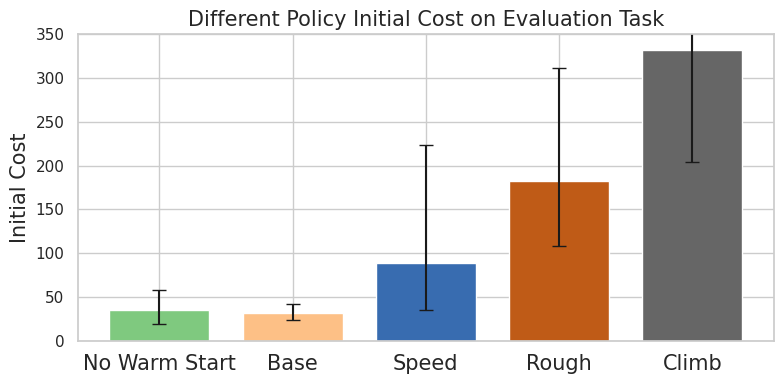

In [119]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import json
import torch
import pandas as pd


# path  = "/home/iit.local/bsavioz/Documents/dls_orbit_bat_private/eval/play_eval_baseline_all_task"
path  = "/home/baptiste/Documents/dls_isaac_lab_bat_private/eval/play_eval_baseline_all_task"

df, info_dict = extract_df_and_dict(path)
# display(df)

# Function to extract the required parts for MultiIndex
def extract_parts(idx):
    parts = idx.split('-')
    warm_start = 'no_warm_start' if 'no_warm_start' in idx else 'RL'
    offset = 1 if not 'no_warm_start' in idx else 0
    task       = parts[0]
    IL         = parts[1]
    encoding_p = parts[2]
    encoding_F = parts[3]
    H          = parts[4]
    dt         = parts[5]

    if H == 'H5' : H='H05'
    return warm_start, task, 'eval'

# Apply the function to create a new MultiIndex
multi_index = pd.MultiIndex.from_tuples(df.index.map(extract_parts), names=['warm_start', 'model', 'task'])

# Set the new MultiIndex to the DataFrame
df.set_index(multi_index, inplace=True)
# df.sort_index(inplace=True)
df.sort_index(inplace=True, level=["warm_start"], ascending=False)
display(df.drop(columns=['Sampling_Cost_q1', 'Sampling_Cost_q3', 'initial_Cost_q1', 'initial_Cost_q3', 'x', 'y','yerr']))

# Desired new order for the rows by their numeric positions
new_order = [0,4,1,2,3]  # Reordering by the positions 0-based index
df = df.iloc[new_order]

# # Show the resulting DataFrame
# filtered_df = df.copy()
# filtered_df = filtered_df.loc[filtered_df.index.get_level_values('samples') == 'samples10000']
# filtered_df = filtered_df.loc[filtered_df.index.get_level_values('duty_cycle')=='False']
# filtered_df = filtered_df.drop(columns=['Sampling_Cost_q1', 'Sampling_Cost_q3', 'initial_Cost_q1', 'initial_Cost_q3', 'x', 'y','yerr'])
# filtered_df = filtered_df.drop(columns=['x', 'y','yerr'])
# filtered_df = filtered_df.droplevel(['encoding_p', 'encoding_F', "Horizon", "dt"]).sort_index(level=['warm_start'])
# display(filtered_df)

encoding_combinations = df.index.unique()
# print(encoding_combinations)

# Plotting
fig, ax = plt.subplots(figsize=(8, 4)) #(10,7)

bar_width = 0.75
index = np.arange(len(encoding_combinations))

medians, errors, labels = [], [], []
for i in index :
    med     = df.loc[encoding_combinations[i][0], encoding_combinations[i][1], encoding_combinations[i][2]]['initial_Cost']
    q1      = df.loc[encoding_combinations[i][0], encoding_combinations[i][1], encoding_combinations[i][2]]['initial_Cost_q1']
    q3      = df.loc[encoding_combinations[i][0], encoding_combinations[i][1], encoding_combinations[i][2]]['initial_Cost_q3']
    
    medians.append(med)
    errors.append([med - q1, q3 - med])
    labels.append(encoding_combinations[i][1])

colors = plt.cm.Accent(np.linspace(0, 1, len(index))) #Accent
ax.bar(index, medians, bar_width, yerr=np.array(errors).transpose(), capsize=5, color=colors)


fontsize=15
# Labels and title
# ax.set_xlabel('Policy',fontsize=fontsize)
ax.set_ylabel('Initial Cost',fontsize=fontsize)
ax.set_title('Different Policy Initial Cost on Evaluation Task',fontsize=fontsize)
ax.set_xticks(index)
ax.set_xticklabels(['No Warm Start', 'Base', 'Speed', 'Rough', 'Climb'], rotation=0,fontsize=fontsize)
ax.set_ylim(0,350)

# group_labels = ['without frequency optimization', 'with frequency optimization']
# for i, label in enumerate(group_labels):
#     ax.text(i + bar_width/2, -0.12, label, ha='center', va='center', fontsize=fontsize, transform=ax.get_xaxis_transform())


# Layout and save as PDF
fig.tight_layout()
plt.savefig('thesis image/9/bar_plot_all_policy_test_task.pdf')
plt.show()



### 6.2 Comparison on test task for different IL Policy

Reward  Sampling_Cost  initial_Cost
task       model                                               
base_task  base           2.305964     773.787964     63.275986
           climb          0.610721    9740.035156   1932.451782
           no_warm_start  1.953926    1745.969604    261.415222
           rough          1.993668    1819.166626    343.245239
           speed          1.894515    1881.897949    375.664093
           speedrough     1.516545    2355.195801    472.738922
climb_task base           2.341005     262.211456     25.266430
           climb          2.265917     344.988037     85.647469
           no_warm_start  2.264323     203.179810     35.851238
           rough          2.039751    1733.834351    329.221222
           speed          2.254572     266.082275     61.589535
           speedrough     2.034004     635.942261    129.693634
eval_task  base           2.348153     308.859863     32.763943
           climb          1.973164    1620.872314    328.847900
           no_warm_start  2.258851     205.919876     30.889950
           rough          2.104034    1001.512024    181.746872
           speed          2.226725     441.656799     86.589569
           speedrough     1.980985     764.320618    153.140366
rough_task base           2.086160    3244.689697    343.973206
           climb          1.246031    3520.177490    755.222290
           no_warm_start  2.013837    1376.522217    246.875214
           rough          1.940872    1977.125732    401.963501
           speed          1.697322    2353.503662    506.996185
           speedrough     1.440773    2793.998291    579.537354
speed_task base           2.247170    1221.793457     99.732780
           climb          1.584680    2501.389648    527.731079
           no_warm_start  2.204072     389.659363     56.561699
           rough          1.953990    1427.849121    260.774780
           speed          2.201822     971.113586    194.395187
           speedrough     1.603020    1782.721191    376.024109

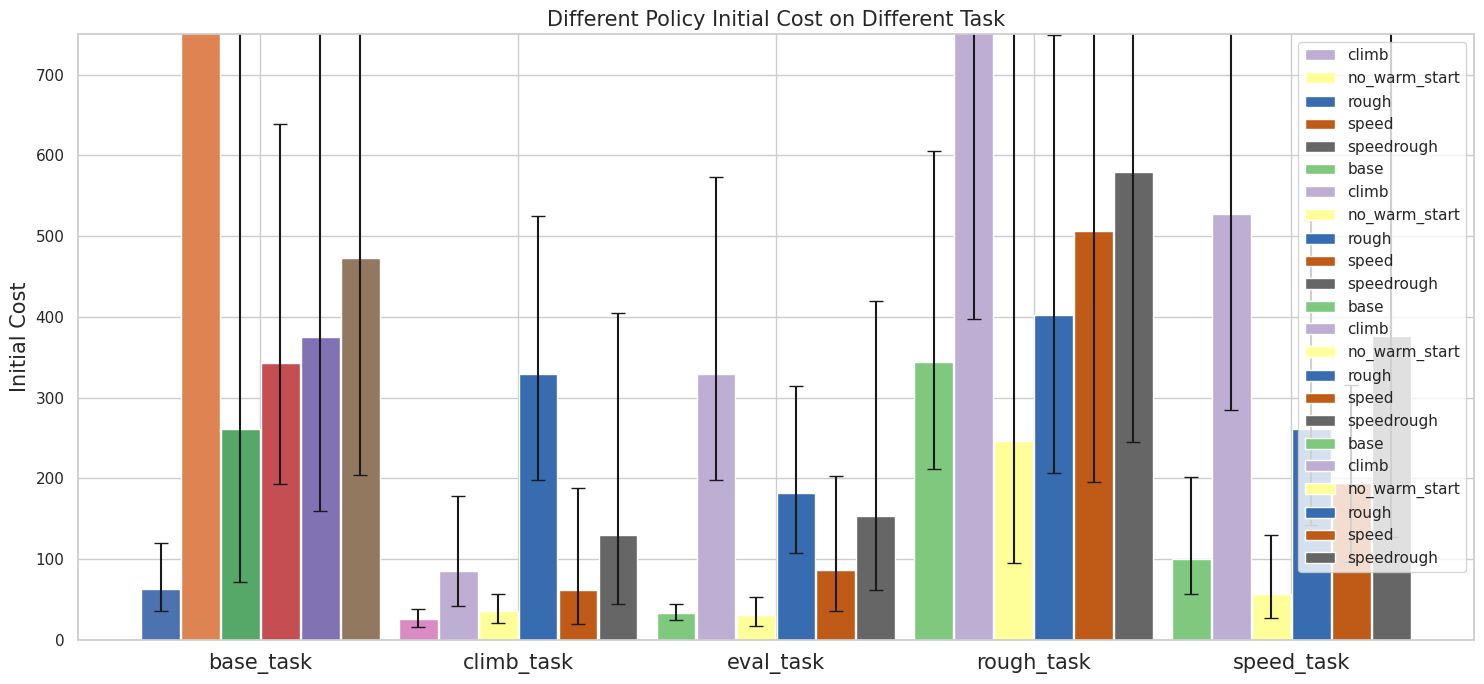

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import json
import torch
import pandas as pd

# path  = "/home/iit.local/bsavioz/Documents/dls_orbit_bat_private/eval/play_eval_baseline_all_task"
path  = "/home/baptiste/Documents/dls_isaac_lab_bat_private/eval/play_eval_all_task_all_model3"
df, info_dict = extract_df_and_dict(path)
# display(df)

# Function to extract the required parts for MultiIndex
def extract_parts(idx):
    parts = idx.split('-')
    warm_start = 'no_warm_start' if 'no_warm_start' in idx else 'RL'
    offset = 1 if not 'no_warm_start' in idx else 0
    _          = parts[0]
    model      = parts[1]
    _          = parts[2]
    task       = parts[3]

    if warm_start == 'no_warm_start':
        model = 'no_warm_start'
    return task, model,

# Apply the function to create a new MultiIndex
multi_index = pd.MultiIndex.from_tuples(df.index.map(extract_parts), names=['task','model'])

# Set the new MultiIndex to the DataFrame
df.set_index(multi_index, inplace=True)
df.sort_index(inplace=True)
# df.sort_index(inplace=True, level=["warm_start"], ascending=False)
display(df.drop(columns=['Sampling_Cost_q1', 'Sampling_Cost_q3', 'initial_Cost_q1', 'initial_Cost_q3', 'x', 'y','yerr']))

# Desired new order for the rows by their numeric positions
# new_order = [0,4,1,2,3]  # Reordering by the positions 0-based index
# df = df.iloc[new_order]

# # Show the resulting DataFrame
# filtered_df = df.copy()
# filtered_df = filtered_df.loc[filtered_df.index.get_level_values('samples') == 'samples10000']
# filtered_df = filtered_df.loc[filtered_df.index.get_level_values('duty_cycle')=='False']
# filtered_df = filtered_df.drop(columns=['Sampling_Cost_q1', 'Sampling_Cost_q3', 'initial_Cost_q1', 'initial_Cost_q3', 'x', 'y','yerr'])
# filtered_df = filtered_df.drop(columns=['x', 'y','yerr'])
# filtered_df = filtered_df.droplevel(['encoding_p', 'encoding_F', "Horizon", "dt"]).sort_index(level=['warm_start'])
# display(filtered_df)

encoding_combinations = df.index.unique()
# print(encoding_combinations)

# Plotting
fig, ax = plt.subplots(figsize=(15, 7)) #(10,7)

bar_width = 0.15
index = np.arange(len(encoding_combinations))
# print(index)

colors = plt.cm.Accent(np.linspace(0, 1, 6)) #Accent

medians, errors, labels = [], [], []
for i in index :
    med     = df.loc[encoding_combinations[i][0], encoding_combinations[i][1]]['initial_Cost']
    q1      = df.loc[encoding_combinations[i][0], encoding_combinations[i][1]]['initial_Cost_q1']
    q3      = df.loc[encoding_combinations[i][0], encoding_combinations[i][1]]['initial_Cost_q3']

    # medians.append(med)
    # errors.append([med - q1, q3 - med])
    # labels.append(encoding_combinations[i][1])
    if i > 6 :
        ax.bar(i//6 + (bar_width+0.005)*((i%6)-2.5), med, bar_width, yerr=[[med - q1], [q3 - med]],color=colors[i%6], label=encoding_combinations[i][1], capsize=5)
    else : 
        ax.bar(i//6 + (bar_width+0.005)*((i%6)-2.5), med, bar_width, yerr=[[med - q1], [q3 - med]], capsize=5)

# colors = plt.cm.Accent(np.linspace(0, 1, len(index))) #Accent
# ax.bar(index, medians, bar_width, yerr=np.array(errors).transpose(), capsize=5, color=colors)


fontsize=15

x_ticks = ['base_task', 'climb_task','eval_task', 'rough_task', 'speed_task']

# Labels and title
# ax.set_xlabel('Policy',fontsize=fontsize)
ax.set_ylabel('Initial Cost',fontsize=fontsize)
ax.set_title('Different Policy Initial Cost on Different Task',fontsize=fontsize)
ax.set_xticks(np.arange(len(x_ticks)))
ax.set_xticklabels(x_ticks, rotation=0,fontsize=fontsize)
ax.set_ylim(0,750)
ax.legend(loc='upper right')

# group_labels = ['base_task', 'climb_task','eval_task', 'rough_task', 'speed_task']
# for i, label in enumerate(group_labels):
#     ax.text(i + bar_width/2, -0.12, label, ha='center', va='center', fontsize=fontsize, transform=ax.get_xaxis_transform())


# Layout and save as PDF
fig.tight_layout()
# plt.savefig('thesis image/9/bar_plot_all_policy_test_task.pdf')
plt.show()



# RL Bencharming on four different Test

## a. Load Data

In [107]:
import pandas as pd
import os
from sklearn.linear_model import LogisticRegression
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style=style_theme)

# path = "/home/iit.local/bsavioz/Documents/dls_orbit_bat_private/eval/play_RL_all_baseline_all_test_task_alo_alo"
path = "/home/baptiste/Documents/dls_isaac_lab_bat_private/eval/play_RL_all_baseline_all_test_task"

df_dict = {}
gait_df_dict = {}
task_list, model_list = [], []
for folder in os.listdir(path):
   if os.path.isdir(f"{path}/{folder}"):
      task = folder.split('-')[3]
      model = folder.split('-')[1]
      df_dict.setdefault(task, {})[model] = pd.read_pickle(f'{path}/{folder}/result_df.pkl') 
      # gait_df_dict.setdefault(task, {})[model] = pd.read_pickle(f'{path}/{folder}/gait_df.pkl') 
      # display(df)

      if task not in task_list:
         task_list.append(task)
      if model not in model_list:
         model_list.append(model)

print('List of Task  : ',task_list)
print('List of Model : ',model_list)
display(df_dict['speed_test']['climb_RL'])
# display(gait_df_dict['speed_test']['climb_RL'])

List of Task  :  ['speed_test', 'base_test', 'survival_test', 'stair_test']
List of Model :  ['rough_RL', 'speed_RL', 'base_RL', 'climb_RL']


cumulated_reward  trajectory_length  survived  commanded_speed_for  \
0             10.944278           6.599995       0.0             0.164558   
1             -2.028281           7.119994       0.0             2.062951   
2              1.218284           7.399994       0.0             2.064362   
3             -1.351389           7.399994       0.0             2.098483   
4             -0.083611           7.439994       0.0             2.077085   
...                 ...                ...       ...                  ...   
24571         26.018354          15.000154       1.0             0.431980   
24572         26.799881          15.000154       1.0             0.618950   
24573         18.002533          15.000154       1.0             1.000571   
24574         25.940527          15.000154       1.0             0.591970   
24575         16.619625          15.000154       1.0             1.036980   

       commanded_speed_lat  commanded_speed_ang  average_speed  \
0                 0.011271            -0.500000       0.195480   
1                -0.195844             0.251589       1.014619   
2                -0.170865             0.018986       1.040591   
3                -0.165165            -0.500000       1.048710   
4                -0.192983             0.081933       1.042382   
...                    ...                  ...            ...   
24571             0.149840            -0.500000       0.367228   
24572            -0.062596            -0.500000       0.447507   
24573             0.095518            -0.500000       0.626611   
24574            -0.002863            -0.500000       0.437497   
24575             0.159823            -0.500000       0.644130   

       cumulated_distance  cost_of_transport  stairs_cleared  \
0                1.290164           5.174669             0.0   
1                7.224078           3.138584            20.0   
2                7.700370           2.606538            21.0   
3                7.760445           2.657557            20.0   
4                7.755317           2.711158            20.0   
...                   ...                ...             ...   
24571            5.508483           5.290740            13.0   
24572            6.712674           5.133589            17.0   
24573            9.399262           4.599642            17.0   
24574            6.562530           5.260496            10.0   
24575            9.662045           5.070990            25.0   

       terrain_difficulty  
0                     0.0  
1                     0.0  
2                     0.0  
3                     0.0  
4                     0.0  
...                   ...  
24571                 0.0  
24572                 0.0  
24573                 0.0  
24574                 0.0  
24575                 0.0  

[24576 rows x 11 columns]

### a.1 : load the default color for the model

In [108]:
from collections import OrderedDict

color_dict = {'base_RL': (0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
              'rough_RL': (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
              'speed_RL' : (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
              'climb_RL': (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),}

desired_order = ['base_RL', 'rough_RL', 'speed_RL', 'climb_RL']
for test, dict in df_dict.items():
    ordered_dict = OrderedDict((key, dict[key]) for key in desired_order if key in dict)
    df_dict[test] = ordered_dict

# for test, dict in df_dict.items():
#     print('\ntest :', test)
#     for model, _ in dict.items():
#         print('model :', model)

fontsize = 12

## b. Base Test

### b.1 Reward by commanded Speed

/tmp/ipykernel_2835793/2764013205.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=fontsize)


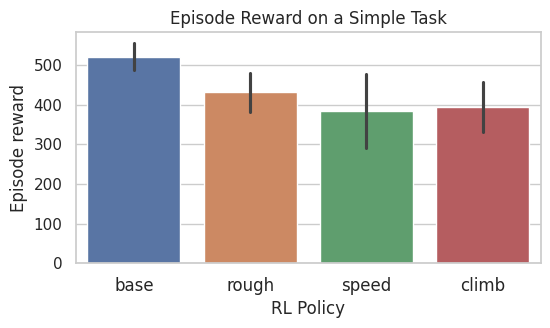

In [117]:
fig, ax = plt.subplots(figsize=(6, 3)) #8,4

max_stairs = 10
for model, df in df_dict['base_test'].items():
    df['RL Policy'] = model.split('_')[0]# + ' policy'
    df["episodic_reward"] = df["cumulated_reward"] * df["trajectory_length"]
    sns.barplot(data=df, x='RL Policy', y=df["episodic_reward"],errorbar="sd", color=color_dict[model])
    # display(df.drop(columns=['RL Policy']).mean())
    
ax.set_title('Episode Reward on a Simple Task', fontsize=fontsize)
ax.set_ylabel('Episode reward', fontsize=fontsize)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=fontsize) 
# plt.xlabel('')
plt.savefig("thesis image/9/RL/episode_reward_on_simple_task.pdf", bbox_inches='tight')
plt.show()

## c. Stair Test

### c.1 Number of stairs cleared by difficulty

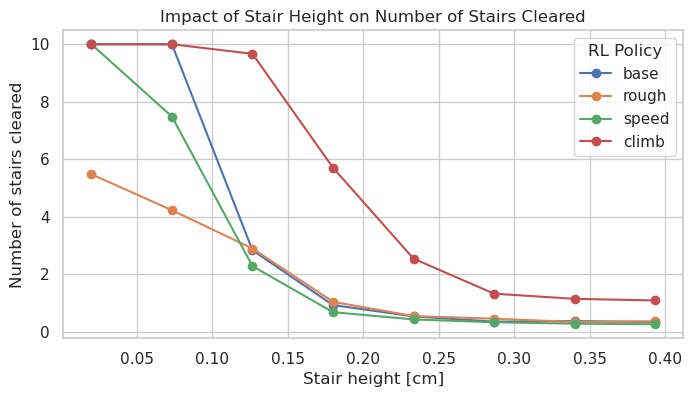

In [60]:
fig, ax = plt.subplots(figsize=(8, 4))

min_stair_height = 0.02
max_stair_height = 0.5
stair_height = np.linspace(min_stair_height, max_stair_height, 10)
max_stairs = 10

for model, df in df_dict['stair_test'].items():
   df = df[df['terrain_difficulty'] < 8].copy()
   df['stair_height'] = df['terrain_difficulty'].apply(lambda x: stair_height[int(x)])
   staired_cleared_by_difficulty = df.groupby('stair_height')['stairs_cleared'].mean().clip(upper=max_stairs)
   plt.plot(staired_cleared_by_difficulty, marker='o', linestyle='-', label=model.split('_')[0], color=color_dict[model])

ax.set_title('Impact of Stair Height on Number of Stairs Cleared', fontsize=fontsize)
ax.set_xlabel('Stair height [cm]' , fontsize=fontsize)
ax.set_ylabel('Number of stairs cleared', fontsize=fontsize)
# ax.set_xlim(0,40)
ax.legend(title='RL Policy')
plt.savefig("thesis image/9/RL/stairs_vs_difficulty.pdf", bbox_inches='tight')
plt.show()

## d. Speed Test

### d.1 Survival Rate by Speed

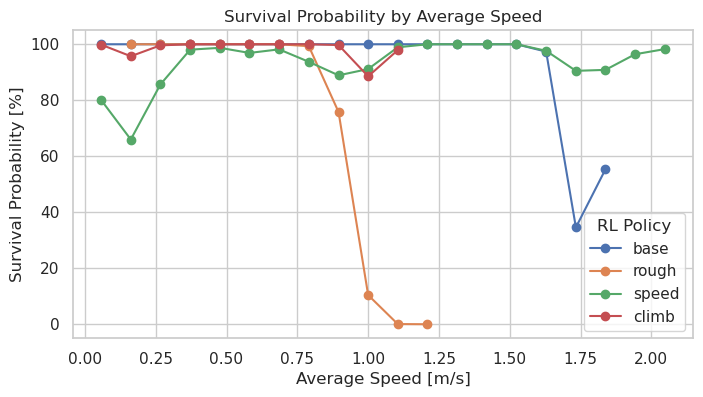

In [100]:
fig, ax = plt.subplots(figsize=(8, 4))

min_speed=-0.1
max_speed=2.1
min_elements = 150 #minimum number of element in the bin to consider the data valid
bins = np.linspace(min_speed,max_speed,22)

for model, df in df_dict['speed_test'].items():
   # # With Log Reg
   # X = df['average_speed'].values.reshape(-1, 1)  # Predictor
   # y = df['survived'].values  # Response
   # logReg = LogisticRegression()
   # logReg.fit(X, y) # Fit the logistic regression model
   # speed_range = np.linspace(df['average_speed'].min(), df['average_speed'].max(), 100).reshape(-1, 1)
   # survival_prob = logReg.predict_proba(speed_range)[:, 1] # Predict survival probability over a range of speeds
   # # sns.lineplot(x=speed_range.flatten(), y=survival_prob, ax=ax, label=model)

   # With Bins
   df['speed_bin'] = pd.cut(df['average_speed'], bins)
   survival_rate_by_speed = df.groupby('speed_bin', observed=True)['survived']
   survival_rate_by_speed = survival_rate_by_speed.mean()[survival_rate_by_speed.size() >= min_elements]
   plt.plot(survival_rate_by_speed.index.map(lambda x: x.mid), survival_rate_by_speed.values*100, marker='o', linestyle='-', label=model.split('_')[0], color=color_dict[model])

ax.set_title('Survival Probability by Average Speed', fontsize=fontsize)
ax.set_xlabel('Average Speed [m/s]', fontsize=fontsize)
ax.set_ylabel('Survival Probability [%]', fontsize=fontsize)
ax.legend(title='RL Policy', loc='lower right')
plt.savefig("thesis image/9/RL/survival_prob_speed.pdf", bbox_inches='tight')
plt.show()

### d.2 CoT by Speed

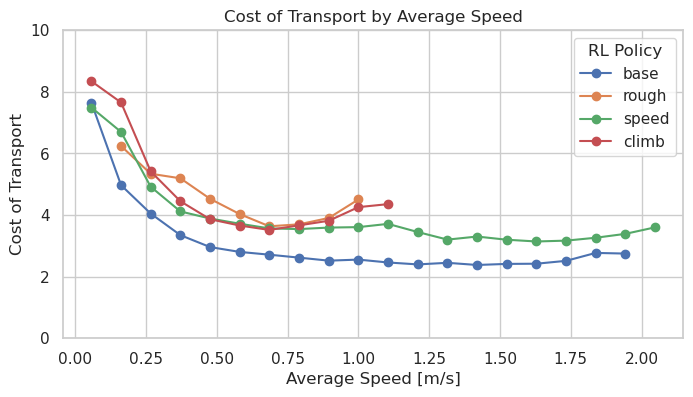

In [109]:
fig, ax = plt.subplots(figsize=(8, 4))

min_speed=-0.1
max_speed=2.1
min_elements = 50 #minimum number of element in the bin to consider the data valid
bins = np.linspace(min_speed,max_speed,22)

for model, df in df_dict['speed_test'].items():
   # With Bins
   df['speed_bin'] = pd.cut(df['average_speed'], bins)
   CoT_by_speed = df[df['trajectory_length'] >= 10.0] 
   CoT_by_speed = CoT_by_speed.groupby('speed_bin', observed=True)['cost_of_transport']
   CoT_by_speed = CoT_by_speed.mean()[CoT_by_speed.size() >= min_elements]
   # print(model, CoT_by_speed)
   plt.plot(CoT_by_speed.index.map(lambda x: x.mid), CoT_by_speed.values, marker='o', linestyle='-', label=model.split('_')[0])#, color=color_dict[model])
   

ax.set_title('Cost of Transport by Average Speed', fontsize=12)
ax.set_xlabel('Average Speed [m/s]', fontsize=12)
ax.set_ylabel('Cost of Transport', fontsize=12)
ax.set_ylim(0.0,10)
ax.legend(title='RL Policy')
plt.savefig("thesis image/9/RL/cot_vs_speed.pdf", bbox_inches='tight')
plt.show()

## e. Survival Test

### e.1 old

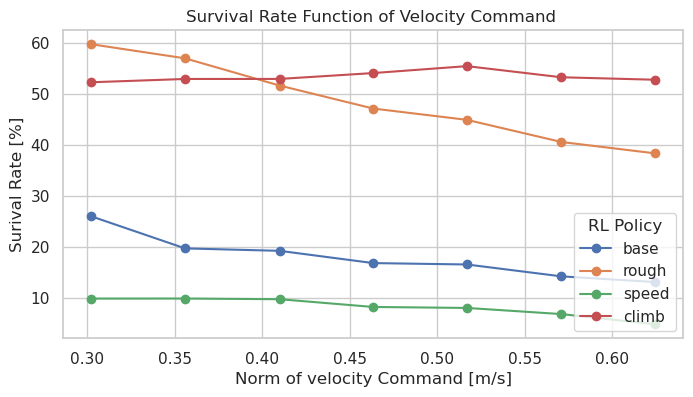

In [63]:
fig, ax = plt.subplots(figsize=(8, 4))

min_speed=-0.1
max_speed=2.1
min_elements = 50 #minimum number of element in the bin to consider the data valid
bins = np.linspace(min_speed,max_speed,42)

for model, df in df_dict['survival_test'].items():
   # With Bins
   df['commanded_speed_norm'] = np.sqrt(df['commanded_speed_for']**2 + df['commanded_speed_lat']**2)


   df['speed_bin'] = pd.cut(df['commanded_speed_norm'], bins)
   # CoT_by_speed = df[df['trajectory_length'] >= 10.0] 
   traj_length_by_speed = df.groupby('speed_bin', observed=True)['survived']
   traj_length_by_speed = traj_length_by_speed.mean()[traj_length_by_speed.size() >= min_elements]
   plt.plot(traj_length_by_speed.index.map(lambda x: x.mid), traj_length_by_speed.values*100, marker='o', linestyle='-', label=model.split('_')[0], color=color_dict[model])



ax.set_title('Survival Rate Function of Velocity Command ', fontsize=12)
ax.set_xlabel('Norm of velocity Command [m/s]' , fontsize=12)
ax.set_ylabel('Surival Rate [%]', fontsize=12)
# ax.set_xlim(0,40)
ax.legend(title='RL Policy', loc='lower right')
# plt.savefig("thesis image/9/RL/survival_rate_vs_speed.pdf", bbox_inches='tight')
plt.show()

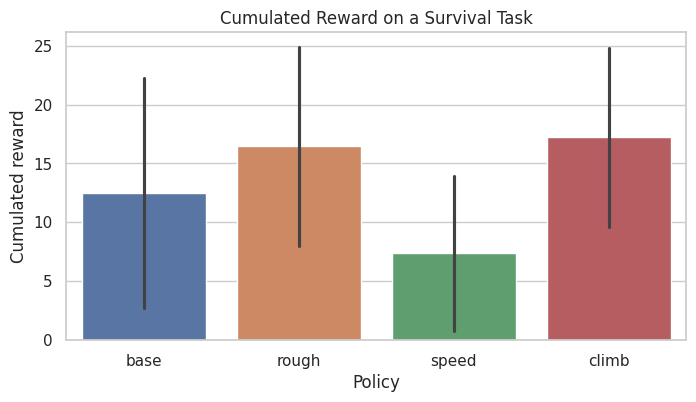

In [113]:
fig, ax = plt.subplots(figsize=(8, 4))

max_stairs = 10
for model, df in df_dict['survival_test'].items():
    df['Policy'] = model.split('_')[0]# + ' policy'
    sns.barplot(data=df, x='Policy', y=df["cumulated_reward"],errorbar="sd")
    
ax.set_title('Cumulated Reward on a Survival Task', fontsize=12)
ax.set_ylabel('Cumulated reward', fontsize=12)
# plt.xlabel('')
plt.savefig("thesis image/9/RL/cum_reward_on_survival_task.pdf", bbox_inches='tight')
plt.show()

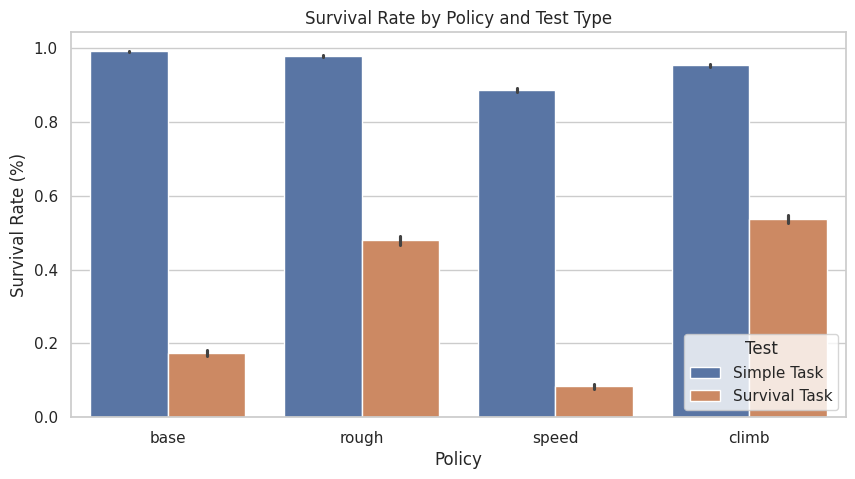

In [114]:
fig, ax = plt.subplots(figsize=(10, 5))
# First group of DataFrames
for model, df in df_dict['survival_test'].items():
    df['Policy'] = model.split('_')[0]  # Define the policy name
    df['Test'] = 'Survival Task'  # Add a column to distinguish the test type

# Second group of DataFrames
for model, df in df_dict['base_test'].items():
    df['Policy'] = model.split('_')[0]  # Define the policy name
    df['Test'] = 'Simple Task'  # Add a column to distinguish the test type

# Concatenate all DataFrames into a single DataFrame
all_dfs = pd.concat([df_dict['base_test'][model] for model in df_dict['base_test']] +
                    [df_dict['survival_test'][model] for model in df_dict['survival_test']])

# Plot with hue to distinguish between the two test groups
sns.barplot(data=all_dfs, x='Policy', y='survived', hue='Test', errorbar=("ci", 99.9))

plt.xlabel('Policy')
plt.ylabel('Survival Rate (%)')
plt.title('Survival Rate by Policy and Test Type')
plt.legend(title='Test', loc='lower right')
plt.savefig("thesis image/9/RL/survival_rate_on_simple_and_survival_task.pdf", bbox_inches='tight')
plt.show()


### e.2 Surival rate on survival task

/tmp/ipykernel_1114674/1920149458.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=fontsize)


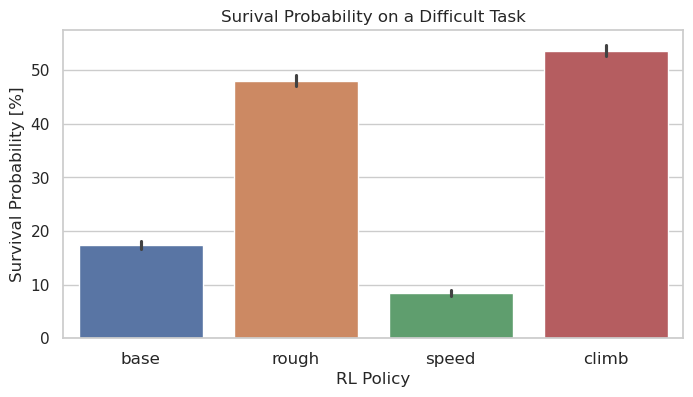

In [64]:
fig, ax = plt.subplots(figsize=(8, 4))

max_stairs = 10
for model, df in df_dict['survival_test'].items():
    df['RL Policy'] = model.split('_')[0]# + ' policy'
    sns.barplot(data=df, x='RL Policy', y=df["survived"]*100,errorbar=("ci",99.9), color=color_dict[model])
    
ax.set_title('Surival Probability on a Difficult Task', fontsize=12)
ax.set_ylabel('Survival Probability [%]', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=fontsize) 
# plt.xlabel('')
plt.savefig("thesis image/9/RL/survival_rate_on_survival_task.pdf", bbox_inches='tight')
plt.show()

#### Try on ponderation of the dataset

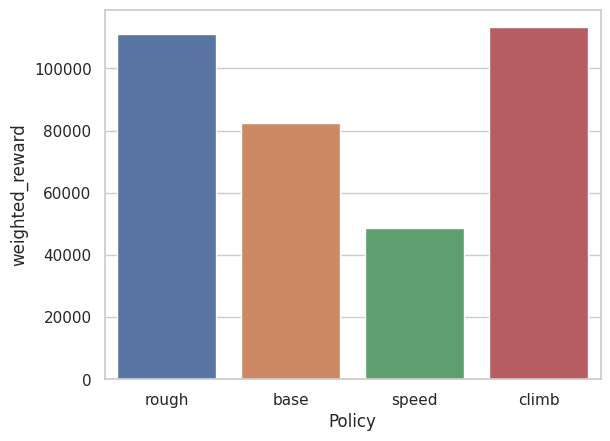

In [337]:
from scipy.stats import gaussian_kde


for model, df in df_dict['survival_test'].items():

    df['commanded_velocity_norm'] = np.sqrt(df['commanded_speed_for']**2 + df['commanded_speed_lat']**2)
    # Compute the KDE for commanded_velocity_norm
    kde = gaussian_kde(df['commanded_velocity_norm'])
    density = kde(df['commanded_velocity_norm'])

    # Calculate weights (inverse of the density)
    df['velocity_weight'] = 1 / density

    df['velocity_weight'] = df['velocity_weight'].mean()

    df['weighted_reward'] = df['cumulated_reward'] * df['velocity_weight']
    aggregated_reward = df.groupby('Policy')['weighted_reward'].sum()

    # Convert to a DataFrame for easier plotting
    aggregated_reward_df = aggregated_reward.reset_index()

    sns.barplot(data=aggregated_reward_df, x='Policy', y='weighted_reward', errorbar=("ci", 99.9))



## F. Omnidirectional Test

### F.1 Load data for omnidirectionnal test

In [121]:
import pandas as pd
import os
from sklearn.linear_model import LogisticRegression
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style=style_theme)

# path = "/home/iit.local/bsavioz/Documents/dls_orbit_bat_private/eval/play_RL_all_baseline_all_test_task_alo_alo"
path = "/home/baptiste/Documents/dls_isaac_lab_bat_private/eval/omnidirectionnal_test"

df_dict = {}
gait_df_dict = {}
task_list, model_list = [], []
for folder in os.listdir(path):
   if os.path.isdir(f"{path}/{folder}"):
      task = folder.split('-')[3]
      model = folder.split('-')[1]
      df_dict.setdefault(task, {})[model] = pd.read_pickle(f'{path}/{folder}/result_df.pkl') 
      gait_df_dict.setdefault(task, {})[model] = pd.read_pickle(f'{path}/{folder}/gait_df.pkl') 
      # display(df)

      if task not in task_list:
         task_list.append(task)
      if model not in model_list:
         model_list.append(model)

print('List of Task  : ',task_list)
print('List of Model : ',model_list)
display(df_dict['omnidirectionnal_test']['base_RL'])
# display(gait_df_dict['omnidirectionnal_test']['base_RL'])

List of Task  :  ['omnidirectionnal_test']
List of Model :  ['base_RL', 'climb_RL', 'rough_RL', 'speed_RL']


cumulated_reward  trajectory_length  survived  commanded_speed_for  \
0             -0.081925           0.280000       0.0             1.944123   
1             -0.077332           0.280000       0.0             1.926716   
2             -0.064089           0.280000       0.0             1.863487   
3             -0.049824           0.280000       0.0             1.863123   
4             -0.047106           0.280000       0.0             1.964950   
...                 ...                ...       ...                  ...   
24850         34.967590          15.000154       1.0             1.249569   
24851         34.123775          15.000154       1.0             1.491135   
24852         35.213406          15.000154       1.0             1.004520   
24853         35.354500          15.000154       1.0            -0.610802   
24854         35.198502          15.000154       1.0            -0.412076   

       commanded_speed_lat  commanded_speed_ang  average_speed  \
0                -1.156576             0.119796       0.608871   
1                -1.177842            -0.141622       0.609514   
2                -1.196652            -0.500000       0.612593   
3                -1.156177            -0.500000       0.611584   
4                -1.097914            -0.313170       0.609949   
...                    ...                  ...            ...   
24850            -0.119961            -0.035895       1.229703   
24851             0.594361            -0.370324       1.602158   
24852             0.537716             0.115893       1.135282   
24853            -0.122870             0.102951       0.623988   
24854             0.679246            -0.303690       0.780770   

       cumulated_distance  cost_of_transport  stairs_cleared  \
0                0.170484           6.318931             0.0   
1                0.170664           6.269853             0.0   
2                0.171526           6.229692             0.0   
3                0.171244           6.246143             0.0   
4                0.170786           6.445413             0.0   
...                   ...                ...             ...   
24850           18.445730           6.548090            47.0   
24851           24.032621           4.758268             2.0   
24852           17.029398           4.020586            25.0   
24853            9.359914           4.105330             5.0   
24854           11.711666           3.679776             9.0   

       terrain_difficulty  
0                     0.0  
1                     0.0  
2                     0.0  
3                     0.0  
4                     0.0  
...                   ...  
24850                 0.0  
24851                 0.0  
24852                 0.0  
24853                 0.0  
24854                 0.0  

[24855 rows x 11 columns]

In [123]:
from collections import OrderedDict

color_dict = {'base_RL': (0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
              'rough_RL': (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
              'speed_RL' : (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
              'climb_RL': (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),}

desired_order = ['base_RL', 'rough_RL', 'speed_RL', 'climb_RL']
for test, dict in df_dict.items():
    ordered_dict = OrderedDict((key, dict[key]) for key in desired_order if key in dict)
    df_dict[test] = ordered_dict

fontsize = 12

### F.2bis Polar Plot with isoline of 90% survival rate function of speed direction and norm

base_RL
rough_RL
speed_RL
climb_RL


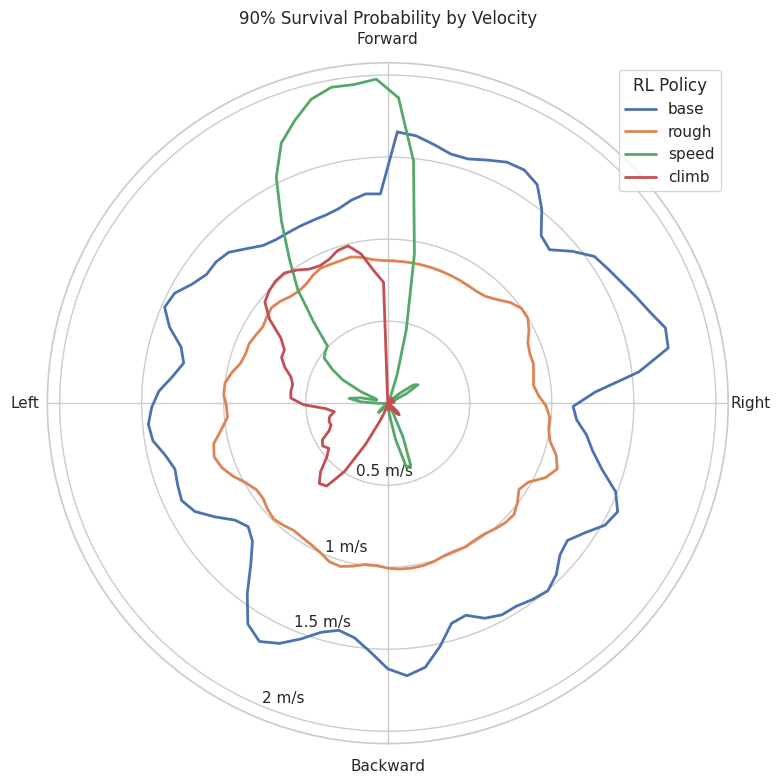

In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Create a 2x2 grid for subplots
# fig, axes = plt.subplots(2, 2, subplot_kw={'polar': True}, figsize=(14, 12))

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, polar=True)

# Flatten the axes array to iterate over it easily
# axes = axes.flatten()

# Iterate over the dataframes in the df_dict['omnidirectionnal_test'] and corresponding subplot axes
for i, (key, df) in enumerate(df_dict['omnidirectionnal_test'].items()):
    print(key)
    # Calculate the threshold
    threshold = 0.9 * df['trajectory_length'].max()

    # Calculate angles and velocity norms
    df['angle'] = np.arctan2(df['commanded_speed_lat'], df['commanded_speed_for'])
    df['velocity_norm'] = df['average_speed']

    # Bin the data by angle and speed
    angle_bins = np.linspace(-np.pi, np.pi, 90)
    df['angle_bin'] = pd.cut(df['angle'], bins=angle_bins)
    speed_bins = np.linspace(df['velocity_norm'].min(), df['velocity_norm'].max(), 10)
    df['speed_bin'] = pd.cut(df['velocity_norm'], bins=speed_bins)

    # Compute survival speeds
    survival_speeds = []
    for angle_bin in df['angle_bin'].unique():
        bin_data = df[df['angle_bin'] == angle_bin]
        max_speed = 0
        for speed_bin in bin_data['speed_bin'].unique():
            speed_bin_data = bin_data[bin_data['speed_bin'] == speed_bin]
            survival_rate = (speed_bin_data['trajectory_length'] >= threshold).mean()
            if survival_rate >= 0.9:
                max_speed = max(max_speed, speed_bin.right)
        survival_speeds.append(max_speed)

    # Calculate the center of each angle bin
    angle_bin_centers = angle_bins[:-1] + (angle_bins[1] - angle_bins[0]) / 2
    survival_speeds = np.array(survival_speeds)

    # Apply Gaussian smoothing
    sigma = 1.2  # Standard deviation for Gaussian kernel, controls the amount of smoothing
    smoothed_speeds_gaussian = gaussian_filter1d(survival_speeds, sigma=sigma)

    # Ensure the plot connects the first and last points
    angle_bin_centers = np.append(angle_bin_centers, angle_bin_centers[0])
    survival_speeds = np.append(survival_speeds, survival_speeds[0])
    smoothed_speeds_gaussian = np.append(smoothed_speeds_gaussian, smoothed_speeds_gaussian[0])

    # Plot on the respective subplot axis
    # ax = axes[i]
    # ax.plot(angle_bin_centers, survival_speeds, linewidth=2, label=key.split('_')[0])
    ax.plot(angle_bin_centers, smoothed_speeds_gaussian, linewidth=2, label=key.split('_')[0], color=color_dict[key])


ax.set_theta_zero_location('S')  # Set the zero direction to north (top of the plot)
ax.set_theta_direction(-1)  # Clockwise angle
ax.grid(True)
ax.set_title(f"90% Survival Probability by Velocity", fontsize=12)
ax.legend(loc='upper right', title='RL Policy')

# radial labels
ax.set_yticks([0.5, 1, 1.5, 2])  # Customize these based on your data range
ax.set_yticklabels(['0.5 m/s', '1 m/s', '1.5 m/s', '2 m/s'])  # Custom radial labels
# ax.set_ylabel("Speed (m/s)", labelpad=20)  # Optional: add a radial label title

# angular labels
ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])  # Positions at 0°, 90°, 180°, 270°
ax.set_xticklabels(['Backward', 'Left', 'Forward', 'Right'])  # Custom labels

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig("thesis image/9/RL/omnidirectionnal_vel.pdf", bbox_inches='tight')
plt.show()


## G Gait PLot

### 1. Load the DF

In [119]:
import pandas as pd
import os
from sklearn.linear_model import LogisticRegression
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
sns.set_theme(style=style_theme)

# path = "/home/iit.local/bsavioz/Documents/dls_orbit_bat_private/eval/omnidirectionnal_test"
# path = "/home/iit.local/bsavioz/Documents/dls_orbit_bat_private/eval/play_RL_omni_speed_test_for_gait_plot" # Give a nice plot /1\ with omndiriectionnal_test
# path = "/home/baptiste/Documents/dls_isaac_lab_bat_private/eval/play_RL_all_baseline_all_test_task"
# path = "/home/baptiste/Documents/dls_isaac_lab_bat_private/eval/play_RL_omni_speed_test_for_gait_plot" # Give a nice plot /1\
# path = "/home/baptiste/Documents/dls_isaac_lab_bat_private/eval/speed_test_new_speed_policy"
# path = "/home/iit.local/bsavioz/Documents/dls_orbit_bat_private/eval/speed_test_with_ultra_clean_speed_policy"  # With the ultra nice speed policy (aka speed3)
# path = "/home/baptiste/Documents/dls_isaac_lab_bat_private/eval/tuesday_morning_speed4_for_CoT" # With the ultra nice speed policy (aka speed4) improvement of speed 3 with freq constraint
path = "/home/baptiste/Documents/dls_isaac_lab_bat_private/eval/tuesday_morning_speed4_for_CoT3" # First test with CoT computed as the last value (and not mean on the overall traj)


df_dict = {}
gait_df_dict = {}
task_list, model_list = [], []
for folder in os.listdir(path):
   if os.path.isdir(f"{path}/{folder}"):
      task = folder.split('-')[3]
      model = folder.split('-')[1]
      df_dict.setdefault(task, {})[model] = pd.read_pickle(f'{path}/{folder}/result_df.pkl') 
      gait_df_dict.setdefault(task, {})[model] = pd.read_pickle(f'{path}/{folder}/gait_df.pkl') 
      # display(df)

      if task not in task_list:
         task_list.append(task)
      if model not in model_list:
         model_list.append(model)

print('List of Task  : ',task_list)
print('List of Model : ',model_list)
# display(df_dict['omnidirectionnal_test']['speed_RL'])
# display(gait_df_dict['omnidirectionnal_test']['speed_RL'])

result_df = df_dict['speed_test']['speed4_RL'] #/1\= omnidirectionnal_test
gait_df = gait_df_dict['speed_test']['speed4_RL']

min_speed = 0.1
max_speed = 1.9
bins = np.linspace(min_speed, max_speed, 41)

result_df['speed_bin'] = pd.cut(result_df['average_speed'], bins=bins, include_lowest=True) 
grouped_gait_df = gait_df.groupby(result_df['speed_bin'])

mean_gait_df = grouped_gait_df.mean()
mean_gait_df['leg_frequency'] = mean_gait_df[['leg_frequency_FL', 'leg_frequency_FR', 'leg_frequency_RL', 'leg_frequency_RR']].mean(axis=1)
mean_gait_df['duty_cycle']    = mean_gait_df[['duty_cycle_FL', 'duty_cycle_FR', 'duty_cycle_RL', 'duty_cycle_RR']].mean(axis=1)

# display(mean_gait_df.head(20))

List of Task  :  ['speed_test']
List of Model :  ['rough_RL', 'speed_RL', 'base_RL', 'climb_RL', 'speed4_RL']


/tmp/ipykernel_2835793/1712534813.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_gait_df = gait_df.groupby(result_df['speed_bin'])


### 2. Create the contact status DF

In [120]:
import numpy as np
import pandas as pd

# Parameters
time_interval = 0.01
total_time = 10.0
time_points = np.arange(0, total_time, time_interval)
speeds = np.linspace(min_speed, max_speed, len(time_points))

# Initialize the contact sequence
contact_sequence = {'time': [], 'speed': [], 'FR': [], 'FL': [], 'RR': [], 'RL': []}

# Initialize phases for each leg
phase = {'FR': 0.0, 'FL': 0.5, 'RR': 0.5, 'RL': 0.0}

# Simulate the contact sequence
for t, speed in zip(time_points, speeds):
    # Find the corresponding speed bin
    bin_index = np.digitize(speed, mean_gait_df.index.categories.mid) - 1
    if bin_index < 0:
        bin_index = 0
    elif bin_index >= len(mean_gait_df):
        bin_index = len(mean_gait_df) - 1

    # Calculate contact based on phase, frequency, and duty cycle for each leg
    for leg in ['FR', 'FL', 'RR', 'RL']:
        # Retrieve the frequency and duty cycle for the current leg from the binned data
        frequency = mean_gait_df.iloc[bin_index][f'leg_frequency_{leg}']
        duty_cycle = mean_gait_df.iloc[bin_index][f'duty_cycle_{leg}']
        
        # Increment phase and wrap around if necessary
        phase[leg] += frequency * time_interval
        if phase[leg] > 1.0:
            phase[leg] -= 1.0
        
        # Determine contact state based on phase and duty cycle
        contact = 1 if phase[leg] <= duty_cycle else 0
        contact_sequence[leg].append(contact)

    # Record time and speed
    contact_sequence['time'].append(t)
    contact_sequence['speed'].append(speed)

# Convert to a DataFrame
contact_df = pd.DataFrame(contact_sequence)

# Display the first few rows of the contact sequence
print(contact_df)


     time     speed  FR  FL  RR  RL
0    0.00  0.100000   1   1   1   1
1    0.01  0.101802   1   1   1   1
2    0.02  0.103604   1   1   1   1
3    0.03  0.105405   1   1   1   1
4    0.04  0.107207   1   1   1   1
..    ...       ...  ..  ..  ..  ..
995  9.95  1.892793   1   0   0   1
996  9.96  1.894595   1   0   0   1
997  9.97  1.896396   1   0   0   1
998  9.98  1.898198   1   0   0   1
999  9.99  1.900000   1   0   0   1

[1000 rows x 6 columns]


### 3. Create the plot

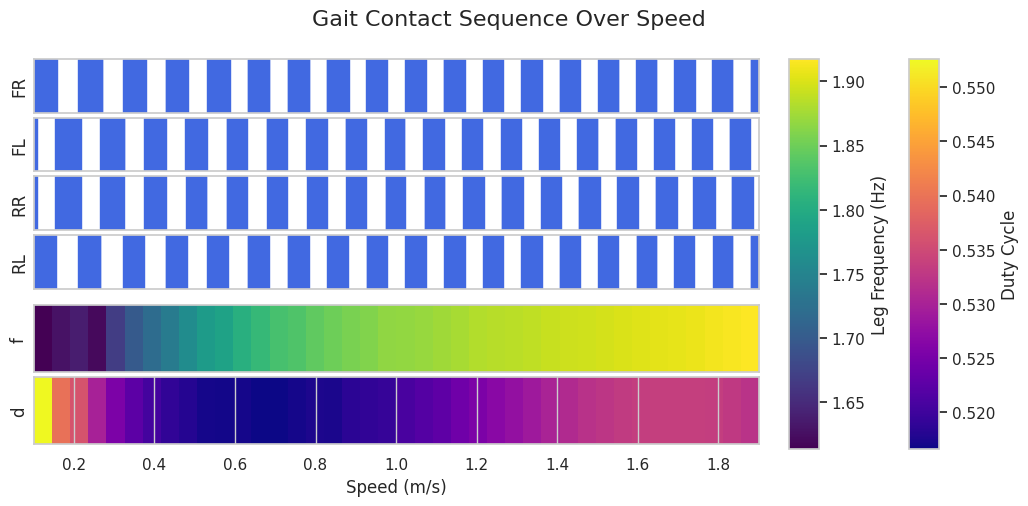

In [121]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Create the figure and GridSpec layout
fig = plt.figure(figsize=(10, 5))
fig.suptitle('Gait Contact Sequence Over Speed', fontsize=16,  x=0.6) 
gs = gridspec.GridSpec(7, 1, height_ratios=[0.8, 0.8, 0.8, 0.8,0.1, 1, 1], hspace=0.1)

# First plot: Gait Contact Sequence Over Speed (using the first four rows of the grid)
legs = ['FR', 'FL', 'RR', 'RL']
for i, leg in enumerate(legs):
    ax = fig.add_subplot(gs[i, 0])
    for speed, contact in zip(contact_df['speed'], contact_df[leg]):
        if contact == 1:
            ax.add_patch(plt.Rectangle((speed, 0), 0.01 * (max_speed - min_speed) / total_time, 1, color='royalblue'))
    
    ax.set_xlim([min_speed, max_speed])
    ax.set_ylim([0, 1])
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_ylabel(leg)
    
    # if i == 0:
    #     ax.set_title('Gait Contact Sequence Over Speed')

# Second plot: Heatmaps for Leg Frequency and Duty Cycle (using the last two rows of the grid)
ax1 = fig.add_subplot(gs[5, 0])
ax2 = fig.add_subplot(gs[6, 0])

# First heatmap for leg_frequency
leg_frequency = mean_gait_df['leg_frequency'].values.reshape(1, -1)
cax1 = ax1.imshow(leg_frequency, aspect='auto', cmap='viridis', extent=[min_speed, max_speed, 0, 1])
ax1.set_yticks([])  # Hide the y-axis
ax1.set_xticks([])
ax1.set_ylabel('f')

# Second heatmap for duty_cycle
duty_cycle = mean_gait_df['duty_cycle'].values.reshape(1, -1)
cax2 = ax2.imshow(duty_cycle, aspect='auto', cmap='plasma', extent=[min_speed, max_speed, 0, 1])
ax2.set_yticks([])  # Hide the y-axis
ax2.set_ylabel('d')

ax2.set_xlabel('Speed (m/s)')

# Add colorbars to the heatmaps
fig.subplots_adjust(right=0.85)  # Adjust space on the right for colorbars
cbar_ax1 = fig.add_axes([0.88, 0.1, 0.03, 0.78])  # [left, bottom, width, height] for the first colorbar
cbar_ax2 = fig.add_axes([1.0, 0.1, 0.03, 0.78])  # [left, bottom, width, height] for the second colorbar

cbar1 = fig.colorbar(cax1, cax=cbar_ax1, orientation='vertical')
cbar1.set_label('Leg Frequency (Hz)')

cbar2 = fig.colorbar(cax2, cax=cbar_ax2, orientation='vertical')
cbar2.set_label('Duty Cycle')

# plt.savefig("thesis image/9/RL/gait_contact_seq_base.pdf", bbox_inches='tight')
# plt.savefig("thesis image/9/RL/gait_contact_seq_speed.pdf", bbox_inches='tight')
plt.show()


#### Redo COT plot

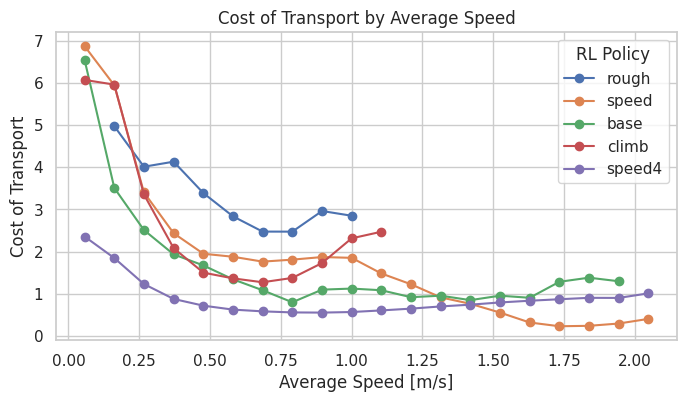

In [122]:
fig, ax = plt.subplots(figsize=(8, 4))

min_speed=-0.1
max_speed=2.1
min_elements = 50 #minimum number of element in the bin to consider the data valid
bins = np.linspace(min_speed,max_speed,22)

for model, df in df_dict['speed_test'].items():
   # print(model)
   # display(df)
   # With Bins
   df['speed_bin'] = pd.cut(df['average_speed'], bins)
   CoT_by_speed = df[df['trajectory_length'] >= 10.0] 
   CoT_by_speed = CoT_by_speed.groupby('speed_bin', observed=True)['cost_of_transport']
   CoT_by_speed = CoT_by_speed.mean()[CoT_by_speed.size() >= min_elements]
   # display(CoT_by_speed)
   plt.plot(CoT_by_speed.index.map(lambda x: x.mid), CoT_by_speed.values, marker='o', linestyle='-', label=model.split('_')[0])#, color=color_dict[model])
   

ax.set_title('Cost of Transport by Average Speed', fontsize=12)
ax.set_xlabel('Average Speed [m/s]', fontsize=12)
ax.set_ylabel('Cost of Transport', fontsize=12)
# ax.set_ylim(0.0,10)
ax.legend(title='RL Policy')
# plt.savefig("thesis image/9/RL/cot_vs_speed.pdf", bbox_inches='tight')
plt.show()

# Redo influence of frequency optimization with other data

#### With play_eval

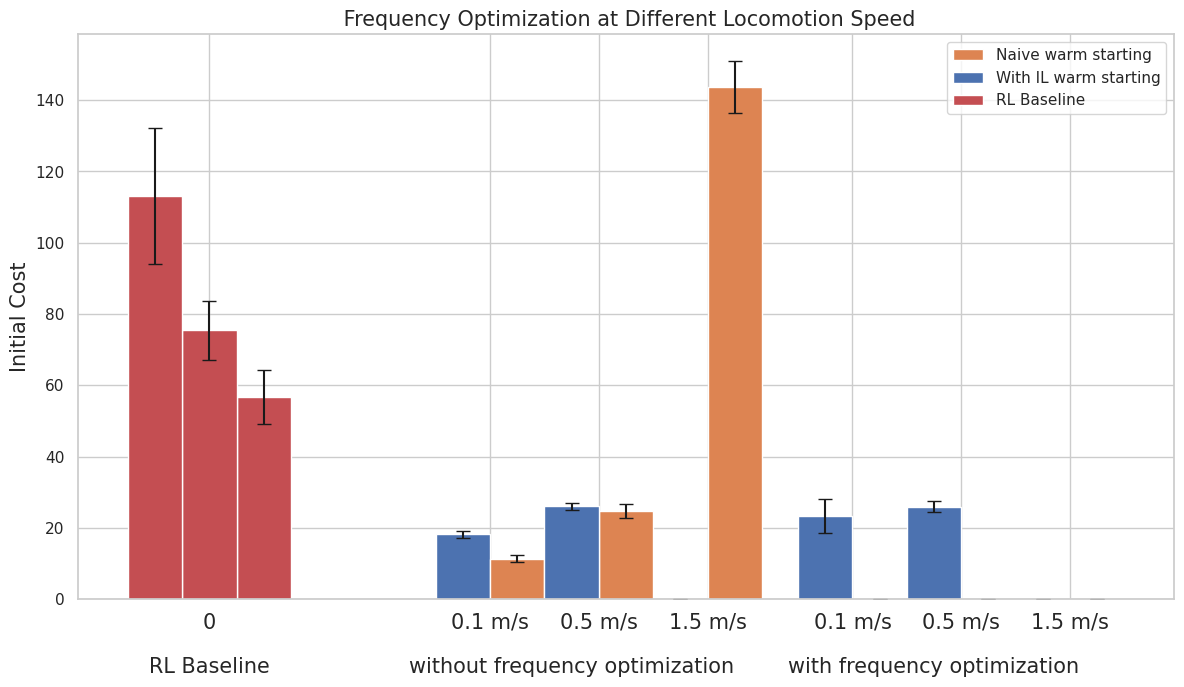

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import json
import torch
import pandas as pd

# path = "/home/baptiste/Documents/dls_isaac_lab_bat_private/eval/freq_opt_100_iter"
path = "/home/iit.local/bsavioz/Documents/dls_orbit_bat_private/eval/freq_opt_100_iter"

result_df = pd.DataFrame(columns=[])
task_list, model_list, freq_opt_list, df_list = [], [], [], []
for folder in os.listdir(path):
    if os.path.isdir(f"{path}/{folder}"):
        task_list.append(    folder.split('-')[4])
        model_list.append(   folder.split('-')[1])
        freq_opt_list.append(folder.split('-')[5])
        df_list.append(pd.read_pickle(f'{path}/{folder}/result_df.pkl'))
    
# Plotting
sns.set_theme(style=style_theme)
fig, ax = plt.subplots(figsize=(12, 7)) #(10,7)
bar_width = 0.15

vel_dict = {"fast":1.5, "medium":0.5, "slow":0.1}
label_dict = {'base_RL': 'RL Baseline', 'IL_base': 'With IL warm starting', 'NO_WS': 'Naive warm starting'}
col_dict = {'base_RL': (0.7686274509803922, 0.3058823529411765, 0.3215686274509804), 'IL_base':(0.2980392156862745, 0.4470588235294118, 0.6901960784313725), 'NO_WS' :(0.8666666666666667, 0.5176470588235295, 0.3215686274509804)}
index_dict = {
    'base_RL': {'no_frequency_optimization' : {'slow':-bar_width,     'medium':0.0,         'fast':+bar_width}},
    'IL_base': {'no_frequency_optimization' : {'slow':1-2*bar_width,  'medium':1.0,         'fast':1+2*bar_width}, 'frequency_optimization' :{'slow':2-2*bar_width,  'medium':2.0,         'fast':2+2*bar_width}},
    'NO_WS'  : {'no_frequency_optimization' : {'slow':1-1*bar_width,  'medium':1+bar_width, 'fast':1+3*bar_width}, 'frequency_optimization' :{'slow':2-1*bar_width,  'medium':2+bar_width, 'fast':2+3*bar_width}},
}

indexs, x_labels = [], []
for i in range(len(df_list)):
    median_value     = df_list[i]['sampling_init_cost_median'].median()
    first_quartile   = df_list[i]['sampling_init_cost_median'].quantile(0.25)
    third_quartile   = df_list[i]['sampling_init_cost_median'].quantile(0.75)
    error            = np.array(median_value - first_quartile, third_quartile - median_value)
    # print(f'{model_list[i]} initial cost at {vel_dict[task_list[i]]} m/s :{median_value:.3f}')
    index = index_dict[model_list[i]][freq_opt_list[i]][task_list[i]]
    label = label_dict[model_list[i]]
    ax.bar(index, median_value  , bar_width, yerr=error    ,label=label, capsize=5, color = col_dict[model_list[i]])
    indexs.append(index)
    x_labels.append(vel_dict[task_list[i]])

fontsize=15
# Create the legend using only the unique labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
ax.set_ylabel('Initial Cost',fontsize=fontsize)
ax.set_title(' Frequency Optimization at Different Locomotion Speed',fontsize=fontsize)
ax.set_xticks([0, 1-(3/2)*bar_width, 1+(1/2)*bar_width, 1+(5/2)*bar_width, 2-(3/2)*bar_width, 2+(1/2)*bar_width, 2+(5/2)*bar_width])
ax.set_xticklabels(['0', '0.1 m/s', '0.5 m/s', '1.5 m/s', '0.1 m/s', '0.5 m/s', '1.5 m/s'], rotation=0,fontsize=fontsize)
# ax.set_ylim(0,250)
group_labels = ['RL Baseline', 'without frequency optimization', 'with frequency optimization']
for i, label in enumerate(group_labels):
    ax.text(i, -0.12, label, ha='center', va='center', fontsize=fontsize, transform=ax.get_xaxis_transform())
fig.tight_layout()
# plt.savefig('thesis image/9/bar_plot_effect_freq_opt.pdf')
plt.show()

#### With play_eval_RL

cumulated_reward  \
task   model   freq                      duty_cycle                                     
fast   IL_base frequency_optimization    no_duty_cycle_optimization         10.384434   
               no_frequency_optimization no_duty_cycle_optimization         12.083373   
       NO_WS   frequency_optimization    no_duty_cycle_optimization         11.859671   
               no_frequency_optimization no_duty_cycle_optimization         22.441369   
       base_RL no_frequency_optimization no_duty_cycle_optimization         34.362742   
medium IL_base frequency_optimization    no_duty_cycle_optimization         35.209440   
               no_frequency_optimization no_duty_cycle_optimization         35.236851   
       NO_WS   frequency_optimization    no_duty_cycle_optimization         11.346625   
               no_frequency_optimization no_duty_cycle_optimization         34.208396   
       base_RL no_frequency_optimization no_duty_cycle_optimization         35.381794   
slow   IL_base frequency_optimization    no_duty_cycle_optimization         32.660467   
               no_frequency_optimization no_duty_cycle_optimization         32.612582   
       NO_WS   frequency_optimization    no_duty_cycle_optimization          7.979009   
               no_frequency_optimization no_duty_cycle_optimization         29.799756   
       base_RL no_frequency_optimization no_duty_cycle_optimization         33.265499   

                                                                     trajectory_length  \
task   model   freq                      duty_cycle                                      
fast   IL_base frequency_optimization    no_duty_cycle_optimization           5.836039   
               no_frequency_optimization no_duty_cycle_optimization           6.827061   
       NO_WS   frequency_optimization    no_duty_cycle_optimization           6.999097   
               no_frequency_optimization no_duty_cycle_optimization          13.227714   
       base_RL no_frequency_optimization no_duty_cycle_optimization          14.998244   
medium IL_base frequency_optimization    no_duty_cycle_optimization          15.000248   
               no_frequency_optimization no_duty_cycle_optimization          15.000248   
       NO_WS   frequency_optimization    no_duty_cycle_optimization           6.650572   
               no_frequency_optimization no_duty_cycle_optimization          15.000248   
       base_RL no_frequency_optimization no_duty_cycle_optimization          15.000245   
slow   IL_base frequency_optimization    no_duty_cycle_optimization          15.000248   
               no_frequency_optimization no_duty_cycle_optimization          15.000248   
       NO_WS   frequency_optimization    no_duty_cycle_optimization           6.115053   
               no_frequency_optimization no_duty_cycle_optimization          15.000248   
       base_RL no_frequency_optimization no_duty_cycle_optimization          15.000245   

                                                                     survived  \
task   model   freq                      duty_cycle                             
fast   IL_base frequency_optimization    no_duty_cycle_optimization  0.000000   
               no_frequency_optimization no_duty_cycle_optimization  0.000000   
       NO_WS   frequency_optimization    no_duty_cycle_optimization  0.350000   
               no_frequency_optimization no_duty_cycle_optimization  0.850000   
       base_RL no_frequency_optimization no_duty_cycle_optimization  0.997593   
medium IL_base frequency_optimization    no_duty_cycle_optimization  1.000000   
               no_frequency_optimization no_duty_cycle_optimization  1.000000   
       NO_WS   frequency_optimization    no_duty_cycle_optimization  0.150000   
               no_frequency_optimization no_duty_cycle_optimization  1.000000   
       base_RL no_frequency_optimization no_duty_cycle_optimization  1.000000   
slow   IL_base frequency_optimization    no_duty_cyc

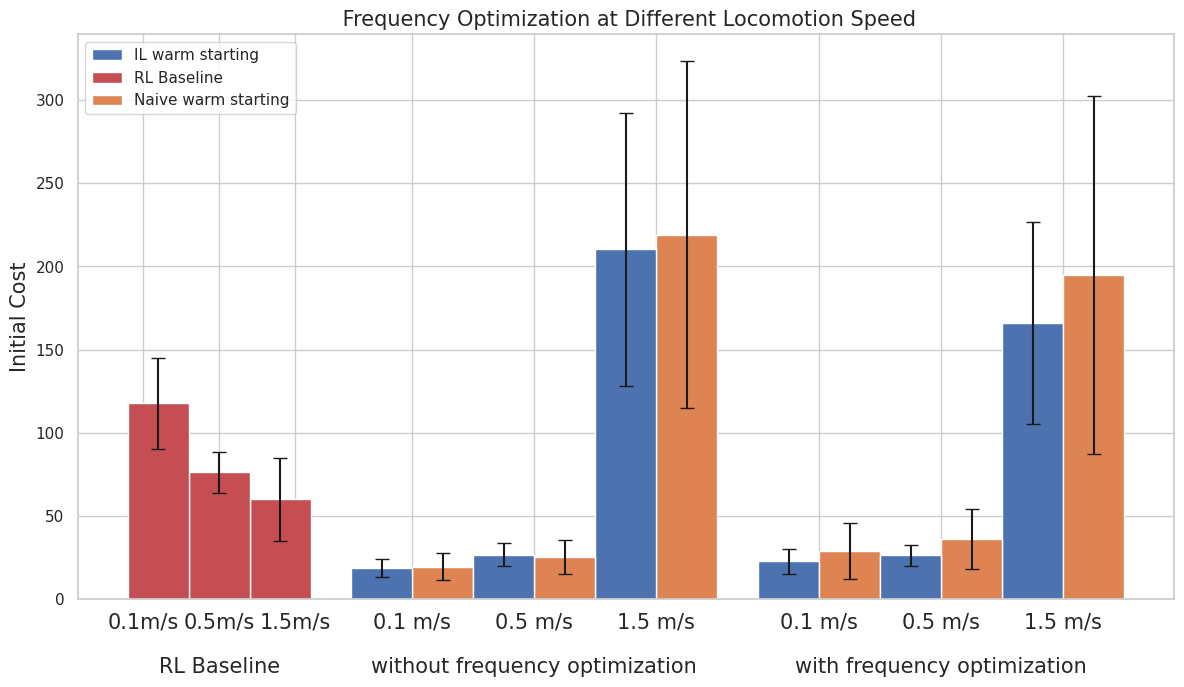

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import json
import torch
import pandas as pd
# path = "/home/baptiste/Documents/dls_isaac_lab_bat_private/eval/freq_opt_150_iter" # Step in velocity -> final velocity always 
# path = "/home/baptiste/Documents/dls_isaac_lab_bat_private/eval/freq_opt_100_iter" # 2 Steps in velocity -> final_velocity/2 for the first second 
# path = "/home/baptiste/Documents/dls_isaac_lab_bat_private/eval/freq_opt_20_iter_continous_ramp" # continous Steps in velocity between 0 and 3s
# path = "/home/baptiste/Documents/dls_isaac_lab_bat_private/eval/freq_opt_20_iter_continous_ramp_trot_for_IL" # continous Steps in velocity between 0 and 3s + trot for IL 
# path = "/home/baptiste/Documents/dls_isaac_lab_bat_private/eval/freq_opt_20_iter_continous_ramp_only_forward" # continous Steps in velocity between 0 and 3s and only forward velocity
# path = "/home/baptiste/Documents/dls_isaac_lab_bat_private/eval/freq_opt_20_iter_continous_ramp_only_forward_speed" # continous Steps in velocity between 0 and 3s and only forward velocity with speed policy
# path = "/home/iit.local/bsavioz/Documents/dls_orbit_bat_private/eval/freq_opt_d_opt_40_iter_1_4Hz_with_ramp"
# path = "/home/iit.local/bsavioz/Documents/dls_orbit_bat_private/eval/freq_opt_d_opt_40_iter_1_4Hz"
path = "/home/baptiste/Documents/dls_isaac_lab_bat_private/eval/freq_opt_d_opt_40_iter_1_4Hz"

result_df = pd.DataFrame(index=pd.MultiIndex.from_tuples([], names=['task', 'model', 'freq', 'duty_cycle']) ,columns=['cumulated_reward', 'trajectory_length', 'survived', 'average_speed', 'sampling_init_cost_mean', 'sampling_init_cost_median', 'sampling_init_cost_q1', 'sampling_init_cost_q3'])
gait_df = pd.DataFrame(index=pd.MultiIndex.from_tuples([], names=['task', 'model', 'freq', 'duty_cycle']) ,columns=['leg_frequency_FL',	'leg_frequency_FR',	'leg_frequency_RL',	'leg_frequency_RR',	'duty_cycle_FL','duty_cycle_FR','duty_cycle_RL','duty_cycle_RR','phase_offset_FR','phase_offset_RL','phase_offset_RR'])

# Plotting
sns.set_theme(style=style_theme)
fig, ax = plt.subplots(figsize=(12, 7)) #(10,7)
bar_width = 0.15

vel_dict = {"fast":1.5, "medium":0.5, "slow":0.1}
label_dict = {'base_RL': 'RL Baseline', 'IL_base': 'IL warm starting', 'NO_WS': 'Naive warm starting'}
col_dict = {'base_RL': (0.7686274509803922, 0.3058823529411765, 0.3215686274509804), 'IL_base':(0.2980392156862745, 0.4470588235294118, 0.6901960784313725), 'NO_WS' :(0.8666666666666667, 0.5176470588235295, 0.3215686274509804)}
index_dict = {
    'base_RL': {'no_frequency_optimization' : {'slow':bar_width,      'medium':2*bar_width, 'fast':+3*bar_width}},
    'IL_base': {'no_frequency_optimization' : {'slow':1-2*bar_width,  'medium':1.0,         'fast':1+2*bar_width}, 'frequency_optimization' :{'slow':2-2*bar_width,  'medium':2.0,         'fast':2+2*bar_width}},
    'NO_WS'  : {'no_frequency_optimization' : {'slow':1-1*bar_width,  'medium':1+bar_width, 'fast':1+3*bar_width}, 'frequency_optimization' :{'slow':2-1*bar_width,  'medium':2+bar_width, 'fast':2+3*bar_width}},
}
indexs, x_labels = [], []
for folder in os.listdir(path):
    if os.path.isdir(f"{path}/{folder}"):
        # print(folder)
        all_sampling_costs = torch.load(f"{path}/{folder}/all_sampling_costs.pt")
        all_sampling_costs = all_sampling_costs[all_sampling_costs != 0][:16000000] #number of sample to compute quantile on is limited
        df = pd.read_pickle(f'{path}/{folder}/result_df.pkl')#.drop(columns=['commanded_speed_for', 'commanded_speed_lat','commanded_speed_ang', 'cumulated_distance','cost_of_transport', 'stairs_cleared', 'terrain_difficulty', 'sampling_init_cost_median'])
        true_sampling_cost_mean = (df['sampling_init_cost_mean'] * df['trajectory_length']).sum() / df['trajectory_length'].sum()
        df = df.mean()
        df['sampling_init_cost_mean'] = true_sampling_cost_mean
        df['sampling_init_cost_median'] = all_sampling_costs.median().item()
        df['sampling_init_cost_q1'] = all_sampling_costs.quantile(0.25).item()
        df['sampling_init_cost_q3'] = all_sampling_costs.quantile(0.75).item()
        index_tuple = (folder.split('-')[4], folder.split('-')[1], folder.split('-')[5], folder.split('-')[6])
        result_df.loc[index_tuple] = df

        gait_df1 = pd.read_pickle(f'{path}/{folder}/gait_df.pkl')
        gait_df.loc[index_tuple] = gait_df1.mean()

        # if folder.split('-')[6] == 'duty_cycle_optimization':
        #     if folder.split('-')[1] == 'NO_WS':
        #         if folder.split('-')[4] == 'fast':
        #             print(folder)
        #             display(gait_df1)

        if folder.split('-')[6] == 'duty_cycle_optimization': continue

        index = index_dict[index_tuple[1]][index_tuple[2]][index_tuple[0]]
        label = label_dict[index_tuple[1]]
        indexs.append(index)
        x_labels.append(vel_dict[index_tuple[0]])
        error = np.array(df['sampling_init_cost_median'] - df['sampling_init_cost_q1'], df['sampling_init_cost_q3'] - df['sampling_init_cost_median'])
        ax.bar(index, df['sampling_init_cost_median']  , bar_width, yerr=error    ,label=label, capsize=5, color = col_dict[index_tuple[1]])

# display(result_df[result_df.index.get_level_values('duty_cycle') == 'no_duty_cycle_optimization'].sort_index())
display(result_df.sort_index())
# display(gait_df.sort_index())

fontsize=15
# Create the legend using only the unique labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
ax.set_ylabel('Initial Cost',fontsize=fontsize)
ax.set_title(' Frequency Optimization at Different Locomotion Speed',fontsize=fontsize)
ax.set_xticks([(1.5/2)*bar_width, (4/2)*bar_width, (6.5/2)*bar_width, 1-(3/2)*bar_width, 1+(1/2)*bar_width, 1+(5/2)*bar_width, 2-(3/2)*bar_width, 2+(1/2)*bar_width, 2+(5/2)*bar_width])
ax.set_xticklabels(['0.1m/s', '0.5m/s', '1.5m/s', '0.1 m/s', '0.5 m/s', '1.5 m/s', '0.1 m/s', '0.5 m/s', '1.5 m/s'], rotation=0,fontsize=fontsize)
# ax.set_ylim(0,250)
group_labels = ['RL Baseline', 'without frequency optimization', 'with frequency optimization']
for i, label in enumerate(group_labels):
    ax.text(i+bar_width/2 if i!=0 else 2*bar_width, -0.12, label, ha='center', va='center', fontsize=fontsize, transform=ax.get_xaxis_transform())
fig.tight_layout()
# plt.savefig('thesis image/9/bar_plot_effect_freq_opt.pdf')
plt.show()


# Comparison Different policy with Sampling Controller - 0.1-0.5-1.5m/s test

cumulated_reward  trajectory_length  survived  \
task   model                                                                  
fast   IL_base                       12.324731           6.984398  0.000000   
       IL_speed                      33.172630          15.000248  1.000000   
       MULTIPOLICY_baseSpeed         29.857025          15.000248  1.000000   
       NO_WS                         17.542475          11.295840  0.600000   
medium IL_base                       35.227138          15.000248  1.000000   
       IL_speed                      30.657689          15.000248  1.000000   
       MULTIPOLICY_baseSpeed         25.647432          13.945557  0.766667   
       NO_WS                         34.186991          15.000248  1.000000   
slow   IL_base                       32.611867          15.000248  1.000000   
       IL_speed                      23.494560          11.801511  0.600000   
       MULTIPOLICY_baseSpeed         21.989542          13.151873  0.666667   
       NO_WS                         29.340231          15.000248  1.000000   

                              average_speed  sampling_init_cost_mean  \
task   model                                                           
fast   IL_base                     1.464957               899.534393   
       IL_speed                    1.469612               380.898540   
       MULTIPOLICY_baseSpeed       1.481155               361.258427   
       NO_WS                       1.386901               715.246390   
medium IL_base                     0.486289                35.271974   
       IL_speed                    0.483775               152.070874   
       MULTIPOLICY_baseSpeed       0.506959               245.804546   
       NO_WS                       0.494753                42.947890   
slow   IL_base                     0.113890                22.142378   
       IL_speed                    0.131647               151.071025   
       MULTIPOLICY_baseSpeed       0.143706               232.020948   
       NO_WS                       0.109232                25.469332   

                              sampling_init_cost_median  \
task   model                                              
fast   IL_base                               206.896240   
       IL_speed                              292.127716   
       MULTIPOLICY_baseSpeed                 207.915085   
       NO_WS                                 276.970551   
medium IL_base                                26.872791   
       IL_speed                              103.037796   
       MULTIPOLICY_baseSpeed                 108.114273   
       NO_WS                                  25.045015   
slow   IL_base                                18.427578   
       IL_speed                               45.668816   
       MULTIPOLICY_baseSpeed                  91.671425   
       NO_WS                                  17.345196   

                              sampling_init_cost_q1  sampling_init_cost_q3  
task   model                                                                
fast   IL_base                           125.219902             646.159668  
       IL_speed                          257.870667             329.290100  
       MULTIPOLICY_baseSpeed             129.677887             345.010468  
       NO_WS                             131.090179             594.721863  
medium IL_base                            19.340631              35.909988  
       IL_speed                           58.195324             191.760147  
       MULTIPOLICY_baseSpeed              43.219372             254.883759  
       NO_WS                              14.911476              43.303093  
slow   IL_base                            12.803291              26.885832  
       IL_speed                           27.994308              98.758720  
       MULTIPOLICY_baseSpeed              43.836697             190.114914  
       NO_WS                              10.486269              29.793789

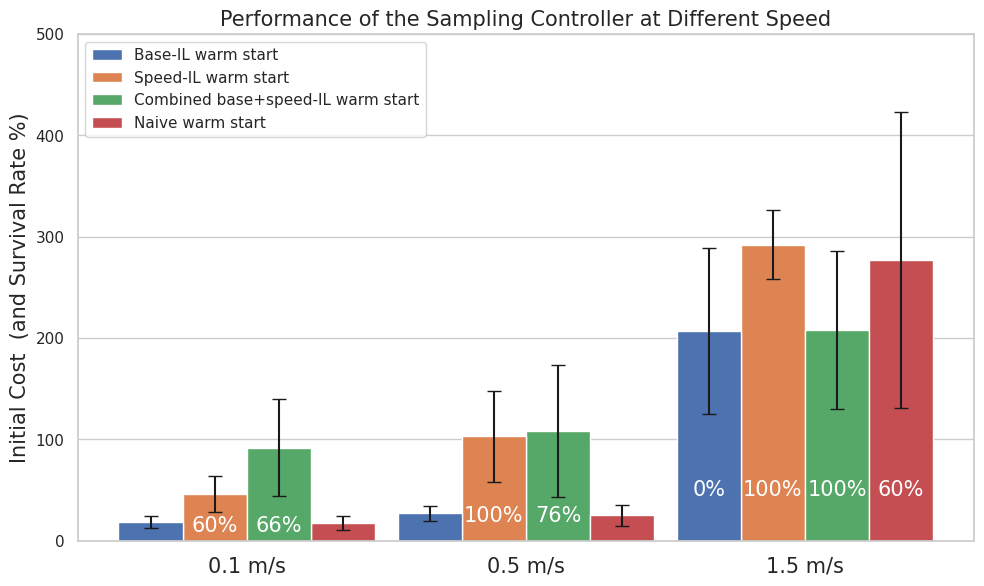

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os, json, torch
import pandas as pd

path = "/home/baptiste/Documents/dls_isaac_lab_bat_private/eval/debug_test_base_speed_rough_multipolicy"

result_df = pd.DataFrame(index=pd.MultiIndex.from_tuples([], names=['task', 'model', 'freq', 'duty_cycle']) ,columns=['cumulated_reward', 'trajectory_length', 'survived', 'average_speed', 'sampling_init_cost_mean', 'sampling_init_cost_median', 'sampling_init_cost_q1', 'sampling_init_cost_q3'])
gait_df = pd.DataFrame(index=pd.MultiIndex.from_tuples([], names=['task', 'model', 'freq', 'duty_cycle']) ,columns=['leg_frequency_FL',	'leg_frequency_FR',	'leg_frequency_RL',	'leg_frequency_RR',	'duty_cycle_FL','duty_cycle_FR','duty_cycle_RL','duty_cycle_RR','phase_offset_FR','phase_offset_RL','phase_offset_RR'])


sns.set_theme(style=style_theme)
fig, ax = plt.subplots(figsize=(10, 6)) #(10,7)
bar_width = 0.23

model = {'IL_base': 0, 'IL_speed': 1, 'MULTIPOLICY_baseSpeed': 2, 'NO_WS': 3, 'IL_rough_redo': 4, 'MULTIPOLICY_roughSpeed': 5}
task = {'slow':0, 'medium': 1, 'fast': 2}
labels = {'IL_base': 'Base-IL warm start' , 'IL_speed': 'Speed-IL warm start', 'MULTIPOLICY_baseSpeed': 'Combined base+speed-IL warm start', 'NO_WS': 'Naive warm start'}

col_dict = {'IL_base'      : (0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
            'IL_speed'     : (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
            'MULTIPOLICY_baseSpeed': (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
            'NO_WS'        : (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
            'IL_rough_redo': (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
            'MULTIPOLICY_roughSpeed': (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),}

indexs, x_labels = [], []
for folder in os.listdir(path):
    if os.path.isdir(f"{path}/{folder}"):

        if 'rough' in folder : continue

        # print(folder)
        all_sampling_costs = torch.load(f"{path}/{folder}/all_sampling_costs.pt")        
        df = pd.read_pickle(f'{path}/{folder}/result_df.pkl')#.drop(columns=['commanded_speed_for', 'commanded_speed_lat','commanded_speed_ang', 'cumulated_distance','cost_of_transport', 'stairs_cleared', 'terrain_difficulty', 'sampling_init_cost_median'])
        true_sampling_cost_mean = (df['sampling_init_cost_mean'] * df['trajectory_length']).sum() / df['trajectory_length'].sum()
        df = df.mean()
        df['sampling_init_cost_mean'] = true_sampling_cost_mean
        df['sampling_init_cost_median'] = all_sampling_costs.median().item()
        df['sampling_init_cost_q1'] = all_sampling_costs.quantile(0.25).item()
        df['sampling_init_cost_q3'] = all_sampling_costs.quantile(0.75).item()
        index_tuple = (folder.split('-')[4], folder.split('-')[1], folder.split('-')[5], folder.split('-')[6])
        result_df.loc[index_tuple] = df

        index = task[index_tuple[0]] + model[index_tuple[1]]*bar_width
        label = labels[index_tuple[1]]

        error = np.array(df['sampling_init_cost_median'] - df['sampling_init_cost_q1'], df['sampling_init_cost_q3'] - df['sampling_init_cost_median'])
        ax.bar(index, df['sampling_init_cost_median']  , bar_width, yerr=error    ,label=label, capsize=5, color = col_dict[index_tuple[1]])
               

result_df = result_df.droplevel(['freq','duty_cycle'])
result_df = result_df.sort_index()
display(result_df)






fontsize=15
ax.set_ylim(0,500)

# Create the legend using only the unique labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys())

ordered_labels = ['Base-IL warm start', 'Speed-IL warm start','Combined base+speed-IL warm start','Naive warm start']#['IL_base', 'IL_speed', 'MULTIPOLICY_baseSpeed', 'NO_WS']
ordered_handles = [by_label[label] for label in ordered_labels]
plt.legend(ordered_handles, ordered_labels)

ax.set_ylabel('Initial Cost  (and Survival Rate %)',fontsize=fontsize)
ax.set_title('Performance of the Sampling Controller at Different Speed',fontsize=fontsize)
ax.set_xticks([])
group_labels = ['0.1 m/s', '0.5 m/s', '1.5 m/s']
for i, label in enumerate(group_labels):
    ax.text(i+(3/2)*bar_width, -0.05, label, ha='center', va='center', fontsize=fontsize, transform=ax.get_xaxis_transform())


ax.text(0+1*bar_width, 0.03, '60%', ha='center', va='center', fontsize=fontsize, transform=ax.get_xaxis_transform(),color='white')
ax.text(0+2*bar_width, 0.03, '66%', ha='center', va='center', fontsize=fontsize, transform=ax.get_xaxis_transform(),color='white')

ax.text(1+1*bar_width, 0.05, '100%', ha='center', va='center', fontsize=fontsize, transform=ax.get_xaxis_transform(),color='white')
ax.text(1+2*bar_width, 0.05, '76%', ha='center', va='center', fontsize=fontsize, transform=ax.get_xaxis_transform(),color='white')

ax.text(2+0*bar_width, 0.10, '0%', ha='center', va='center', fontsize=fontsize, transform=ax.get_xaxis_transform(),color='white')
ax.text(2+1*bar_width, 0.10, '100%', ha='center', va='center', fontsize=fontsize, transform=ax.get_xaxis_transform(),color='white')
ax.text(2+2*bar_width, 0.10, '100%', ha='center', va='center', fontsize=fontsize, transform=ax.get_xaxis_transform(),color='white')
ax.text(2+3*bar_width, 0.10, '60%', ha='center', va='center', fontsize=fontsize, transform=ax.get_xaxis_transform(),color='white')

fig.tight_layout()
plt.savefig('thesis image/9/base_speed_multipolcy_across_speed.pdf')
plt.show()
